# Mapping SNPs from Pf6 against those from MalDA 

Separately for candidates & transporters ('MALDA_C&T.xlsx') and for the most locally variable genes in 'MALDA_lds.xlsx'

In [1]:
%run _standard_imports.ipynb
%run _plotting_setup.ipynb
import zarr
import numcodecs
import pandas as pd
zarr.codecs.codec_registry[numcodecs.MsgPack.codec_id] = numcodecs.MsgPack
zarr.codecs.codec_registry[numcodecs.Pickle.codec_id] = numcodecs.Pickle
import pybedtools as pbt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

scikit-allel 1.2.0
python 3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.16.1
scipy 1.1.0
pandas 0.23.4
numexpr 2.6.8
pysam 0.15.2
petl 1.2.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0
h5py 2.8.0
tables 3.4.4


In [2]:
# pickle file with final filtered Pf6 variants
final_variants_fn = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Pf6_final_1.pkl'

# file with Candidates & Transporters table
cand_transp_fn = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MALDA_C&T.xlsx'

# file with full MALDA list (for filtering by local diff score)
MALDA_for_lds_fn = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MALDA_lds.xlsx'

In [3]:
df_Pf6_variants = pd.read_pickle(final_variants_fn)
df_Pf6_variants.shape

(1616257, 48)

In [10]:
df_variants_ATP4 = df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_1211900.1') 
                                  & (df_Pf6_variants.AF > 0.01)]
df_variants_ATP4 = df_variants_ATP4.sort_values(by='POS')

In [12]:
df_variants_ATP4.to_excel('/Users/aa22/Documents/malaria_1/ATP4_from_Anna.xlsx')

Separately a dataframe of SNPs for MFR3 gene (request from Marcus), MFR3 is not in MalDA

In [4]:
df_variants_MFR3 = df_Pf6_variants[df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1']
df_variants_MFR3.shape

(159, 48)

# Mapping for Candidates & Transporters

First let's look at SNPs in candidates and transporters

In [5]:
df_cand_transp = pd.read_excel(cand_transp_fn)

In [6]:
df_cand_transp.head()

Compound   Chromosome  Position        Gene_ID  \
0  Atovaquone  Pf3D7_12_v3   1198008  PF3D7_1229100   
1  GNF-Pf4492  Pf3D7_12_v3    529831  PF3D7_1211900   
2  GNF-Pf4492  Pf3D7_12_v3    532169  PF3D7_1211900   
3  GNF-Pf4492  Pf3D7_12_v3    532193  PF3D7_1211900   
4  GNF-Pf4492  Pf3D7_12_v3    532240  PF3D7_1211900   

                                        Gene_Descrip Type Ref_Base Alt_Base  \
0      ABC+transporter%2C+%28CT+family%29+%28MRP2%29  SNP        C        G   
1  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        G        C   
2  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        C        T   
3  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        T        G   
4  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        G        A   

                  Effect Codon_Change CodingChangeConversion Gene Name  \
0  non_synonymous_coding      Gca/Cca        A403P   1207G>C      MRP2   
1  non_synonymous_coding      cCa/cGa        P990R   2969C>G      ATP4   
2  non_synonymous_coding      Gca/Aca         A211T   631G>A      ATP4   
3  non_synonymous_coding      Ata/Cta         I203L   607A>C      ATP4   
4  non_synonymous_coding      gCt/gTt       A187Val   560C>T      ATP4   

     start      end  global diff score  local diff score  \
0  1192888  1199214           0.441565          0.593533   
1   529005   532799           0.431161          0.567330   
2   529005   532799           0.431161          0.567330   
3   529005   532799           0.431161          0.567330   
4   529005   532799           0.431161          0.567330   

   distance to higher local diff score  Conservation score  
0                             136606.0                 NaN  
1                               9568.0            3.592563  
2                               9568.0            3.592563  
3                               9568.0            3.592563  
4                               9568.0            3.592563

Making a list of gene IDs in candidates and transporters list

In [7]:
gene_picks_CT = list(set(list(df_cand_transp.Gene_ID)))

In [8]:
print(gene_picks_CT, len(gene_picks_CT))

['PF3D7_0103100', 'PF3D7_1211900', 'PF3D7_1125100', 'PF3D7_1414700', 'PF3D7_1208400', 'PF3D7_0525100', 'PF3D7_1113300', 'PF3D7_0109800', 'PF3D7_0107500', 'PF3D7_0826100', 'PF3D7_1472100', 'PF3D7_1147500', 'PF3D7_0628200', 'PF3D7_0709700', 'PF3D7_1471200', 'PF3D7_0509800', 'PF3D7_0613800', 'PF3D7_1434000', 'PF3D7_0709000', 'PF3D7_1447900', 'PF3D7_0417200', 'PF3D7_0321900', 'PF3D7_0523000', 'PF3D7_0319700', 'PF3D7_1241700', 'PF3D7_1116700', 'PF3D7_0629500', 'PF3D7_1229100', 'PF3D7_0909700', 'PF3D7_1036800', 'PF3D7_1238800', 'mal_mito_3'] 32


Let's make sure every gene from gene_picks is also present in Pf6 dataset

In [10]:
print(list(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID))
for elem in gene_picks_CT:
    if elem != 'mal_mito_3':
        ans = ((elem + '.1') in list(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID))    
    else:
        ans = ('mal_mito_3:mRNA' in list(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID))
    print('Is',elem,'in Pf6 dataset?',ans)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Is PF3D7_1208400 in Pf6 dataset? True
Is PF3D7_0525100 in Pf6 dataset? True
Is PF3D7_1113300 in Pf6 dataset? True
Is PF3D7_0109800 in Pf6 dataset? True
Is PF3D7_0107500 in Pf6 dataset? True
Is PF3D7_0826100 in Pf6 dataset? True
Is PF3D7_1472100 in Pf6 dataset? True
Is PF3D7_1147500 in Pf6 dataset? True
Is PF3D7_0628200 in Pf6 dataset? True
Is PF3D7_0709700 in Pf6 dataset? True
Is PF3D7_1471200 in Pf6 dataset? True
Is PF3D7_0509800 in Pf6 dataset? True
Is PF3D7_0613800 in Pf6 dataset? True
Is PF3D7_1434000 in Pf6 dataset? True
Is PF3D7_0709000 in Pf6 dataset? True
Is PF3D7_1447900 in Pf6 dataset? True
Is PF3D7_0417200 in Pf6 dataset? True
Is PF3D7_0321900 in Pf6 dataset? True
Is PF3D7_0523000 in Pf6 dataset? True
Is PF3D7_0319700 in Pf6 dataset? True
Is PF3D7_1241700 in Pf6 dataset? True
Is PF3D7_1116700 in Pf6 dataset? True
Is PF3D7_0629500 in Pf6 dataset? True
Is PF3D7_1229100 in Pf6 dataset? True
Is PF3D7_0909700 in Pf6 dataset? True
Is PF3D7_1036800 in Pf6 dataset? True
Is PF3D7_123

So the thing is that mal_mito_3 (common gene ID, or in Pf6 - mal_mito_3:mRNA), an mRNA of CYTB gene (cytochrom b), did not pass FILTER_PASS filtering to make it to final Pf6 dataset, therefore deleting it from the gene_picks list:

In [11]:
gene_picks_CT.remove('mal_mito_3')

Thus it becomes a list of 31 not 32 gene IDs

In [12]:
print(gene_picks_CT, len(gene_picks_CT))

['PF3D7_0103100', 'PF3D7_1211900', 'PF3D7_1125100', 'PF3D7_1414700', 'PF3D7_1208400', 'PF3D7_0525100', 'PF3D7_1113300', 'PF3D7_0109800', 'PF3D7_0107500', 'PF3D7_0826100', 'PF3D7_1472100', 'PF3D7_1147500', 'PF3D7_0628200', 'PF3D7_0709700', 'PF3D7_1471200', 'PF3D7_0509800', 'PF3D7_0613800', 'PF3D7_1434000', 'PF3D7_0709000', 'PF3D7_1447900', 'PF3D7_0417200', 'PF3D7_0321900', 'PF3D7_0523000', 'PF3D7_0319700', 'PF3D7_1241700', 'PF3D7_1116700', 'PF3D7_0629500', 'PF3D7_1229100', 'PF3D7_0909700', 'PF3D7_1036800', 'PF3D7_1238800'] 31


In [12]:
# # GENERAL PLOTTING PF6 VS COWELL

# def plotting_basic(gene_picks, Pf6_dataset, Cowell_dataset):
# # TODO: add pictures of gene structures, Fluff about with domains and aa substitutions, manual cleanup!
#     i = 0
#     for elem in gene_picks:                          # elem is a genen ID from gene_picks
        
#         gene_start = Cowell_dataset['start'][list(Cowell_dataset['Gene_ID']).index(elem)] # gene start
#         gene_end = Cowell_dataset['end'][list(Cowell_dataset['Gene_ID']).index(elem)]  # gene end

        
#         print('step',i+1, '\n', 'gene ID:', elem,  '\n',                          # some useful information
#               'start, b. p.:', gene_start, '\n',
#               'end, b. p.:', gene_end, '\n',
#               'gene length, b. p.:', gene_end - gene_start + 1, '\n',
#               'gene description:', Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)], '\n',
#               'gene name:',
#                 Cowell_dataset['Gene Name'][list(Cowell_dataset['Gene_ID']).index(elem)],'\n',
#               'conservation score:', Cowell_dataset['Conservation score'][list(Cowell_dataset['Gene_ID']).index(elem)])

#         # non-synonymous coding,/// start loss and stop gain SNPs from Cowell
#         x_Cowell_important = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
#                                                   ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
#                                                    (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') )].Position) 
#                                                    #|
#                                                   #(Cowell_dataset['Effect'] == 'START_LOST') |
#                                                   #(Cowell_dataset['Effect'] == 'stop_gained') ) 
#                                                   #].Position)


#         # intergenic, intergenic_region, intron_variant and splice_region_variant+intron_variant SNPs from Cowell
#         x_Cowell_noncod = list(Cowell_dataset[  (Cowell_dataset.Gene_ID == elem) 
#                                           & ((Cowell_dataset.Effect == 'intergenic') |
#                                                   (Cowell_dataset.Effect == 'intergenic_region') |
#                                                   (Cowell_dataset.Effect == 'intron_variant') |
#                                                 (Cowell_dataset.Effect == 'splice_region_variant+intron_variant'))
#                                               ].Position)



#         # non-synonymous coding, start loss, stop gain and stop loss SNPs from Pf6
#         x_Pf6_important = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
#                                                      & (Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')].POS)
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST'))
#                                                    #].POS)


#         y_Pf6_important = list(Pf6_dataset[(Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem +'.1')
#                                                        & (Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')].AF)
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
#                                                           #| (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST'))].AF)


#         # intergenic, intragenic and intron SNPs from Pf6
#         x_Pf6_noncod = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
#                                                      & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
#                                                         | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
#                                                            | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON'))
#                                                    ].POS)
#         y_Pf6_noncod = list(Pf6_dataset[  (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
#                                                      & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
#                                                         | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
#                                                            | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON'))
#                                                    ].AF)
#         #print('pass 1')
#         y_Cowell_important = [-0.2*max(y_Pf6_important + y_Pf6_noncod)]*len(x_Cowell_important)   
#         y_Cowell_noncod =  [-0.2*max(y_Pf6_important + y_Pf6_noncod)]*len(x_Cowell_noncod)
#                                                             # for beauty

#         #print('pass 2')
#         fig = plt.figure(figsize=[20, 10])
#         ax = fig.add_subplot(111)

#         plt.xlim( gene_start, gene_end )
#         plt.ylabel("AF (Allele Frequency)",fontsize=20)
#         plt.xticks(np.arange(gene_start, gene_end, step=300),fontsize=13)
#         plt.yticks(fontsize=15)
#         plt.xlabel("Position in genome, b. p.",fontsize=20)          
        
        
#         #plt.bar(x_Cowell_important,height=y_Cowell_important,color='red')

#         ax.scatter(x_Cowell_important,y_Cowell_important,color='m',s=15,marker='D')
#         ax.scatter(x_Cowell_noncod,y_Cowell_noncod,c='blue',s=15,marker='D')
#         ax.scatter(x_Pf6_important,y_Pf6_important,c='m',s=10)
#         ax.scatter(x_Pf6_noncod,y_Pf6_noncod,c='blue',s=10)
#         ax.set_xlabel('Position in Genome, b. p.')
#         #    plt.title(elem,
#         #             Pf6_dataset['SNPEFF_GENE_NAME'][list(Pf6_dataset['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],   
#         #             Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)])

#         i += 1
#         plt.show()


In [13]:
#plotting_basic(gene_picks_CT, df_Pf6_variants, df_cand_transp)

# Analysis of local differentiation scores in full MALDA list

In [13]:
df_MALDA_lds = pd.read_excel(MALDA_for_lds_fn)

In [14]:
df_MALDA_lds.head()

Compound   Chromosome  Position        Gene_ID  \
0  Atovaquone  Pf3D7_12_v3   1198008  PF3D7_1229100   
1  GNF-Pf4492  Pf3D7_12_v3    529831  PF3D7_1211900   
2  GNF-Pf4492  Pf3D7_12_v3    532169  PF3D7_1211900   
3  GNF-Pf4492  Pf3D7_12_v3    532193  PF3D7_1211900   
4  GNF-Pf4492  Pf3D7_12_v3    532240  PF3D7_1211900   

                                        Gene_Descrip Type Ref_Base Alt_Base  \
0      ABC+transporter%2C+%28CT+family%29+%28MRP2%29  SNP        C        G   
1  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        G        C   
2  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        C        T   
3  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        T        G   
4  non-SERCA-type+Ca2++-transporting+P-ATPase+%28...  SNP        G        A   

                  Effect Codon_Change CodingChangeConversion Gene Name  \
0  non_synonymous_coding      Gca/Cca        A403P   1207G>C      MRP2   
1  non_synonymous_coding      cCa/cGa        P990R   2969C>G      ATP4   
2  non_synonymous_coding      Gca/Aca         A211T   631G>A      ATP4   
3  non_synonymous_coding      Ata/Cta         I203L   607A>C      ATP4   
4  non_synonymous_coding      gCt/gTt       A187Val   560C>T      ATP4   

       start        end  global diff score  local diff score  \
0  1192888.0  1199214.0           0.441565          0.593533   
1   529005.0   532799.0           0.431161          0.567330   
2   529005.0   532799.0           0.431161          0.567330   
3   529005.0   532799.0           0.431161          0.567330   
4   529005.0   532799.0           0.431161          0.567330   

   distance to higher local diff score  Conservation score  
0                             136606.0                 NaN  
1                               9568.0            3.592563  
2                               9568.0            3.592563  
3                               9568.0            3.592563  
4                               9568.0            3.592563

Let's see how local differentiation score is distributed for all MalDA genes

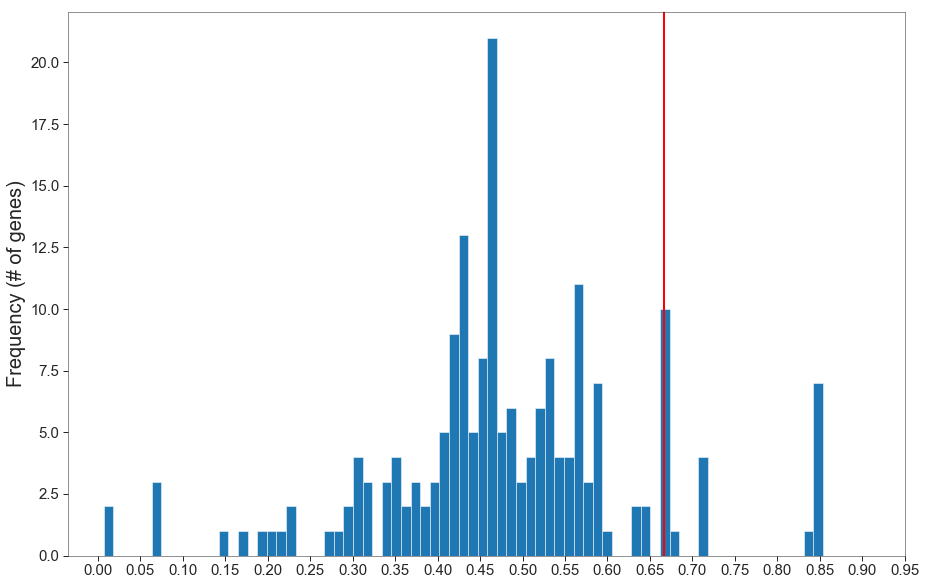

In [15]:
plt.figure(figsize=[15,10])
ax = plt.subplot(111)
plt.hist(x=df_MALDA_lds['local diff score'].dropna(),bins=75)
#plt.xlabel('xlabel', fontsize=18)
plt.xticks([0.05*i for i in range(20)],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency (# of genes)', fontsize=20)
ax.axvline(0.666527005985,color='red', lw=2)   # 99th percentile value of lds from Richard (Pf6 data)
plt.savefig('LDS_hist_MALDA.png')
plt.show()

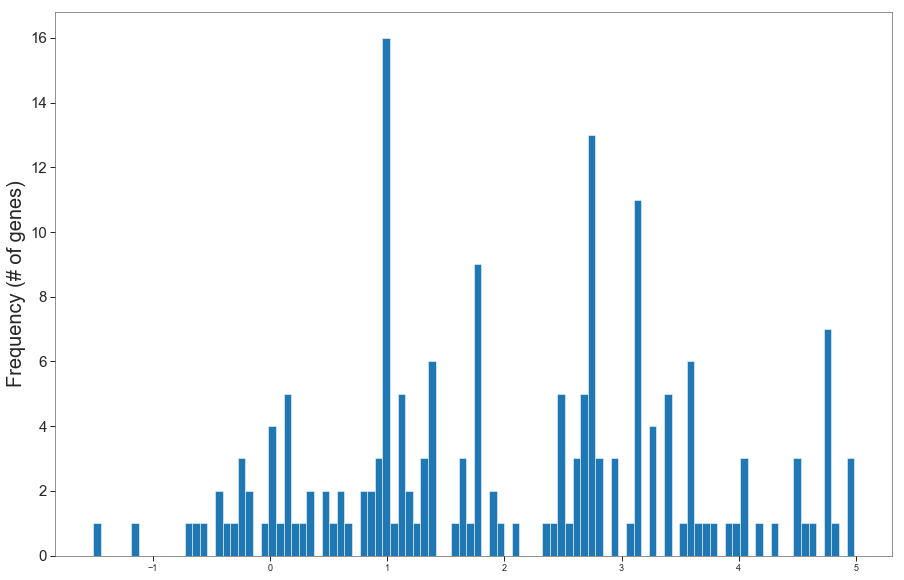

In [16]:
plt.figure(figsize=[15,10])
ax = plt.subplot(111)
plt.hist(x=df_MALDA_lds['Conservation score'].dropna(),bins=100)
#plt.xlabel('xlabel', fontsize=18)
plt.yticks(fontsize=15)
plt.ylabel('Frequency (# of genes)', fontsize=20)
plt.show()

To recreate an LDS distribution plot for all Pf6 genes it's easier to look for those values in the supplementary file to Pf6 paper, so let's export it:

In [19]:
table_Pf6_sup_fn = '/Users/aa22/Desktop/Malaria_related/gene_statistics.txt'       
df_Pf6_sup = pd.read_csv(table_Pf6_sup_fn, sep='\t')
# from here we need differentation scores, start & end

Now let's create a list of genes present in filtered Pf6 dataframe:

In [21]:
Pf6_genes = list(set(list(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID)))
print(len(Pf6_genes),'genes in filtered Pf6 dataframe')

4994 genes in filtered Pf6 dataframe


Not all the genes listed in the supplementary table made it to our filtered Pf6 list, therefore let's take local differentiation scores only of those genes that have been filtered and stayed in

In [23]:
Pf6_filtered_LDS_genes = []
for i in range(len(df_Pf6_sup)):
        if ( (df_Pf6_sup.gene_id[i] + '.1') in Pf6_genes ):
            Pf6_filtered_LDS_genes.append(df_Pf6_sup.local_differentiation_score[i])
# leaving out any Nones
Pf6_LDS_data = [elem for elem in Pf6_filtered_LDS_genes if str(elem) != 'nan']

/Users/aa22/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.6666070716048662


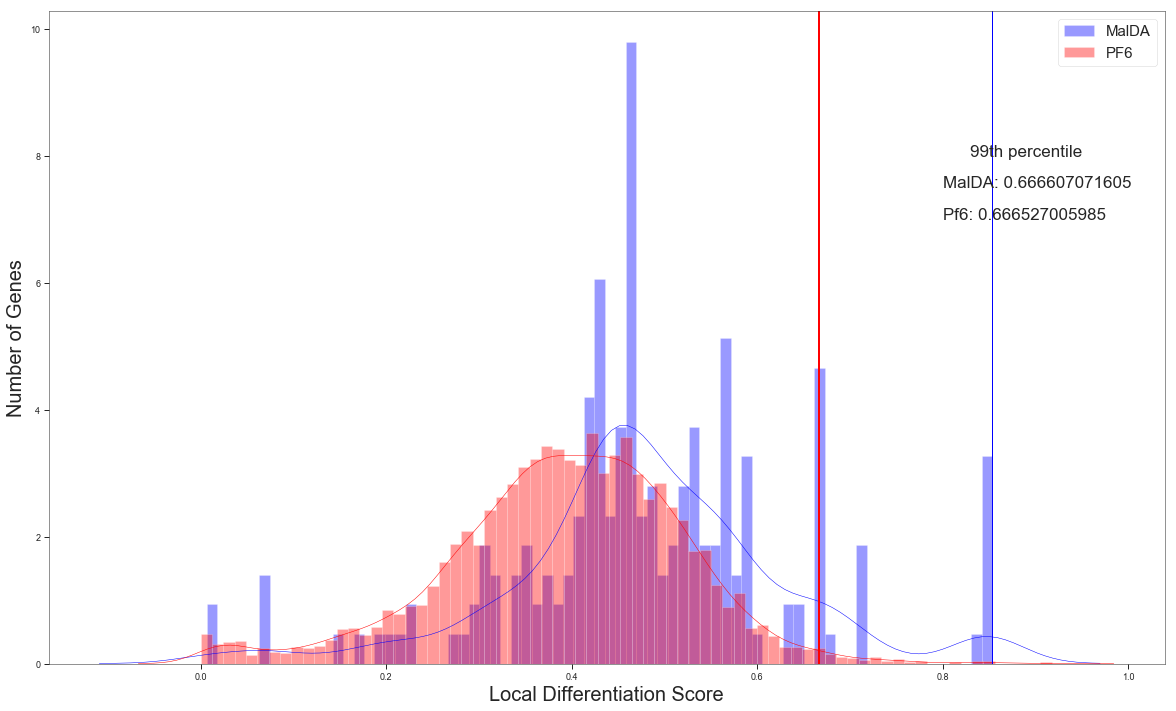

In [24]:
# THIS PLOTTING IS FOR VISUALIZATION AIMS ONLY - 
#                      MalDA and Pf6 data are not separated for any testing, the intersection is there

#from scipy.stats import norm     # to fit with normal distribution, but here we don't know if it's normal

#print(Pf6_LDS_data)
plt.figure(figsize=[20,12])
ax = plt.subplot(111)

sns.distplot(df_MALDA_lds['local diff score'].dropna(), bins = 75,color='b', kde=True,label='MalDA')
sns.distplot(Pf6_LDS_data, bins = 75, color='r',kde=True,label='PF6')
#sns.distplot(list(set(list(df_Pf6_sup['local_differentiation_score'].dropna()))), bins = 75, color='y',kde=True,label='PF6')

plt.xlabel('Local Differentiation Score',fontsize=20)
plt.ylabel('Number of Genes',fontsize=20)
plt.legend(loc='best',prop={'size': 15})

ax.axvline(0.666527005985,color='red', lw=2)   # 99th percentile value of lds from Richard (Pf6 data)
ax.axvline(np.percentile(df_MALDA_lds['local diff score'].dropna(),99),color='b', lw=1)   # 99th percentile value of lds for MALDA dataset

plt.text(0.83,8,'99th percentile',fontsize=17)
plt.text(0.8,7,'Pf6: 0.666527005985',fontsize=17)
plt.text(0.8,7.5,'MalDA: 0.666607071605',fontsize=17)

print(np.percentile(Pf6_LDS_data,99))
plt.show()

In [25]:
list_of_genes_MALDA = list(set(list(df_MALDA_lds.Gene_ID)))
print('In general:')
print(len(list_of_genes_MALDA),'genes in MalDA')
#print(list_of_genes_MALDA)
print(len(Pf6_genes),'genes in Pf6')

In general:
130 genes in MalDA
4994 genes in Pf6


Let's perform a Mann-Whitney U test, for that we first need to take out MalDA genes from the Pf6 genes:

In [26]:
Pf6_only_genes = []
for elem in Pf6_genes:
    if (elem[:-2]) not in list_of_genes_MALDA:
        Pf6_only_genes.append(elem)
print(len(Pf6_only_genes),'genes only in Pf6')

4879 genes only in Pf6


Therefore, let's drop the non-unique genes from the supplementary file and then refer only to the lds for unique genes

In [29]:
drop_list = []
for i in range(len(df_Pf6_sup)):
    #print(df_Pf6_sup.gene_id[i])
    if df_Pf6_sup.gene_id[i] + '.1' not in Pf6_only_genes:
        #print(1)
        drop_list.append(i)
print('dropping',len(drop_list),'genes from Pf6 supplementary in total')
print(len(Pf6_genes)-len(Pf6_only_genes), 
      'are not unique to Pf6 (in regards to MalDA), and the rest (713-115=598) were fitered out of initial Pf6, but no?')

dropping 713 genes from Pf6 supplementary in total
115 are not unique to Pf6 (in regards to MalDA), and the rest (713-115=598) were fitered out of initial Pf6, but no?


TODO: untangle why the # of filtered genes here doesn't match that number in the Pf6 data preparation notebook

In [30]:
df_Pf6_only = df_Pf6_sup.drop(labels=drop_list)

Okay, we separated 2 datasets, now let's actually perform the test:

In [31]:
scipy.stats.mannwhitneyu(df_MALDA_lds['local diff score'].dropna(),df_Pf6_only.local_differentiation_score)

MannwhitneyuResult(statistic=290140.0, pvalue=2.2531881204587045e-18)

Let's plot it the 2 separated distributions

/Users/aa22/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


99th percentile
Pf6_only 0.6615665790853842
MALDA 0.8537223472769957


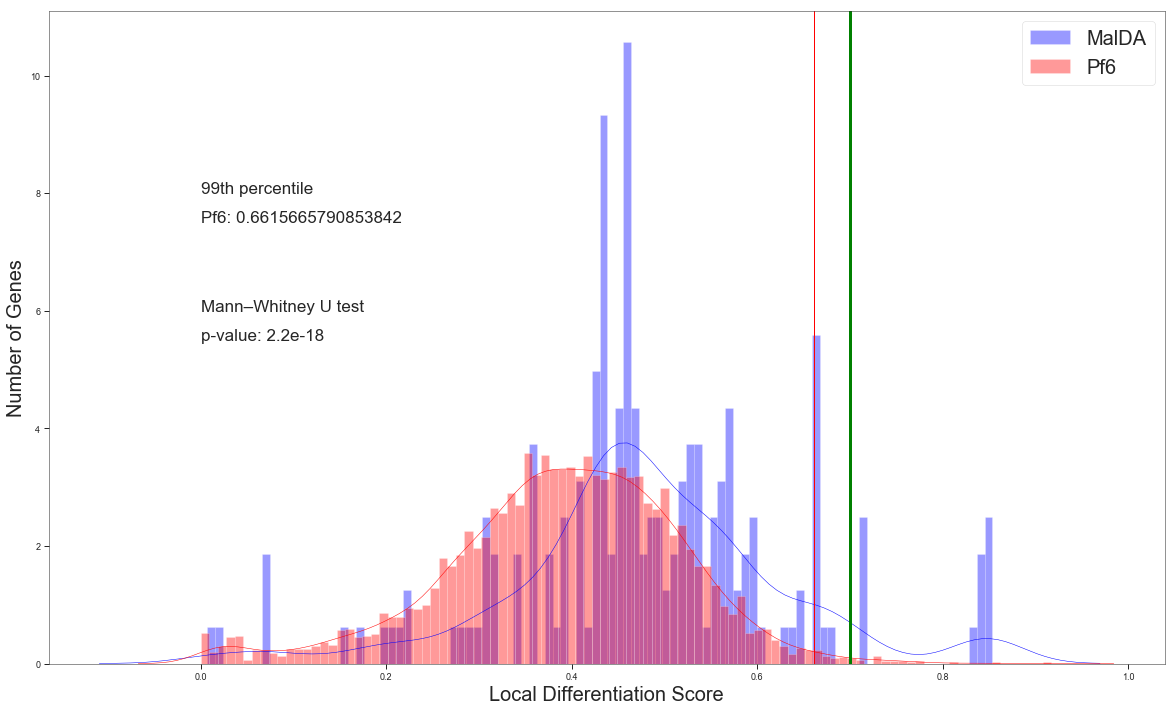

In [32]:
plt.figure(figsize=[20,12])
ax = plt.subplot(111)

sns.distplot(df_MALDA_lds['local diff score'].dropna(), bins = 100,color='b', kde=True,label='MalDA')
sns.distplot(df_Pf6_only['local_differentiation_score'].dropna(), bins = 100, color='r',kde=True,label='Pf6')

plt.legend(loc='best',prop={'size': 20})
plt.xlabel('Local Differentiation Score',fontsize=20)
plt.ylabel('Number of Genes',fontsize=20)

plt.text(0,8,'99th percentile',fontsize=17)
plt.text(0,6,'Mann–Whitney U test',fontsize=17)
plt.text(0,5.5,'p-value: 2.2e-18',fontsize=17)
plt.text(0,7.5,'Pf6: 0.6615665790853842',fontsize=17)
#plt.text(0,7,'MalDA: 0.8537223472769957',fontsize=17)


# transporter_coords = []
# for elem in gene_picks_CT:
#     ax.axvline(df_MALDA_lds['local diff score'][list(df_MALDA_lds.Gene_ID).index(elem)],color='b', lw=1)

ax.axvline(0.7,color='g', lw=3)
# the threshold above chosen by eye is lds = 0.7 because 99th percentile for MalDA would leave me with 0 or 1 gene 
                     # (because the total amount of genes is 130)

    
# 99th percentile value of lds Pf6 unique data 
ax.axvline(np.percentile(df_Pf6_only['local_differentiation_score'].dropna(),99),color='red', lw=1)

print('99th percentile')
print('Pf6_only',np.percentile(df_Pf6_only['local_differentiation_score'].dropna(),99))
print('MALDA',np.percentile(df_MALDA_lds['local diff score'].dropna(),99))
plt.show()

Now plotting lds distribution for candidates and transporters to prove the high-lds-chopping method wrong really: choosing highly locally differentiated genes we miss out on most of the interesting important genes (candidates and transporters)

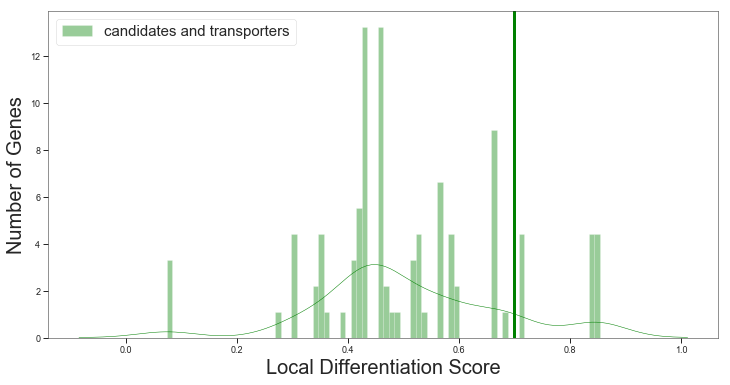

In [33]:
plt.figure(figsize=[12,6])
ax = plt.subplot(111)

sns.distplot(df_cand_transp['local diff score'].dropna(), bins = 80, color='g',kde=True,label='candidates and transporters')

plt.legend(loc='best',prop={'size': 15})
plt.xlabel('Local Differentiation Score',fontsize=20)
plt.ylabel('Number of Genes',fontsize=20)

ax.axvline(0.7,color='g', lw=3) 

However, let's look at which genes come up high on lds:

In [34]:
chosen_lds_threshold = 0.7
df_high_lds = df_MALDA_lds[df_MALDA_lds['local diff score'] > chosen_lds_threshold]  # in the end taking the 0.7 cutoff

In [35]:
df_high_lds.reset_index(inplace=True)

In [36]:
print('High LDS cutoff ( >',chosen_lds_threshold,')')
print(len(df_high_lds),'variants in', 
      len(set(list(df_high_lds.Gene_ID))),'genes:',list(set(list(df_high_lds['Gene_ID']))))
print('gene names:',list(set(list(df_high_lds['Gene Name']))))   # here nan is AAT1 - amino acid transporter

High LDS cutoff ( > 0.7 )
12 variants in 4 genes: ['PF3D7_0709000', 'PF3D7_0525100', 'PF3D7_0629500', 'PF3D7_0523000']
gene names: [nan, 'CRT', 'ACS10', 'MDR1']


In [37]:
print('in whole MalDA variant are found in', len(set(list(df_MALDA_lds.Gene_ID))),'genes:', set(list(df_MALDA_lds['Gene Name'])))

in whole MalDA variant are found in 130 genes: {nan, 'ACS11', 'UGT', 'GBP2', 'CARL', 'GAT', 'CRK5', 'RPS26', 'MRP2', 'CDPK3', 'CEP120', 'ACS10', 'ATP4', 'MDR2', 'CCp2', 'RbgA', 'VAR', 'MYCBP', 'CRMP4', 'DHFR-TS', 'VPS51', 'CRK3', 'DPAP1', 'cPheRS', 'NAR1', 'DCP2', 'SET10', 'RH1', 'PK4', 'PI4K', 'ApiAP2', 'DHHC5', 'MC-2TM', 'COX3', 'ARK3', 'RFC4', 'SEC24B', 'YIP1', 'ACT', 'ABCI3', 'LISP2', 'CYTB', 'ADT', 'CAF16', 'SEC24A', 'EBP2', 'CRT', 'MUS81', 'SulP', 'MDR1', 'RIF', 'RhopH2', 'DH60', 'eIF2beta', 'TRS85', 'ROPE'}


In [38]:
gene_picks_lds = list(set(list(df_high_lds.Gene_ID)))

In [39]:
print(gene_picks_lds, len(gene_picks_lds),set(list(df_high_lds.Gene_Descrip)))

['PF3D7_0709000', 'PF3D7_0525100', 'PF3D7_0629500', 'PF3D7_0523000'] 4 {'acyl-CoA+synthetase+%28ACS10%29', 'amino+acid+transporter%2C+putative', 'chloroquine+resistance+transporter+%28CRT%29', 'multidrug+resistance+protein+%28MDR1%29'}


# Proteomics part trial (skip)

Getting amino acid sequences of candidate gene encoded proteins

In [34]:
# This function searches for information on a specific page (page_url argument), 
#                                    in our case - amino acid sequence of the protein
def parser(page_url, tag_, filename):
    import urllib.request
    from bs4 import BeautifulSoup
    import argparse

    # Retreive web page as raw html
    page = urllib.request.urlopen(page_url)
    data = page.read()

    # Use library to find content of tag
    # Disclaimer: This assumes that the tag is unique, if it is not, you should
    #   expand this to also use the "id" of the html element desired to guarantee
    #   uniqueness.
    soup = BeautifulSoup(data, features="lxml")

    x = soup.body.find(tag_).text
    #print (x)
    fn = open(filename,"a")
    fn.write(x + '\n')
    fn.close()

In [108]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [110]:
mutual_genes_list = intersection(gene_picks_CT,gene_picks_lds)
print(mutual_genes_list, len(mutual_genes_list))

['PF3D7_0319700', 'PF3D7_0523000', 'PF3D7_0709000', 'PF3D7_0525100', 'PF3D7_1447900', 'PF3D7_0629500', 'PF3D7_0417200'] 7


In [115]:
set_of_genes = list(set(gene_picks_CT + gene_picks_lds))
print(set_of_genes, len(set_of_genes))

['PF3D7_1414700', 'PF3D7_0523800', 'PF3D7_1238800', 'PF3D7_0516500', 'PF3D7_1036800', 'PF3D7_0321900', 'PF3D7_1113300', 'PF3D7_0629500', 'PF3D7_0417200', 'PF3D7_1241700', 'PF3D7_1115400', 'PF3D7_1356800', 'PF3D7_0709000', 'PF3D7_0107500', 'PF3D7_0509800', 'PF3D7_1447900', 'PF3D7_0402300', 'PF3D7_0826100', 'PF3D7_0823300', 'PF3D7_0109800', 'PF3D7_1472100', 'PF3D7_1471200', 'PF3D7_0628200', 'PF3D7_0505100', 'PF3D7_1116700', 'PF3D7_0404600', 'PF3D7_0106300', 'PF3D7_1229100', 'PF3D7_0319700', 'PF3D7_0613800', 'PF3D7_1208400', 'PF3D7_0930300', 'PF3D7_0405100', 'PF3D7_0709700', 'PF3D7_1342900', 'PF3D7_1147500', 'PF3D7_1434000', 'PF3D7_1211900', 'PF3D7_0103100', 'PF3D7_0724400', 'PF3D7_0909700', 'PF3D7_0523000', 'PF3D7_0525100', 'PF3D7_1139300', 'PF3D7_1125100', 'PF3D7_1321100'] 46


So there are 7 common genes between gene_picks_CT and gene_picks_lds, in total we have 46 non-repetitive genes (37+16-7), let's make a dictionary:

In [116]:
geneid_to_url = {}
geneid_to_url['PF3D7_1414700'] = 'https://www.uniprot.org/uniprot/Q8ILU9'   # 1
geneid_to_url['PF3D7_0523800'] = 'https://www.uniprot.org/uniprot/Q8I3M7'   # 2
geneid_to_url['PF3D7_1238800'] = 'https://www.uniprot.org/uniprot/Q8I535'   # 3
geneid_to_url['PF3D7_0516500'] = 'https://www.uniprot.org/uniprot/C0H4E1'   # 4
geneid_to_url['PF3D7_1036800'] = 'https://www.uniprot.org/uniprot/Q8IJ40'   # 5
geneid_to_url['PF3D7_0321900'] = 'https://www.uniprot.org/uniprot/C0H483'   # 6
geneid_to_url['PF3D7_1113300'] = 'https://www.uniprot.org/uniprot/Q8IIM9'   # 7
geneid_to_url['PF3D7_0629500'] = 'https://www.uniprot.org/uniprot/C6KTD0'   # 8
geneid_to_url['PF3D7_0417200'] = 'https://www.uniprot.org/uniprot/Q8I1R6'   # 9
geneid_to_url['PF3D7_1241700'] = 'https://www.uniprot.org/uniprot/Q8I512'   # 10
geneid_to_url['PF3D7_1115400'] = 'https://www.uniprot.org/uniprot/Q8IIL0'   # 11
geneid_to_url['PF3D7_1356800'] = 'https://www.uniprot.org/uniprot/Q8IDD4'   # 12
geneid_to_url['PF3D7_0709000'] = 'https://www.uniprot.org/uniprot/Q8IBZ9'   # 13
geneid_to_url['PF3D7_0107500'] = 'https://www.uniprot.org/uniprot/Q8I266'   # 14
geneid_to_url['PF3D7_0509800'] = 'https://www.uniprot.org/uniprot/Q8I406'   # 15
geneid_to_url['PF3D7_1447900'] = 'https://www.uniprot.org/uniprot/Q8IKZ6'   # 16
geneid_to_url['PF3D7_0402300'] = 'https://www.uniprot.org/uniprot/P86148'   # 17
geneid_to_url['PF3D7_0826100'] = 'https://www.uniprot.org/uniprot/Q8IB94'   # 18
geneid_to_url['PF3D7_0823300'] = 'https://www.uniprot.org/uniprot/Q8IB67'   # 19
geneid_to_url['PF3D7_0109800'] = 'https://www.uniprot.org/uniprot/Q8I246'   # 20
geneid_to_url['PF3D7_1472100'] = 'https://www.uniprot.org/uniprot/Q8IKB7'   # 21
geneid_to_url['PF3D7_1471200'] = 'https://www.uniprot.org/uniprot/Q8IKC7'   # 22
geneid_to_url['PF3D7_0628200'] = 'https://www.uniprot.org/uniprot/C6KTB8'   # 23
geneid_to_url['PF3D7_0505100'] = 'https://www.uniprot.org/uniprot/Q8I451'   # 24
geneid_to_url['PF3D7_1116700'] = 'https://www.uniprot.org/uniprot/Q8IIJ9'   # 25
geneid_to_url['PF3D7_0404600'] = 'https://www.uniprot.org/uniprot/Q8I1Y3'   # 26
geneid_to_url['PF3D7_0106300'] = 'https://www.uniprot.org/uniprot/Q76NN8'   # 27
geneid_to_url['PF3D7_1229100'] = 'https://www.uniprot.org/uniprot/Q8I5C7'   # 28
geneid_to_url['PF3D7_0319700'] = 'https://www.uniprot.org/uniprot/O97278'   # 29
geneid_to_url['PF3D7_0613800'] = 'https://www.uniprot.org/uniprot/C6KSY0'   # 30
geneid_to_url['PF3D7_1208400'] = 'https://www.uniprot.org/uniprot/Q8I5W4'   # 31
geneid_to_url['PF3D7_0930300'] = 'https://www.uniprot.org/uniprot/Q8I0U8'   # 32
geneid_to_url['PF3D7_0405100'] = 'https://www.uniprot.org/uniprot/C0H489'   # 33
geneid_to_url['PF3D7_0709700'] = 'https://www.uniprot.org/uniprot/Q8IBZ2'   # 34
geneid_to_url['PF3D7_1342900'] = 'https://www.uniprot.org/uniprot/C0H5G5'   # 35
geneid_to_url['PF3D7_1147500'] = 'https://www.uniprot.org/uniprot/Q8IHP6'   # 36
geneid_to_url['PF3D7_1434000'] = 'https://www.uniprot.org/uniprot/Q8ILC3'   # 37
geneid_to_url['PF3D7_1211900'] = 'https://www.uniprot.org/uniprot/A0A143ZZK9' # 38
geneid_to_url['PF3D7_0103100'] = 'https://www.uniprot.org/uniprot/Q8I2A9'   # 39
geneid_to_url['PF3D7_0724400'] = 'https://www.uniprot.org/uniprot/Q8IBK8'   # 40
geneid_to_url['PF3D7_0909700'] = 'https://www.uniprot.org/uniprot/Q8I355'   # 41
geneid_to_url['PF3D7_0523000'] = 'https://www.uniprot.org/uniprot/Q7K6A5'   # 42
geneid_to_url['PF3D7_0525100'] = 'https://www.uniprot.org/uniprot/Q8I3L4'   # 43
geneid_to_url['PF3D7_1139300'] = 'https://www.uniprot.org/uniprot/Q8IHX2'   # 44
geneid_to_url['PF3D7_1125100'] = 'https://www.uniprot.org/uniprot/Q8IIB2'   # 45
geneid_to_url['PF3D7_1321100'] = 'https://www.uniprot.org/uniprot/C0H5C8'   # 46

In [117]:
for elem in geneid_to_url:               # writing amino acid sequences to the ''
    parser(page_url=geneid_to_url[elem], tag_='pre', filename='Prot_seq.txt')

geneid_to_protseq = {}
protseq_f = open("Prot_seq.txt", "r+")

lines = protseq_f.readlines()
print(lines)

prot_count = 0
for i in range(len(lines)):
    if ('>' in lines[i]):
        prot_count += 1
        while lines[i] != '\n':
            geneid_to_protseq[set_of_genes[prot_count]] += lines[i]
        i = 
        
        

fo.close()

# Somewhat proteomics part

Before we begin anything, in MalDA files Valine symbols are both 'V' and 'Val', so let's substitute all the 'Val' with 'V' for convennience:

In [40]:
count = 0
for i in range(len(df_MALDA_lds)):
    if type(df_MALDA_lds['CodingChangeConversion'][i]) is str:
        if 'Val' in df_MALDA_lds['CodingChangeConversion'][i]:
            df_MALDA_lds.loc[i,'CodingChangeConversion'] = df_MALDA_lds['CodingChangeConversion'][i].replace('Val','V')
            count += 1
print(count,'Vals found and substituted to V in MalDA lds list')

9 Vals found and substituted to V in MalDA lds list


In [41]:
count = 0
for i in range(len(df_cand_transp)):
    if type(df_cand_transp['CodingChangeConversion'][i]) is str:
        if 'Val' in df_cand_transp['CodingChangeConversion'][i]:
            df_cand_transp.loc[i,'CodingChangeConversion'] = df_cand_transp['CodingChangeConversion'][i].replace('Val','V')
            count += 1
print(count,'Vals found and substituted to V in MalDA candidates & transporters list')

6 Vals found and substituted to V in MalDA candidates & transporters list


Let's add Grantham scores (use other metrics too?) to our Pf6 dataset, also adding the degree of mutation severity:
<br>
0 < score <= 50 : 4
<br>
50 < score <= 100 : 3
<br>
100 < score <= 150 : 2
<br>
150 < score : 1

In [42]:
Grantham_matrix = {

'S':	{'R':110,	'L':145,	'P':74,	'T':58,	'A':99,	'V':124,	'G':56,	'I':142,	'F':155,	'Y':144,	'C':112,	'H':89,	'Q':68,	'N':46,	'K':121,	'D':65,	'E':80,	'M':135,	'W':177},
'R':	{'R':0,	'L':102,	'P':103,	'T':71,	'A':112,	'V':96,	'G':125,	'I':97,	'F':97,	'Y':77,	'C':180,	'H':29,	'Q':43,	'N':86,	'K':26,	'D':96,	'E':54,	'M':91,	'W':101, 'S':0},
'L':	{'R':0,	'L':0,	'P':98,	'T':92,	'A':96,	'V':32,	'G':138,	'I':5,	'F':22,	'Y':36,	'C':198,	'H':99,	'Q':113,	'N':153,	'K':107,	'D':172,	'E':138,	'M':15,	'W':61, 'S':0},
'P':	{'R':0,	'L':0,	'P':0,	'T':38,	'A':27,	'V':68,	'G':42,	'I':95,	'F':114,	'Y':110,	'C':169,	'H':77,	'Q':76,	'N':91,	'K':103,	'D':108,	'E':93,	'M':87,	'W':147, 'S':0},
'T':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':58,	'V':69,	'G':59,	'I':89,	'F':103,	'Y':92,	'C':149,	'H':47,	'Q':42,	'N':65,	'K':78,	'D':85,	'E':65,	'M':81,	'W':128, 'S':0},
'A':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':64,	'G':60,	'I':94,	'F':113,	'Y':112,	'C':195,	'H':86,	'Q':91,	'N':111,	'K':106,	'D':126,	'E':107,	'M':84,	'W':148, 'S':0},
'V':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':109,	'I':29,	'F':50,	'Y':55,	'C':192,	'H':84,	'Q':96,	'N':133,	'K':97,	'D':152,	'E':121,	'M':21,	'W':88, 'S':0},
'G':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':135,	'F':153,	'Y':147,	'C':159,	'H':98,	'Q':87,	'N':80,	'K':127,	'D':94,	'E':98,	'M':127,	'W':184, 'S':0},
'I':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':21,	'Y':33,	'C':198,	'H':94,	'Q':109,	'N':149,	'K':102,	'D':168,	'E':134,	'M':10,	'W':61, 'S':0},
'F':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':22,	'C':205,	'H':100,	'Q':116,	'N':158,	'K':102,	'D':177,	'E':140,	'M':28,	'W':40, 'S':0},
'Y':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':194,	'H':83,	'Q':99,	'N':143,	'K':85,	'D':160,	'E':122,	'M':36,	'W':37, 'S':0},
'C':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':174,	'Q':154,	'N':139,	'K':202,	'D':154,	'E':170,	'M':196,	'W':215, 'S':0},
'H':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':24,	'N':68,	'K':32,	'D':81,	'E':40,	'M':87,	'W':115, 'S':0},
'Q':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':46,	'K':53,	'D':61,	'E':29,	'M':101,	'W':130, 'S':0},
'N':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':0,	'K':94,	'D':23,	'E':42,	'M':142,	'W':174, 'S':0},
'K':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':0,	'K':0,	'D':101,	'E':56,	'M':95,	'W':110, 'S':0},
'D':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':0,	'K':0,	'D':0,	'E':45,	'M':160,	'W':181, 'S':0},
'E':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':0,	'K':0,	'D':0,	'E':0,	'M':126,	'W':152, 'S':0},
'M':	{'R':0,	'L':0,	'P':0,	'T':0,	'A':0,	'V':0,	'G':0,	'I':0,	'F':0,	'Y':0,	'C':0,	'H':0,	'Q':0,	'N':0,	'K':0,	'D':0,	'E':0,	'M':0,	'W':67, 'S':0}, 
'W':	{'R':0, 'L':0,  'P':0,  'T':0,  'A':0,  'V':0,  'G':0,  'I':0,  'F':0,  'Y':0,  'C':0,  'H':0,  'Q':0,  'N':0,  'K':0,  'D':0,  'E':0,  'M':0,  'W':0 , 'S':0}
}


In [43]:
CCF53P62_matrix = {  # you need to goddamn have positive values for synonymous snps and rewrite the functionnel!
    
'R':	{'R':5,	'L':-2,	'P':-2,	'T':-1,	'A':-1,	'V':-3,	'G':-2,	'I':-3,	'F':-3,	'Y':-2,	'C':-3,	'H':0,	'Q':1,	'N':0,	'K':2,	'D':-2,	'E':0,	'M':-1,	'W':-3, 'S':-1},
'L':	{'R':-2,	'L':4,	'P':-3,	'T':-1,	'A':-1,	'V':1,	'G':-4,	'I':2,	'F':0,	'Y':-1,	'C':-1,	'H':-3,	'Q':-2,	'N':-3,	'K':-2,	'D':-4,	'E':-3,	'M':2,	'W':-2, 'S':-2},
'P':	{'R':-2,	'L':-3,	'P':7,	'T':-1,	'A':-1,	'V':-2,	'G':-2,	'I':-3,	'F':-4,	'Y':-3,	'C':-3,	'H':-2,	'Q':-1,	'N':-2,	'K':-1,	'D':-1,	'E':-1,	'M':-2,	'W':-4, 'S':-1},
'T':	{'R':-1,	'L':-1,	'P':-1,	'T':5,	'A':0,	'V':0,	'G':-2,	'I':-1,	'F':-2,	'Y':-2,	'C':-1,	'H':-2,	'Q':-1,	'N':0,	'K':-1,	'D':-1,	'E':-1,	'M':-1,	'W':-2, 'S':1},
'A':	{'R':-1,	'L':-1,	'P':-1,	'T':0,	'A':4,	'V':0,	'G':0,	'I':-1,	'F':-2,	'Y':-2,	'C':0,	'H':-2,	'Q':-1,	'N':-2,	'K':-1,	'D':-2,	'E':-1,	'M':-1,	'W':-3, 'S':1},
'V':	{'R':-3,	'L':1,	'P':-2,	'T':0,	'A':0,	'V':4,	'G':-3,	'I':3,	'F':-1,	'Y':-1,	'C':-1,	'H':-3,	'Q':-2,	'N':-3,	'K':-2,	'D':-3,	'E':-2,	'M':1,	'W':-3, 'S':-2},
'G':	{'R':-2,	'L':-4,	'P':-2,	'T':-2,	'A':0,	'V':-3,	'G':6,	'I':-4,	'F':-3,	'Y':-3,	'C':-3,	'H':-2,	'Q':-2,	'N':0,	'K':-2,	'D':-1,	'E':-2,	'M':-3,	'W':-2, 'S':0},
'I':	{'R':-3,	'L':2,	'P':-3,	'T':-1,	'A':-1,	'V':3,	'G':-4,	'I':4,	'F':0,	'Y':-1,	'C':-1,	'H':-3,	'Q':-3,	'N':-3,	'K':-3,	'D':-3,	'E':-3,	'M':1,	'W':-3, 'S':-2},
'F':	{'R':-3,	'L':0,	'P':-4,	'T':-2,	'A':-2,	'V':-1,	'G':-3,	'I':0,	'F':6,	'Y':3,	'C':-2,	'H':-1,	'Q':-3,	'N':-3,	'K':-3,	'D':-3,	'E':-3,	'M':0,	'W':1, 'S':-2},
'Y':	{'R':-2,	'L':-1,	'P':-3,	'T':-2,	'A':-2,	'V':-1,	'G':-3,	'I':-1,	'F':3,	'Y':7,	'C':-2,	'H':2,	'Q':-1,	'N':-2,	'K':-2,	'D':-3,	'E':-2,	'M':-1,	'W':2, 'S':-2},
'C':	{'R':-3,	'L':-1,	'P':-3,	'T':-1,	'A':0,	'V':-1,	'G':-3,	'I':-1,	'F':-2,	'Y':-2,	'C':9,	'H':-3,	'Q':-3,	'N':-3,	'K':-3,	'D':-3,	'E':-4,	'M':-1,	'W':-2, 'S':-1},
'H':	{'R':0,	'L':-3,	'P':-2,	'T':-2,	'A':-2,	'V':-3,	'G':-2,	'I':-3,	'F':-1,	'Y':2,	'C':-3,	'H':8,	'Q':0,	'N':1,	'K':-1,	'D':-1,	'E':0,	'M':-2,	'W':-2, 'S':-1},
'Q':	{'R':1,	'L':-2,	'P':-1,	'T':-1,	'A':-1,	'V':-2,	'G':-2,	'I':-3,	'F':-3,	'Y':-1,	'C':-3,	'H':0,	'Q':5,	'N':0,	'K':1,	'D':0,	'E':2,	'M':0,	'W':-2, 'S':0},
'N':	{'R':0,	'L':-3,	'P':-2,	'T':0,	'A':-2,	'V':-3,	'G':0,	'I':-3,	'F':-3,	'Y':-2,	'C':-3,	'H':1,	'Q':0,	'N':6,	'K':0,	'D':1,	'E':0,	'M':-2,	'W':-4, 'S':1},
'K':	{'R':2,	'L':-2,	'P':-1,	'T':-1,	'A':-1,	'V':-2,	'G':-2,	'I':-3,	'F':-3,	'Y':-2,	'C':-3,	'H':-1,	'Q':1,	'N':0,	'K':5,	'D':-1,	'E':1,	'M':-1,	'W':-3, 'S':0},
'D':	{'R':-2,	'L':-4,	'P':-1,	'T':-1,	'A':-2,	'V':-3,	'G':-1,	'I':-3,	'F':-3,	'Y':-3,	'C':-3,	'H':-1,	'Q':0,	'N':1,	'K':-1,	'D':6,	'E':2,	'M':-3,	'W':-4, 'S':0},
'E':	{'R':0,	'L':-3,	'P':-1,	'T':-1,	'A':-1,	'V':-2,	'G':-2,	'I':-3,	'F':-3,	'Y':-2,	'C':-4,	'H':0,	'Q':2,	'N':0,	'K':1,	'D':2,	'E':5,	'M':-2,	'W':-3, 'S':0},
'M':	{'R':-1,	'L':2,	'P':-2,	'T':-1,	'A':-1,	'V':1,	'G':-3,	'I':1,	'F':0,	'Y':-1,	'C':-1,	'H':-2,	'Q':0,	'N':-2,	'K':-1,	'D':-3,	'E':-2,	'M':5,	'W':-1, 'S':-1}, 
'W':	{'R':-3, 'L':-2,  'P':-4,  'T':-2,  'A':-3,  'V':-3,  'G':-2,  'I':-3,  'F':1,  'Y':2,  'C':-2,  'H':-2,  'Q':-2,  'N':-4,  'K':-3,  'D':-4,  'E':-3,  'M':-1,  'W':11 , 'S':-3},
'S':	{'R':-1,	'L':-2,	'P':-1,	'T':1,	'A':1,	'V':-2,	'G':0,	'I':-2,	'F':-2,	'Y':-2,	'C':-1,	'H':-1, 	'Q':0,	'N':1,	'K':0,	'D':0,	'E':0,	'M':-1,	'W':-3, 'S':4},   
    
}

# -4, -3 - severity 4
# -2, -1 - severity 3
# 0, 1 - severity 2
# 2, 3 - severity 1

In [44]:
def score_Grantham(variant):
    ans = None
    substit_pattern = re.compile('\w\d+\w')
    if (type(variant) is str):
        if (len(variant) != 0):
            search_result = re.search(substit_pattern,variant)
            if (search_result != None):
                if (search_result.group(0)[0].isalpha() & search_result.group(0)[-1].isalpha()):
                    init_aa = search_result.group(0)[0]
                    substit_aa = search_result.group(0)[-1]
                    ans = max(Grantham_matrix[init_aa][substit_aa], Grantham_matrix[substit_aa][init_aa])
                else:
                    ans = 0
    else:
        ans = None
    return(ans)

In [45]:
def severity_Grantham(score):
    if (0 < score <= 50):
        return(1)
    elif(50 < score <= 100):
        return(1)
    elif(100 < score <= 150):
        return(3)
    elif(150 < score):
        return(4)
    else:
        return(None)

In [46]:
df_Pf6_variants['Grantham_score'] = df_Pf6_variants['SNPEFF_AMINO_ACID_CHANGE'].apply(lambda x: score_Grantham(x))

In [47]:
df_Pf6_variants['Severity_Grantham'] = df_Pf6_variants['Grantham_score'].apply(lambda x: severity_Grantham(x))

In [48]:
def score_CCF(variant):
    ans = None
    substit_pattern = re.compile('\w\d+\w')
    if (type(variant) is str):
        if (len(variant) != 0):
            search_result = re.search(substit_pattern,variant)
            if (search_result != None):
                if (search_result.group(0)[0].isalpha() & search_result.group(0)[-1].isalpha()):
                    init_aa = search_result.group(0)[0]
                    substit_aa = search_result.group(0)[-1]
                    ans = (CCF53P62_matrix[init_aa][substit_aa])
                else:
                    ans = None
    else:
        ans = None
    #print(ans)
    return(ans)

In [49]:
def severity_CCF(score):
    if (2 <= score <= 3):
        return(1)
    elif(0 <= score <= 1):
        return(1)
    elif(-2 <= score <= -1):
        return(3)
    elif(score <= -3):
        return(4)
    else:
        return(None)

In [50]:
df_Pf6_variants['CCF_score'] = df_Pf6_variants['SNPEFF_AMINO_ACID_CHANGE'].apply(lambda x: score_CCF(x))

In [51]:
df_Pf6_variants['Severity_CCF'] = df_Pf6_variants['CCF_score'].apply(lambda x: severity_CCF(x))

Let's add Grantham scores and severity levels to MALDA C&T and MALDA lds dataframes

In [53]:
df_MALDA_lds['Grantham_score'] = df_MALDA_lds['CodingChangeConversion'].apply(lambda x: score_Grantham(x))

In [54]:
df_MALDA_lds['Severity_Grantham'] = df_MALDA_lds['Grantham_score'].apply(lambda x: severity_Grantham(x))

In [55]:
df_MALDA_lds['CCF_score'] = df_MALDA_lds['CodingChangeConversion'].apply(lambda x: score_CCF(x))

In [56]:
df_MALDA_lds['Severity_CCF'] = df_MALDA_lds['CCF_score'].apply(lambda x: severity_CCF(x))

In [57]:
df_MALDA_lds

Compound   Chromosome  Position        Gene_ID  \
0               Atovaquone  Pf3D7_12_v3   1198008  PF3D7_1229100   
1               GNF-Pf4492  Pf3D7_12_v3    529831  PF3D7_1211900   
2               GNF-Pf4492  Pf3D7_12_v3    532169  PF3D7_1211900   
3               GNF-Pf4492  Pf3D7_12_v3    532193  PF3D7_1211900   
4               GNF-Pf4492  Pf3D7_12_v3    532240  PF3D7_1211900   
5                   GNF179  Pf3D7_10_v3   1448953  PF3D7_1036800   
6                   GNF179  Pf3D7_10_v3   1450443  PF3D7_1036800   
7                   GNF179  Pf3D7_10_v3   1450692  PF3D7_1036800   
8                   GNF179  Pf3D7_10_v3   1450264  PF3D7_1036800   
9                   GNF179  Pf3D7_10_v3   1450650  PF3D7_1036800   
10                  GNF179  Pf3D7_10_v3   1451483  PF3D7_1036800   
11                  GNF179  Pf3D7_12_v3    393639  PF3D7_1208400   
12                  GNF179  Pf3D7_10_v3   1450297  PF3D7_1036800   
13                  GNF179  Pf3D7_11_v3    519297  PF3D7_1113300   
14                  GNF179  Pf3D7_10_v3   1449790  PF3D7_1036800   
15                  GNF179  Pf3D7_10_v3   1451010  PF3D7_1036800   
16                  GNF179  Pf3D7_10_v3   1451017  PF3D7_1036800   
17                  GNF179  Pf3D7_10_v3   1451060  PF3D7_1036800   
18                  GNF707  Pf3D7_12_v3   1196289  PF3D7_1229100   
19               MMV006767  Pf3D7_07_v3    403591  PF3D7_0709000   
20               MMV006767  Pf3D7_07_v3    403990  PF3D7_0709000   
21               MMV009108  Pf3D7_01_v3    305936  PF3D7_0107500   
22               MMV011895  Pf3D7_06_v3   1215318  PF3D7_0629500   
23               MMV011895  Pf3D7_07_v3    403624  PF3D7_0709000   
24               MMV019662  Pf3D7_01_v3    304636  PF3D7_0107500   
25               MMV019662  Pf3D7_01_v3    307789  PF3D7_0107500   
26               MMV020746  Pf3D7_03_v3    823307  PF3D7_0319700   
27               MMV020746  Pf3D7_03_v3    827777  PF3D7_0319700   
28               MMV020746  Pf3D7_03_v3    827778  PF3D7_0319700   
29               MMV024114  Pf3D7_07_v3    403667  PF3D7_0709000   
..                     ...          ...       ...            ...   
183              MMV028038  Pf3D7_10_v3   1168453  PF3D7_1028300   
184              MMV028038  Pf3D7_13_v3   2185145  PF3D7_1354900   
185              MMV665852  Pf3D7_07_v3    120698  PF3D7_0703000   
186              MMV665852  Pf3D7_07_v3   1110487  PF3D7_0726400   
187              MMV665852  Pf3D7_10_v3    866652  PF3D7_1021400   
188              MMV665852  Pf3D7_12_v3    552397  PF3D7_1212500   
189              MMV665852  Pf3D7_14_v3   1581992  PF3D7_1439100   
190              MMV665882  Pf3D7_03_v3    948691  PF3D7_0322600   
191              MMV665882  Pf3D7_14_v3   2049502  PF3D7_1450000   
192              MMV668399  Pf3D7_09_v3   1137311  PF3D7_0928100   
193              MMV668399  Pf3D7_12_v3   1094758  PF3D7_1227100   
194              MMV668399  Pf3D7_14_v3   3103130  PF3D7_1475400   
195              MMV668399       M76611      1016     mal_mito_1   
196              MMV668399  Pf3D7_03_v3    255331  PF3D7_0305300   
197              MMV668399  Pf3D7_03_v3    262510  PF3D7_0305500   
198              MMV668399  Pf3D7_04_v3    482505  PF3D7_0410700   
199              MMV673482  Pf3D7_02_v3    142227  PF3D7_0203000   
200              MMV673482  Pf3D7_06_v3    809222  PF3D7_0619300   
201                NITD678  Pf3D7_07_v3    674935  PF3D7_0715100   
202                NITD678  Pf3D7_07_v3    674938  PF3D7_0715100   
203                NITD678  Pf3D7_08_v3   1353912  PF3D7_0831500   
204  pepstatin butyl ester  Pf3D7_04_v3    276762  PF3D7_0405100   
205  pepstatin butyl ester  Pf3D7_04_v3    283984  PF3D7_0405300   
206  pepstatin butyl ester  Pf3D7_05_v3   1290269  PF3D7_0531600   
207             Primaquine  Pf3D7_04_v3    138507  PF3D7_0402300   
208             Primaquine  Pf3D7_06_v3    808639  PF3D7_0619300   
209             Primaquine  Pf3D7_08_v3    121596  PF3D7_0801800   
210   

In [58]:
df_cand_transp['Grantham_score'] = df_cand_transp['CodingChangeConversion'].apply(lambda x: score_Grantham(x))

In [59]:
df_cand_transp['Severity_Grantham'] = df_cand_transp['Grantham_score'].apply(lambda x: severity_Grantham(x))

In [60]:
df_cand_transp['CCF_score'] = df_cand_transp['CodingChangeConversion'].apply(lambda x: score_CCF(x))

In [61]:
df_cand_transp['Severity_CCF'] = df_cand_transp['CCF_score'].apply(lambda x: severity_CCF(x))

In [62]:
df_cand_transp

Compound   Chromosome  Position        Gene_ID  \
0              Atovaquone  Pf3D7_12_v3   1198008  PF3D7_1229100   
1              GNF-Pf4492  Pf3D7_12_v3    529831  PF3D7_1211900   
2              GNF-Pf4492  Pf3D7_12_v3    532169  PF3D7_1211900   
3              GNF-Pf4492  Pf3D7_12_v3    532193  PF3D7_1211900   
4              GNF-Pf4492  Pf3D7_12_v3    532240  PF3D7_1211900   
5                  GNF179  Pf3D7_10_v3   1448953  PF3D7_1036800   
6                  GNF179  Pf3D7_10_v3   1450443  PF3D7_1036800   
7                  GNF179  Pf3D7_10_v3   1450692  PF3D7_1036800   
8                  GNF179  Pf3D7_10_v3   1450264  PF3D7_1036800   
9                  GNF179  Pf3D7_10_v3   1450650  PF3D7_1036800   
10                 GNF179  Pf3D7_10_v3   1451483  PF3D7_1036800   
11                 GNF179  Pf3D7_12_v3    393639  PF3D7_1208400   
12                 GNF179  Pf3D7_10_v3   1450297  PF3D7_1036800   
13                 GNF179  Pf3D7_11_v3    519297  PF3D7_1113300   
14                 GNF179  Pf3D7_10_v3   1449790  PF3D7_1036800   
15                 GNF179  Pf3D7_10_v3   1451010  PF3D7_1036800   
16                 GNF179  Pf3D7_10_v3   1451017  PF3D7_1036800   
17                 GNF179  Pf3D7_10_v3   1451060  PF3D7_1036800   
18                 GNF707  Pf3D7_12_v3   1196289  PF3D7_1229100   
19              MMV006767  Pf3D7_07_v3    403591  PF3D7_0709000   
20              MMV006767  Pf3D7_07_v3    403990  PF3D7_0709000   
21              MMV009108  Pf3D7_01_v3    305936  PF3D7_0107500   
22              MMV011895  Pf3D7_06_v3   1215318  PF3D7_0629500   
23              MMV011895  Pf3D7_07_v3    403624  PF3D7_0709000   
24              MMV019662  Pf3D7_01_v3    304636  PF3D7_0107500   
25              MMV019662  Pf3D7_01_v3    307789  PF3D7_0107500   
26              MMV020746  Pf3D7_03_v3    823307  PF3D7_0319700   
27              MMV020746  Pf3D7_03_v3    827777  PF3D7_0319700   
28              MMV020746  Pf3D7_03_v3    827778  PF3D7_0319700   
29              MMV024114  Pf3D7_07_v3    403667  PF3D7_0709000   
..                    ...          ...       ...            ...   
70              MMV008149       M76611      3868     mal_mito_3   
71              MMV008149       M76611      3882     mal_mito_3   
72              MMV008149       M76611      4341     mal_mito_3   
73              MMV011438  Pf3D7_07_v3    435160  PF3D7_0709700   
74              MMV019066  Pf3D7_08_v3   1137037  PF3D7_0826100   
75              MMV019066  Pf3D7_11_v3   1891054  PF3D7_1147500   
76              MMV019066  Pf3D7_11_v3   1891055  PF3D7_1147500   
77              MMV019719  Pf3D7_12_v3   1611521  PF3D7_1238800   
78              MMV027634  Pf3D7_04_v3    749220  PF3D7_0417200   
79              MMV027634  Pf3D7_04_v3    749294  PF3D7_0417200   
80              MMV027634  Pf3D7_04_v3    749738  PF3D7_0417200   
81              MMV028038  Pf3D7_06_v3   1164007  PF3D7_0628200   
82              MMV028038  Pf3D7_14_v3    595097  PF3D7_1414700   
83              MMV029272  Pf3D7_11_v3    631572  PF3D7_1116700   
84              MMV029272  Pf3D7_11_v3    631638  PF3D7_1116700   
85              MMV029272  Pf3D7_11_v3    632698  PF3D7_1116700   
86              MMV665789  Pf3D7_11_v3    988073  PF3D7_1125100   
87              MMV665924  Pf3D7_05_v3   1042644  PF3D7_0525100   
88              MMV665924  Pf3D7_12_v3   1612304  PF3D7_1238800   
89              MMV665924  Pf3D7_12_v3   1612364  PF3D7_1238800   
90              MMV668399  Pf3D7_09_v3    440914  PF3D7_0909700   
91              MMV668399  Pf3D7_09_v3    441197  PF3D7_0909700   
92              MMV668399  Pf3D7_09_v3    442087  PF3D7_0909700   
93              MMV668399  Pf3D7_09_v3    443072  PF3D7_0909700   
94              MMV673482  Pf3D7_05_v3    414333  PF3D7_0509800   
95              MMV673482  Pf3D7_05_v3    414617  PF3D7_0509800   
96  pepstatin butyl ester  Pf3D7_06_v3    566727  PF3D7_0613800   
97  pepstatin butyl ester  Pf3D7_07_v3    435126  PF3D7_0709700 

Andanced plotting time (with severity scores)

In [63]:
# ADVANCED PLOTTING PF6 VS COWELL (WITH GRANTHAM/OTHER SCORE METRIC)

def plotting_advanced(gene_picks, Pf6_dataset, Cowell_dataset, score_metric):
# TODO: add pictures of gene structures, Fluff about with domains and aa substitutions, manual cleanup!
# score metric is a string that says 'Grantham' or 'CCF' or something else
    severity_column_name = 'Severity_'+score_metric
    i = 0
    for elem in gene_picks:                          # elem is a genen ID from gene_picks
        
        gene_start = Cowell_dataset['start'][list(Cowell_dataset['Gene_ID']).index(elem)] # gene start
        gene_end = Cowell_dataset['end'][list(Cowell_dataset['Gene_ID']).index(elem)]  # gene end

        
        print('step',i+1, '\n', 'gene ID:', elem,  '\n',                          # some useful information
              'start, b. p.:', gene_start, '\n',
              'end, b. p.:', gene_end, '\n',
              'gene length, b. p.:', gene_end - gene_start + 1, '\n',
              'gene description:', Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)], '\n',
              'gene name:',
                Cowell_dataset['Gene Name'][list(Cowell_dataset['Gene_ID']).index(elem)],'\n',
              'conservation score:', Cowell_dataset['Conservation score'][list(Cowell_dataset['Gene_ID']).index(elem)])

        # non-synonymous coding, start loss and stop gain SNPs from Cowell
        x_Cowell_important_4 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset[severity_column_name] == 4) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
        x_Cowell_important_3 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset[severity_column_name] == 3) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
                        
        x_Cowell_important_2 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset[severity_column_name] == 2) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
        
        
        x_Cowell_important_1 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset[severity_column_name] == 1) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
        x_Cowell_important_start_stop = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                  ((Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)

        # intergenic, intergenic_region, intron_variant splice_region_variant+intron_variant SNPs from Cowell
        x_Cowell_intr = list(Cowell_dataset[  (Cowell_dataset.Gene_ID == elem) 
                                          & ((Cowell_dataset.Effect == 'intergenic') |
                                                  (Cowell_dataset.Effect == 'intergenic_region') |
                                                  (Cowell_dataset.Effect == 'intron_variant') |
                                                (Cowell_dataset.Effect == 'splice_region_variant+intron_variant'))
                                              ].Position)
        x_Cowell_syn = list(Cowell_dataset[  (Cowell_dataset.Gene_ID == elem) 
                                          & (Cowell_dataset.Effect == 'synonymous_variant')
                                              ].Position)


        # non-synonymous coding, start loss, stop gain and stop loss SNPs from Pf6
        x_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        x_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
                                                   #].POS)
        x_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        
        x_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        x_Pf6_important_start_stop = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & ((Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        y_Pf6_important_start_stop = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & ((Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        
        
        y_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        y_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                                                   #].POS)
        y_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        
        y_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset[severity_column_name] == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                    
                    
                    


        # intergenic, intragenic and intron SNPs from Pf6
        x_Pf6_intr = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SPLICE_SITE_DONOR'))
                                                   ].POS)
        y_Pf6_intr = list(Pf6_dataset[  (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SPLICE_SITE_DONOR'))
                                                   ].AF)
        # synonymous (aggregation of synonymous mutation ~ -> conservative region)
        x_Pf6_syn = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_CODING')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_STOP'))
                                                   ].POS)
        
        
        
        y_Pf6_syn = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_CODING')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_STOP'))
                                                   ].AF)
        
        
        #print('pass 1')
        y_Cowell_important_1 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_important_1) 
        y_Cowell_important_2 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4  
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_important_2)
        y_Cowell_important_3 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4  
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_important_3)
        y_Cowell_important_4 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4  
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_important_4)
        y_Cowell_intr = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4  
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_intr)
                                                            # for beauty
        y_Cowell_syn = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_syn)
        y_Cowell_important_start_stop = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 
                                         + y_Pf6_intr + y_Pf6_syn + y_Pf6_important_start_stop)]*len(x_Cowell_important_start_stop)

        #print('pass 2')
        fig = plt.figure(figsize=[15, 8])
        ax = fig.add_subplot(111)

        plt.xlim( gene_start, gene_end )
        plt.ylabel("Global Allele Frequency",fontsize=20)
        #plt.xticks(np.arange(gene_start, gene_end, step=300),fontsize=13)
        ylim = max(y_Pf6_important_1 + y_Pf6_important_2 
                         + y_Pf6_important_3 
                         + y_Pf6_important_4 + y_Pf6_intr + y_Pf6_syn) + 0.1
        plt.yticks(np.arange(0,ylim,step=ylim/10))
        plt.yticks(fontsize=15)
        plt.xlabel("Position in genome, b. p.",fontsize=20)    
        
        # colors
        sev_4_color = '#b2182b'
        sev_3_color = '#ef8a62'
        sev_2_color = '#92c5de'
        sev_1_color = 'blue'
        syn_color = 'green'
        intr_color = 'grey'
        stop_start_color = 'yellow'
        
        plt.scatter(x_Cowell_intr,y_Cowell_intr,c=intr_color,s=15,marker='D')
        plt.scatter(x_Cowell_syn,y_Cowell_syn,c=syn_color,s=15,marker='D')
        plt.scatter(x_Cowell_important_start_stop,y_Cowell_important_start_stop,c=stop_start_color,s=15,marker='D')
        
        plt.scatter(x_Pf6_intr,y_Pf6_intr,c=intr_color,s=15)
        plt.scatter(x_Pf6_syn,y_Pf6_syn,c=syn_color,s=15,marker='D')
                
        plt.scatter(x_Cowell_important_1,y_Cowell_important_1,color=sev_1_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_2,y_Cowell_important_2,color=sev_2_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_3,y_Cowell_important_3,color=sev_3_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_4,y_Cowell_important_4,color=sev_4_color,s=17,marker='D')

        plt.scatter(x_Pf6_important_1,y_Pf6_important_1,c=sev_1_color,s=17)
        plt.scatter(x_Pf6_important_2,y_Pf6_important_2,c=sev_2_color,s=17)
        plt.scatter(x_Pf6_important_3,y_Pf6_important_3,c=sev_3_color,s=17)
        plt.scatter(x_Pf6_important_4,y_Pf6_important_4,c=sev_4_color,s=17)
        
        
        
        ax.set_xlabel('Position in Genome, b. p.')
        #    plt.title(elem,
        #             Pf6_dataset['SNPEFF_GENE_NAME'][list(Pf6_dataset['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],   
        #             Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)])

        
        
        patch_sev_4 = mpatches.Patch(color=sev_4_color, label='NSC, radicality: 4')
        patch_sev_3 = mpatches.Patch(color=sev_3_color, label='NSC, radicality: 3')
        patch_sev_2 = mpatches.Patch(color=sev_2_color, label='NSC, radicality: 2')
        patch_sev_1 = mpatches.Patch(color=sev_1_color, label='NSC, radicality: 1')
        patch_intr = mpatches.Patch(color=intr_color, label='Intronic')
        patch_syn = mpatches.Patch(color=syn_color, label='Synonymous')
        patch_stop_start = mpatches.Patch(color=stop_start_color, label='Stop lost/gained, start lost')
        plt.legend(handles=[patch_sev_4,patch_sev_3,patch_sev_2,
                    patch_sev_1,patch_intr,patch_syn,patch_stop_start],prop={'size': 15},
                   bbox_to_anchor=(1.04,1), loc="upper left")
#         sns.distplot(x_Pf6_syn, hist = False, kde = True,
#                  kde_kws = {'linewidth': 5},
#                  label = 'Synonymous SNPs density')
        
        i += 1
        plt.show()



In [64]:
#plotting_advanced(gene_picks_lds, df_Pf6_variants, df_high_lds,score_metric='Grantham')

In [65]:
print(len(gene_picks_CT))
print(len(gene_picks_lds))
common_list = list(set(list(gene_picks_CT + gene_picks_lds)))
print(len(common_list))

31
4
31


step 1 
 gene ID: PF3D7_0103100 
 start, b. p.: 134353 
 end, b. p.: 139257 
 gene length, b. p.: 4905 
 gene description: vacuolar protein sorting-associated protein 51, putative 
 gene name: VPS51 
 conservation score: -0.447368421


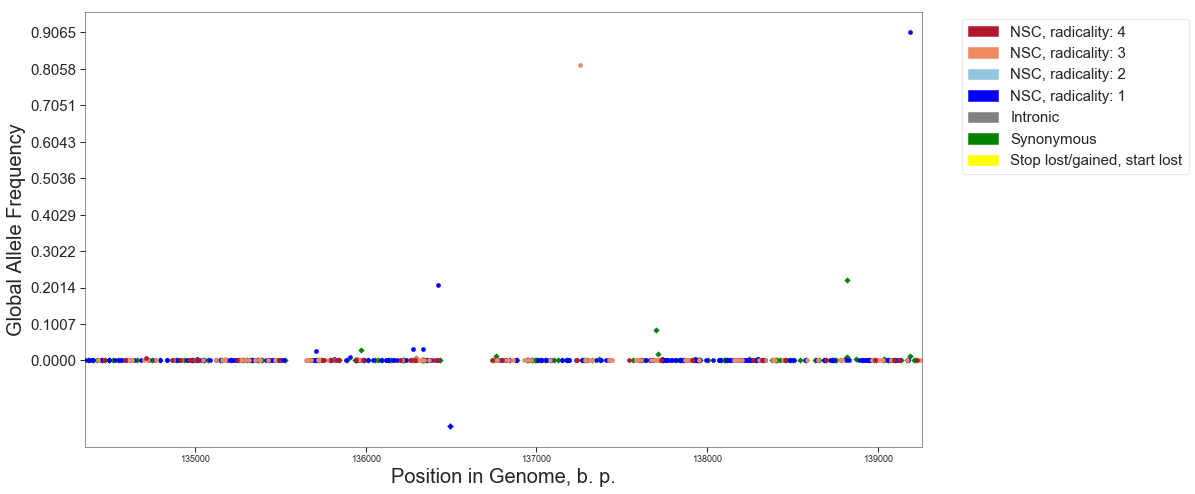

step 2 
 gene ID: PF3D7_1211900 
 start, b. p.: 529005 
 end, b. p.: 532799 
 gene length, b. p.: 3795 
 gene description: non-SERCA-type+Ca2++-transporting+P-ATPase+%28ATP4%29 
 gene name: ATP4 
 conservation score: 3.592563291


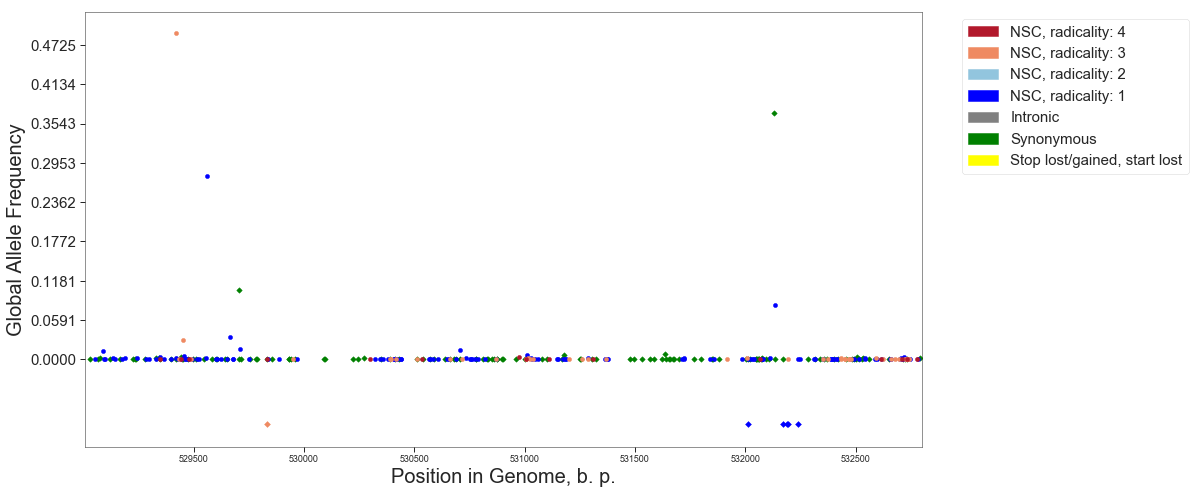

step 3 
 gene ID: PF3D7_1125100 
 start, b. p.: 986630 
 end, b. p.: 988120 
 gene length, b. p.: 1491 
 gene description: vacuolar+membrane+protein-related%2C+putative 
 gene name: nan 
 conservation score: 3.149193548


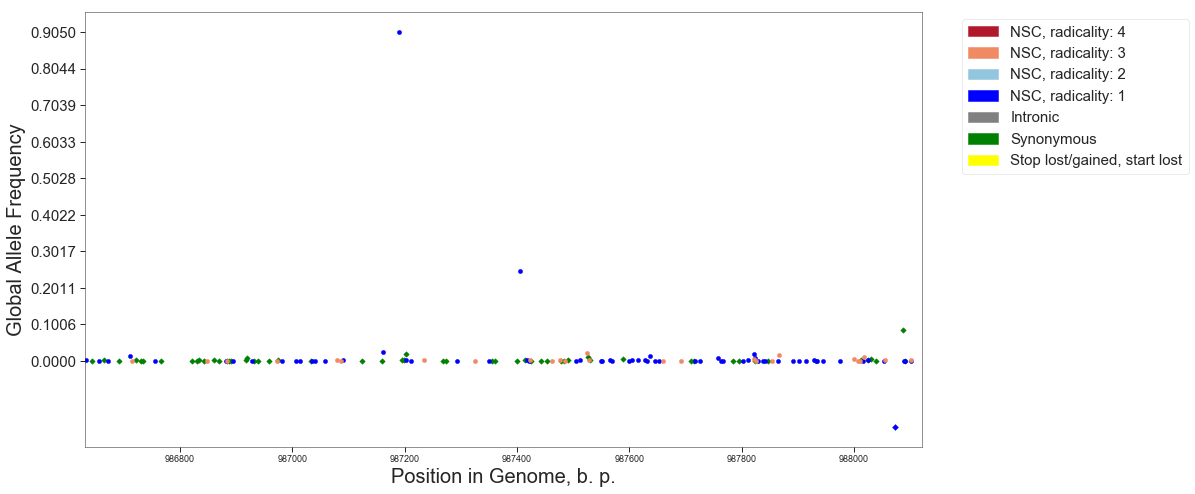

step 4 
 gene ID: PF3D7_1414700 
 start, b. p.: 592992 
 end, b. p.: 597146 
 gene length, b. p.: 4155 
 gene description: ubiquitin+carboxyl-terminal+hydrolase%2C+putative 
 gene name: nan 
 conservation score: 0.582369942


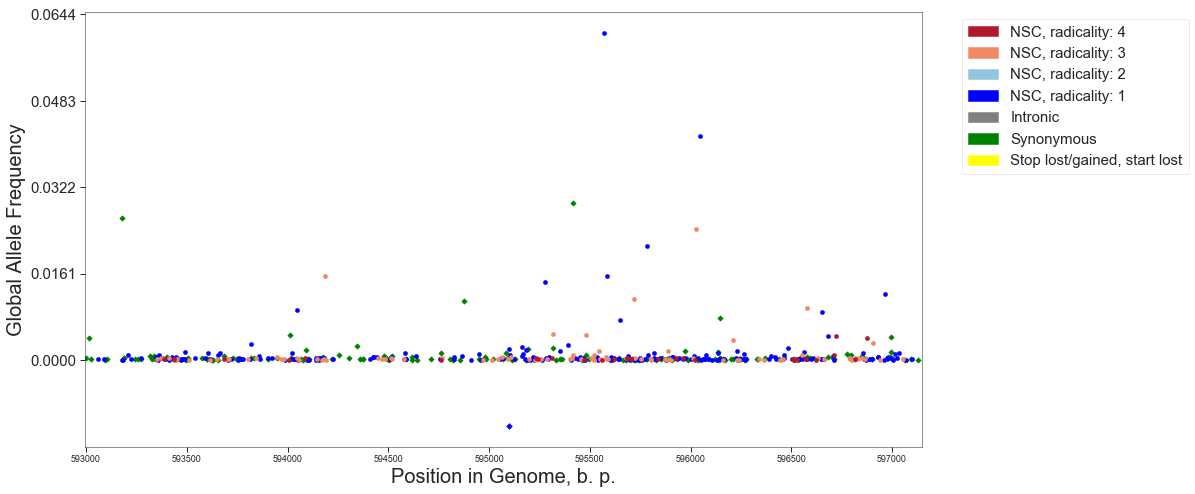

step 5 
 gene ID: PF3D7_1208400 
 start, b. p.: 390932 
 end, b. p.: 395626 
 gene length, b. p.: 4695 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: 1.377237852


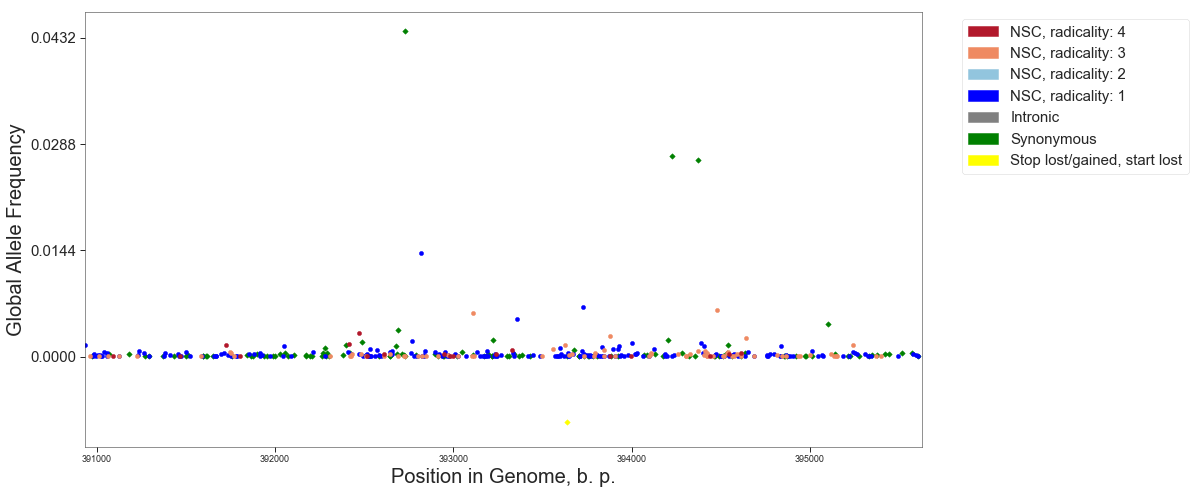

step 6 
 gene ID: PF3D7_0525100 
 start, b. p.: 1041745 
 end, b. p.: 1043766 
 gene length, b. p.: 2022 
 gene description: acyl-CoA+synthetase+%28ACS10%29 
 gene name: ACS10 
 conservation score: 3.127786033


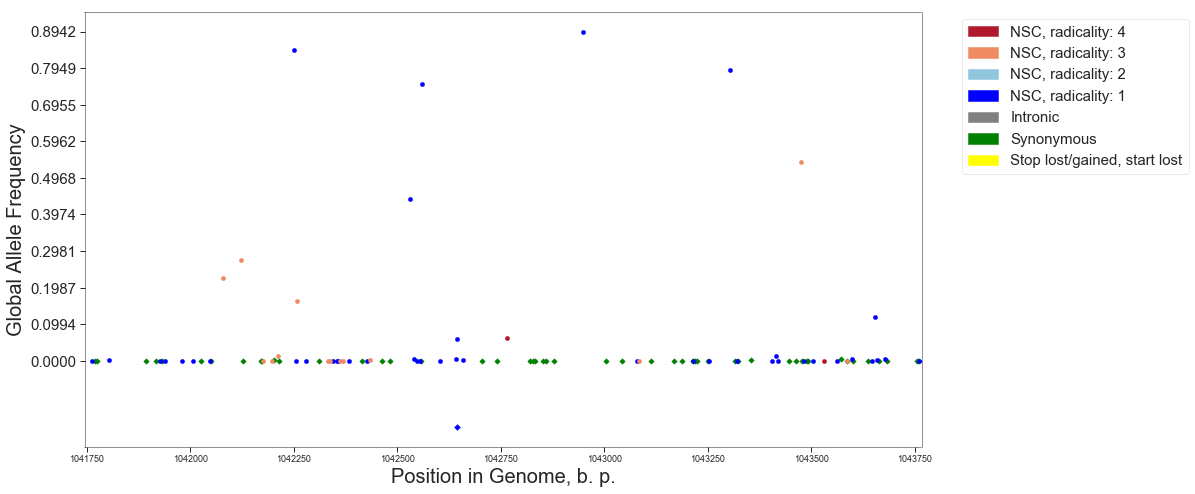

step 7 
 gene ID: PF3D7_1113300 
 start, b. p.: 519189 
 end, b. p.: 520220 
 gene length, b. p.: 1032 
 gene description: UDP-galactose+transporter%2C+putative 
 gene name: UGT 
 conservation score: 3.930029155


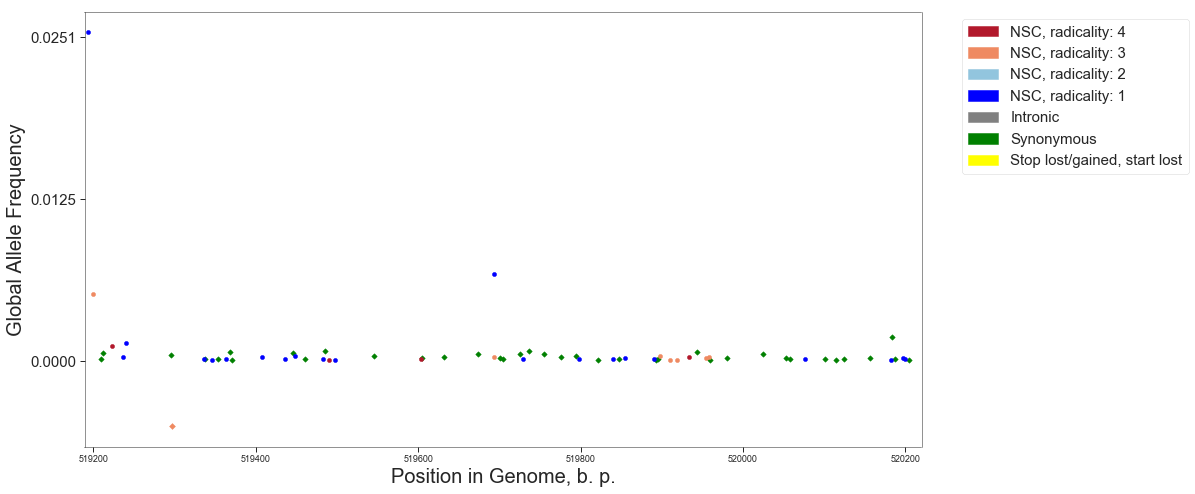

step 8 
 gene ID: PF3D7_0109800 
 start, b. p.: 380697 
 end, b. p.: 382424 
 gene length, b. p.: 1728 
 gene description: phenylalanine--tRNA+ligase%2C+putative 
 gene name: cPheRS 
 conservation score: 3.116521739


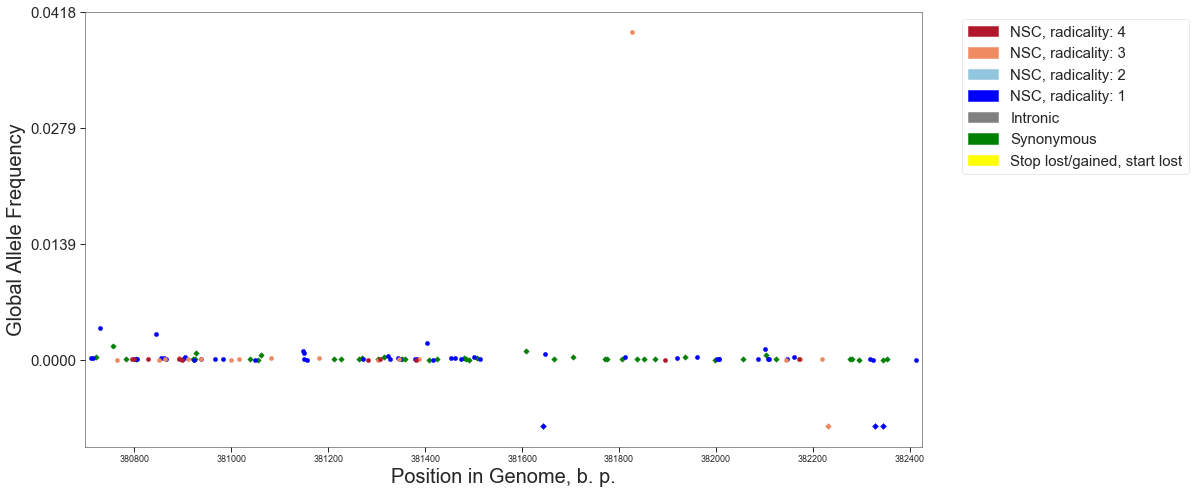

step 9 
 gene ID: PF3D7_0107500 
 start, b. p.: 304362 
 end, b. p.: 309257 
 gene length, b. p.: 4896 
 gene description: lipid%2Fsterol%3AH++symporter 
 gene name: nan 
 conservation score: 1.778911565


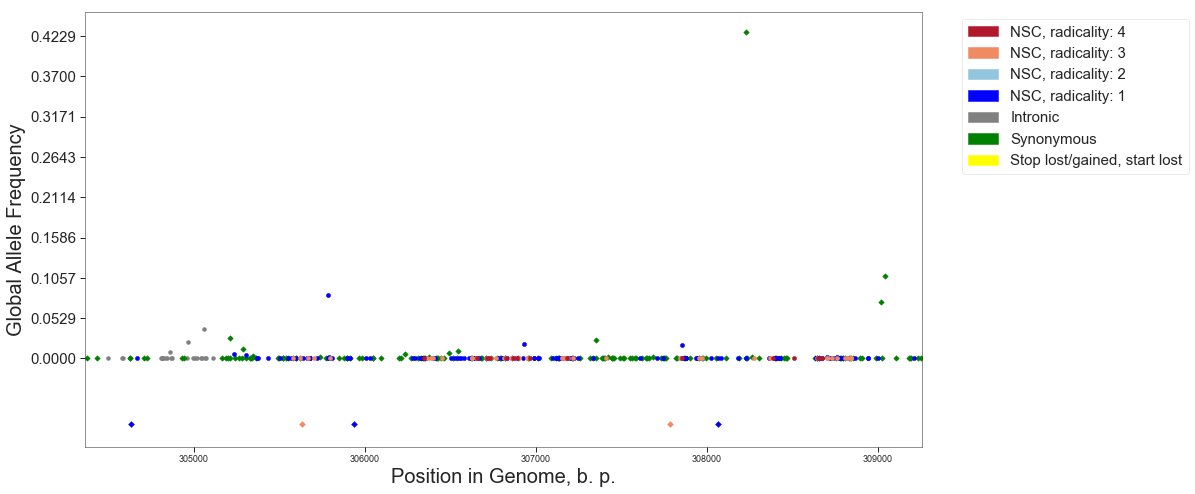

step 10 
 gene ID: PF3D7_0826100 
 start, b. p.: 1113369 
 end, b. p.: 1139144 
 gene length, b. p.: 25776 
 gene description: E3+ubiquitin-protein+ligase%2C+putative 
 gene name: nan 
 conservation score: 1.216040042


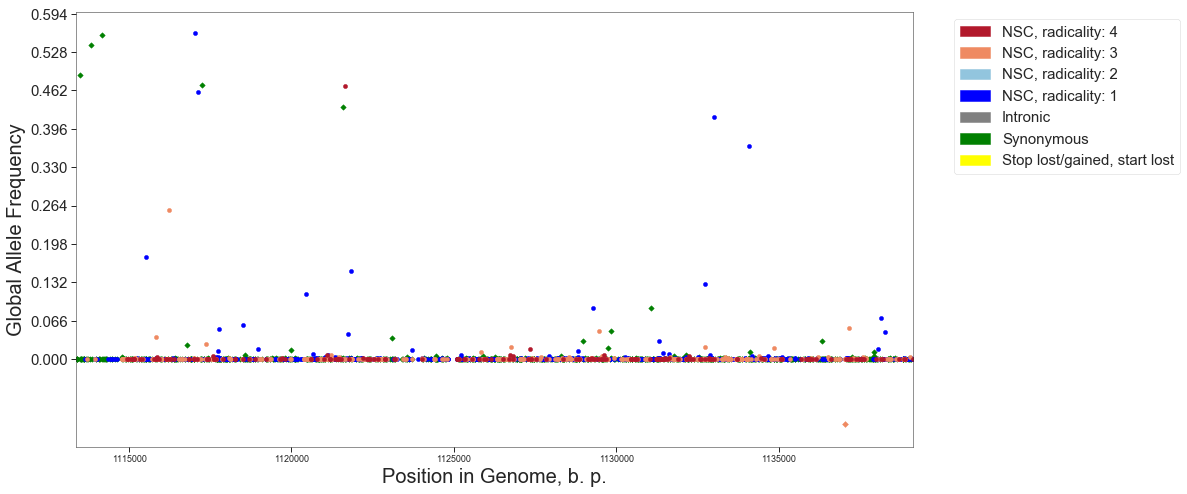

step 11 
 gene ID: PF3D7_1472100 
 start, b. p.: 2941600 
 end, b. p.: 2943259 
 gene length, b. p.: 1660 
 gene description: Yip1+protein%2C+putative 
 gene name: YIP1 
 conservation score: 2.920382166


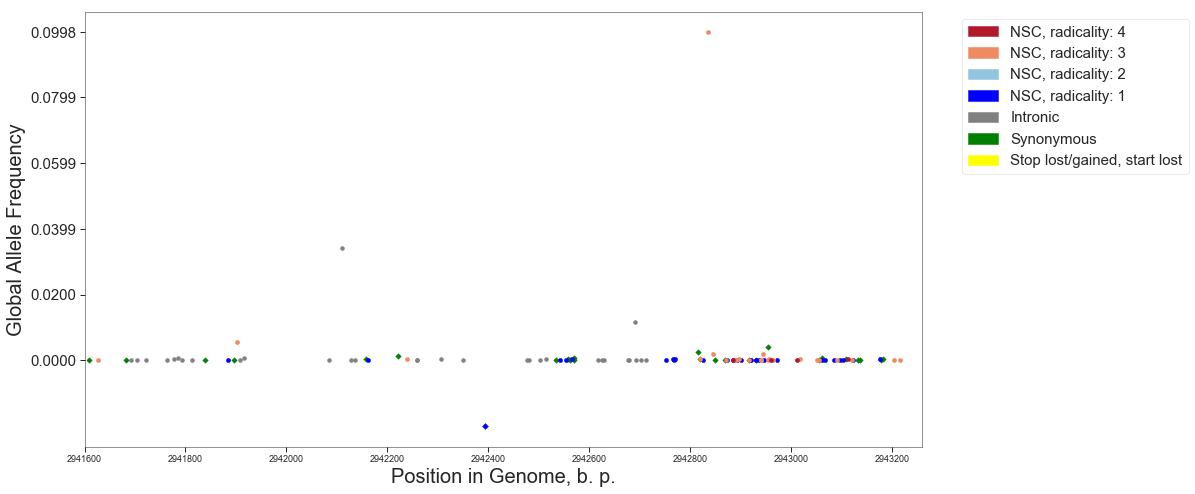

step 12 
 gene ID: PF3D7_1147500 
 start, b. p.: 1889826 
 end, b. p.: 1892597 
 gene length, b. p.: 2772 
 gene description: farnesyltransferase+beta+subunit%2C+putative 
 gene name: nan 
 conservation score: 1.616468039


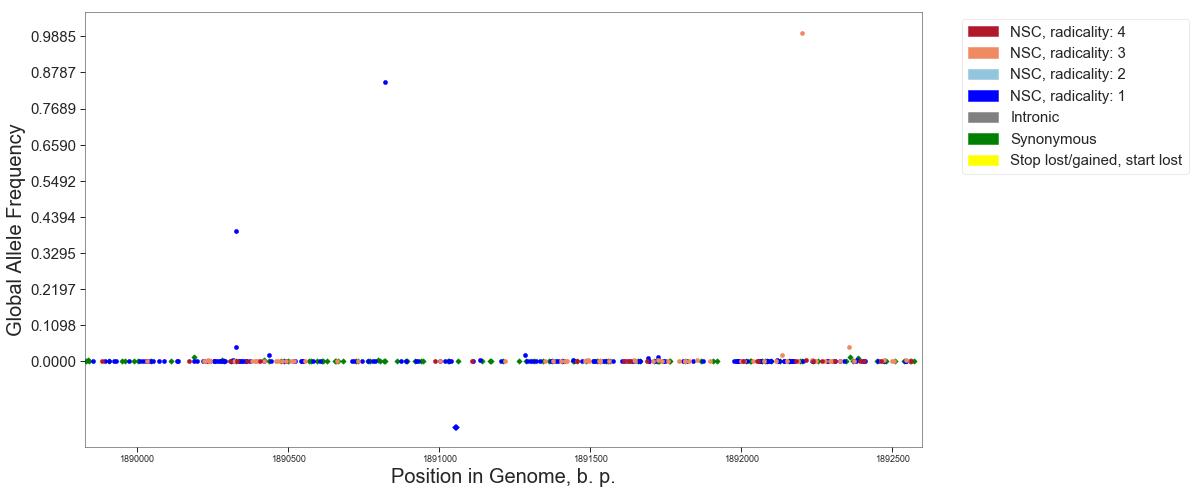

step 13 
 gene ID: PF3D7_0628200 
 start, b. p.: 1159862 
 end, b. p.: 1169080 
 gene length, b. p.: 9219 
 gene description: protein+kinase+PK4+%28PK4%29 
 gene name: PK4 
 conservation score: 0.347005208


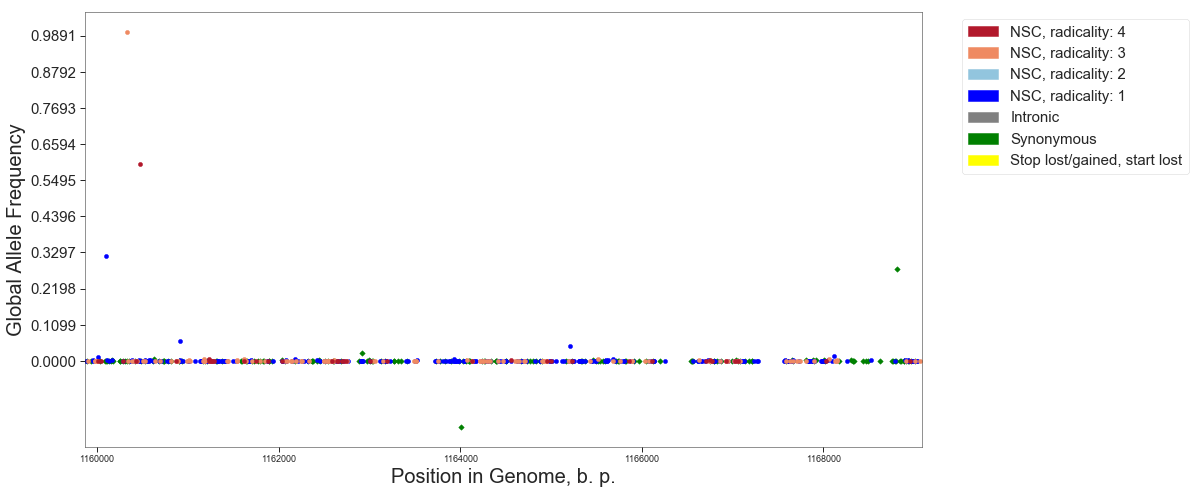

step 14 
 gene ID: PF3D7_0709700 
 start, b. p.: 435089 
 end, b. p.: 436195 
 gene length, b. p.: 1107 
 gene description: lysophospholipase%2C+putative 
 gene name: nan 
 conservation score: 2.6875


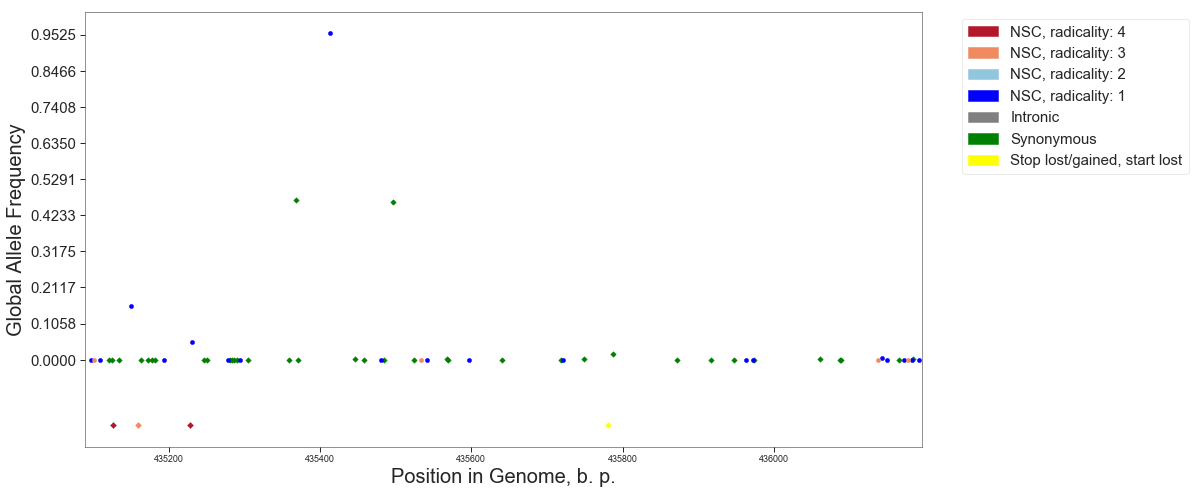

step 15 
 gene ID: PF3D7_1471200 
 start, b. p.: 2912386 
 end, b. p.: 2915354 
 gene length, b. p.: 2969 
 gene description: inorganic+anion+exchanger%2C+inorganic+anion+antiporter+%28SulP%29 
 gene name: SulP 
 conservation score: 4.037650602


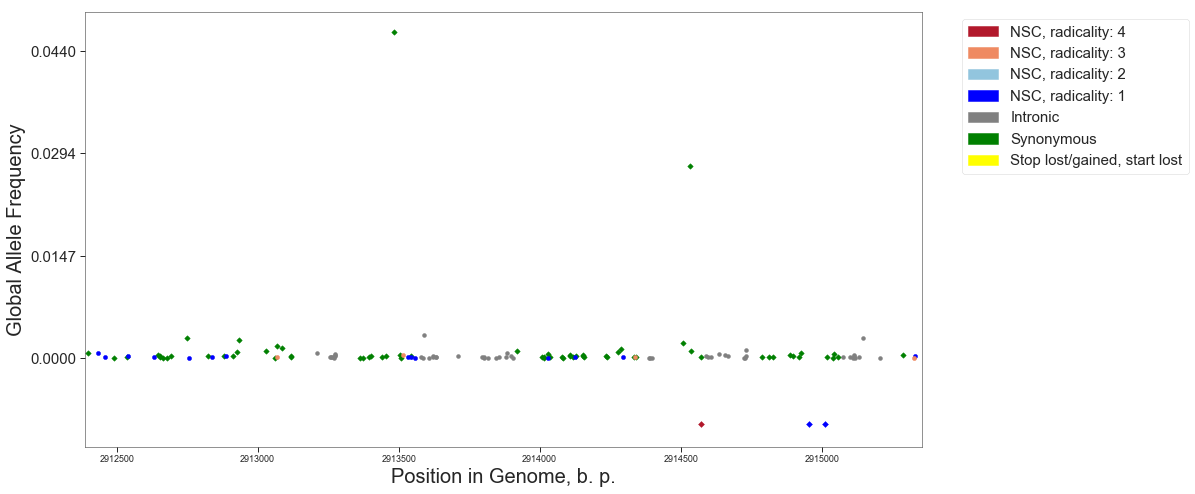

step 16 
 gene ID: PF3D7_0509800 
 start, b. p.: 410268 
 end, b. p.: 415308 
 gene length, b. p.: 5041 
 gene description: phosphatidylinositol+4-kinase 
 gene name: PI4K 
 conservation score: 1.756254009


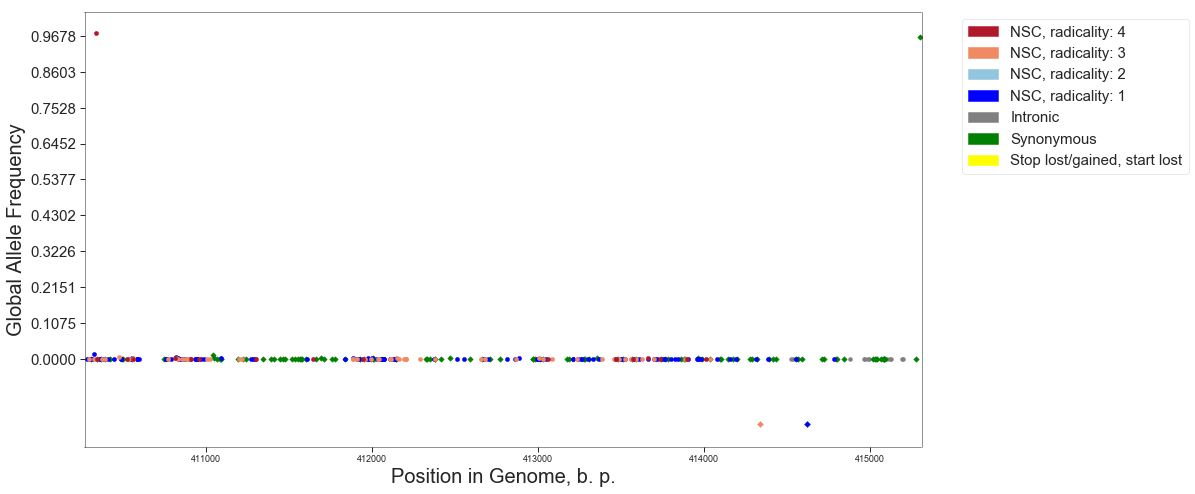

step 17 
 gene ID: PF3D7_0613800 
 start, b. p.: 566139 
 end, b. p.: 578993 
 gene length, b. p.: 12855 
 gene description: transcription+factor+with+AP2+domain%28s%29+%28ApiAP2%29 
 gene name: ApiAP2 
 conservation score: -1.505475785


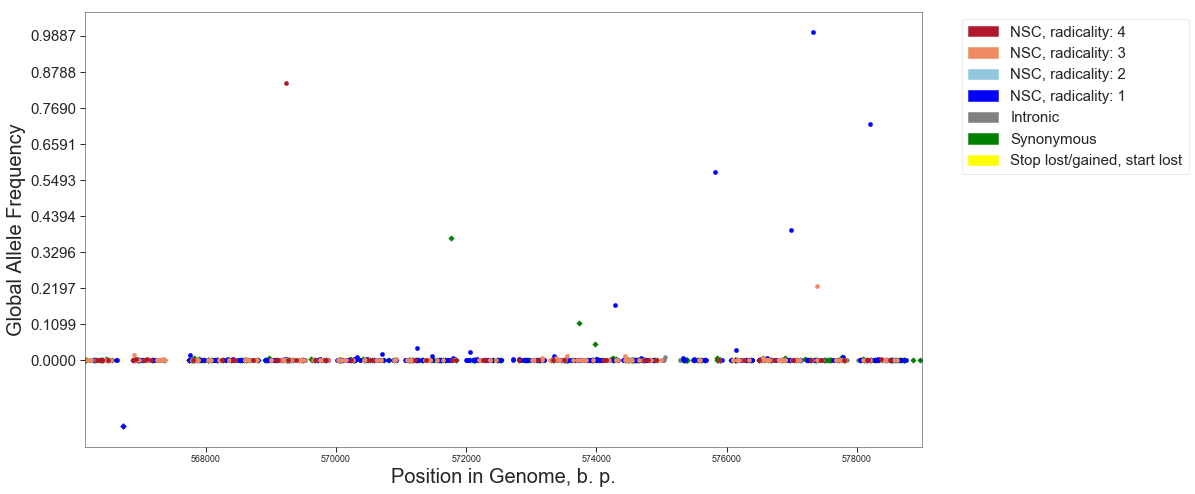

step 18 
 gene ID: PF3D7_1434000 
 start, b. p.: 1364749 
 end, b. p.: 1366113 
 gene length, b. p.: 1365 
 gene description: CCR4-associated+factor+16%2C+putative+%28CAF16%29 
 gene name: CAF16 
 conservation score: 2.918287938


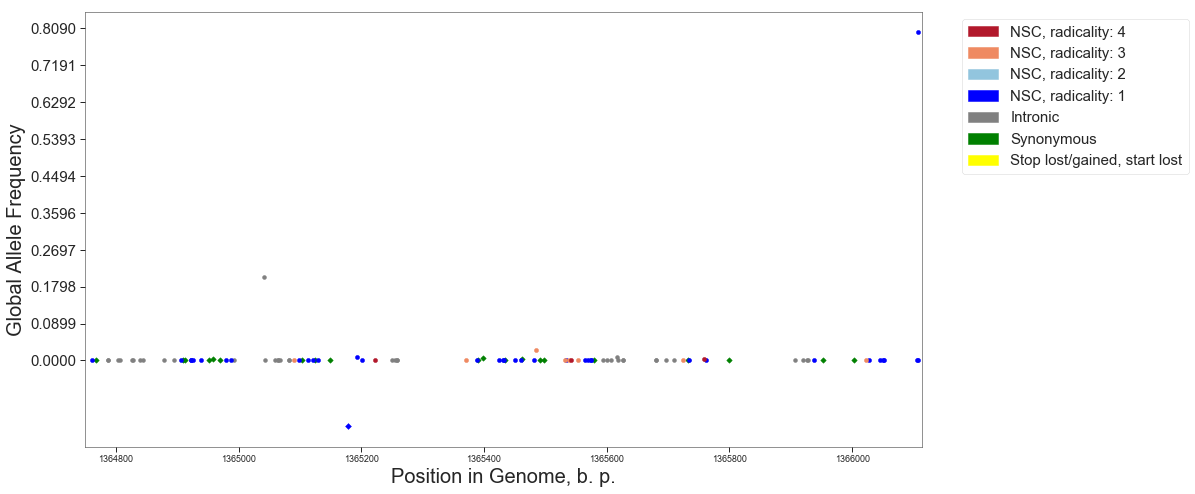

step 19 
 gene ID: PF3D7_0709000 
 start, b. p.: 403222 
 end, b. p.: 406317 
 gene length, b. p.: 3096 
 gene description: chloroquine+resistance+transporter+%28CRT%29 
 gene name: CRT 
 conservation score: 3.125


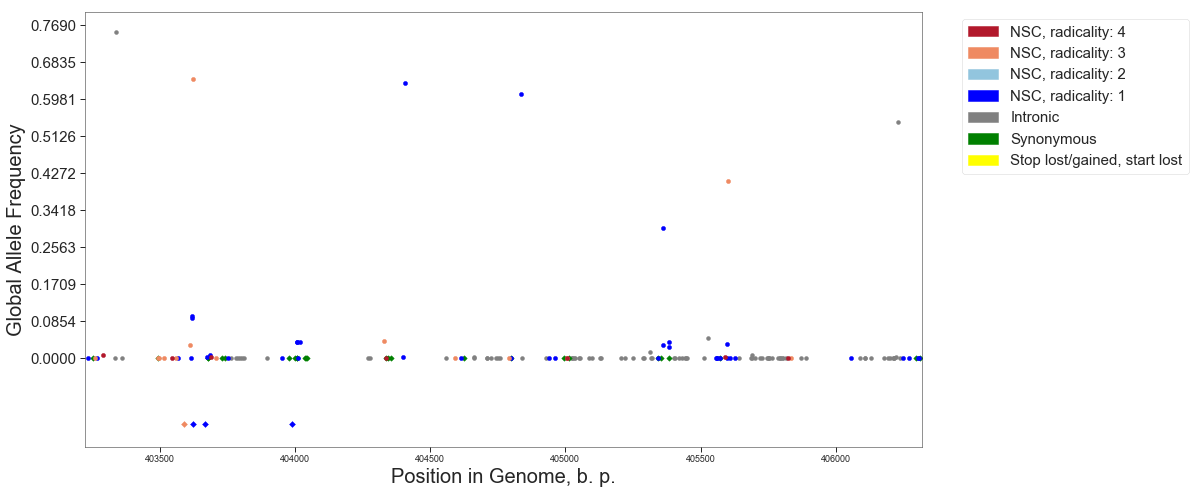

step 20 
 gene ID: PF3D7_1447900 
 start, b. p.: 1954601 
 end, b. p.: 1957675 
 gene length, b. p.: 3075 
 gene description: multidrug+resistance+protein+2+%28heavy+metal+transport+family%29+%28MDR2%29 
 gene name: MDR2 
 conservation score: 1.989257813


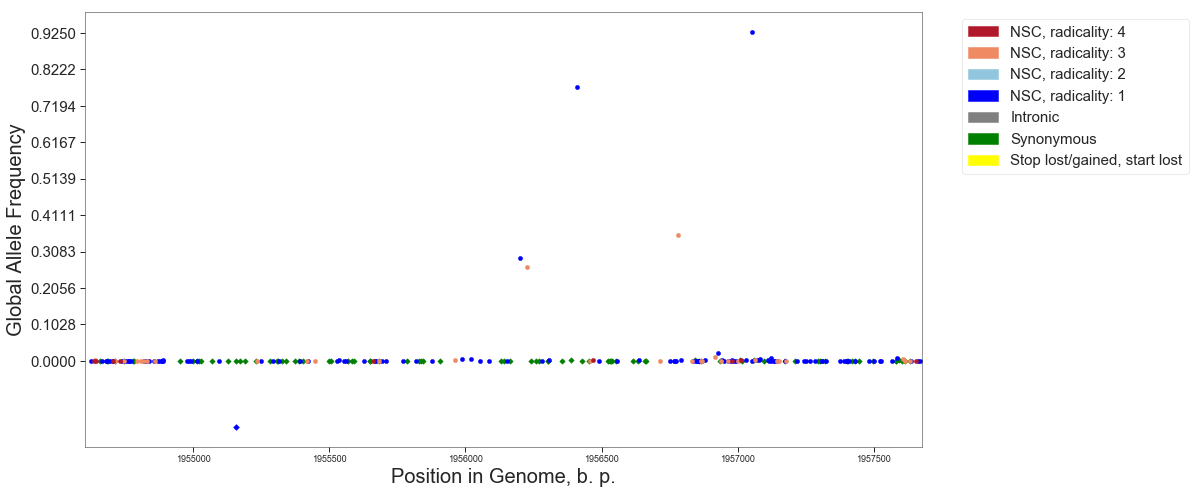

step 21 
 gene ID: PF3D7_0417200 
 start, b. p.: 748088 
 end, b. p.: 749914 
 gene length, b. p.: 1827 
 gene description: bifunctional+dihydrofolate+reductase-thymidylate+synthase+%28DHFR-TS%29 
 gene name: DHFR-TS 
 conservation score: 3.378289474


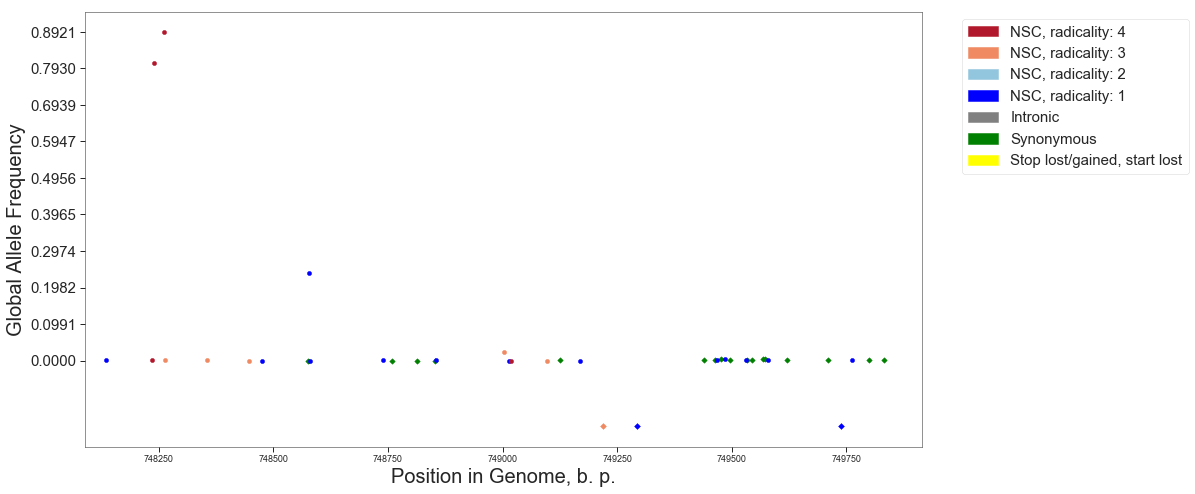

step 22 
 gene ID: PF3D7_0321900 
 start, b. p.: 922974 
 end, b. p.: 927942 
 gene length, b. p.: 4969 
 gene description: cyclic+amine+resistance+locus+protein+%28CARL%29 
 gene name: CARL 
 conservation score: 0.980514419


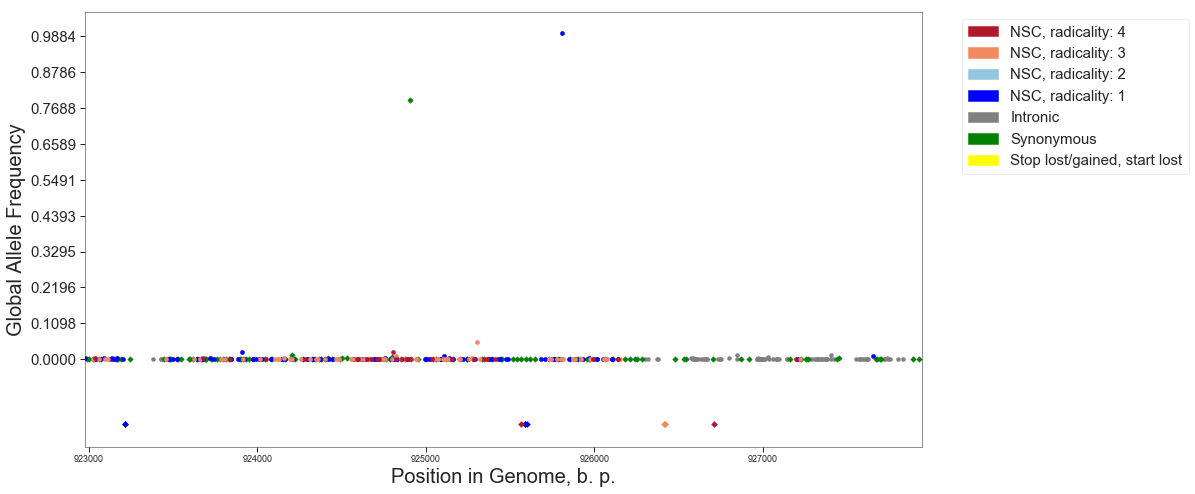

step 23 
 gene ID: PF3D7_0523000 
 start, b. p.: 957890 
 end, b. p.: 962149 
 gene length, b. p.: 4260 
 gene description: multidrug+resistance+protein+%28MDR1%29 
 gene name: MDR1 
 conservation score: 3.286116984


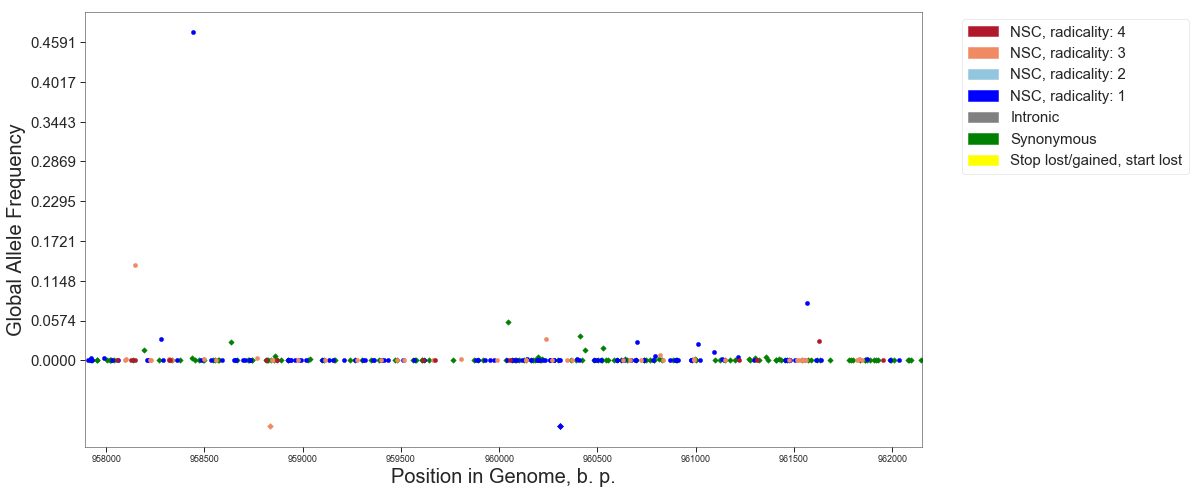

step 24 
 gene ID: PF3D7_0319700 
 start, b. p.: 820708 
 end, b. p.: 830802 
 gene length, b. p.: 10095 
 gene description: ABC+transporter%2C+putative 
 gene name: ABCI3 
 conservation score: 1.090647941


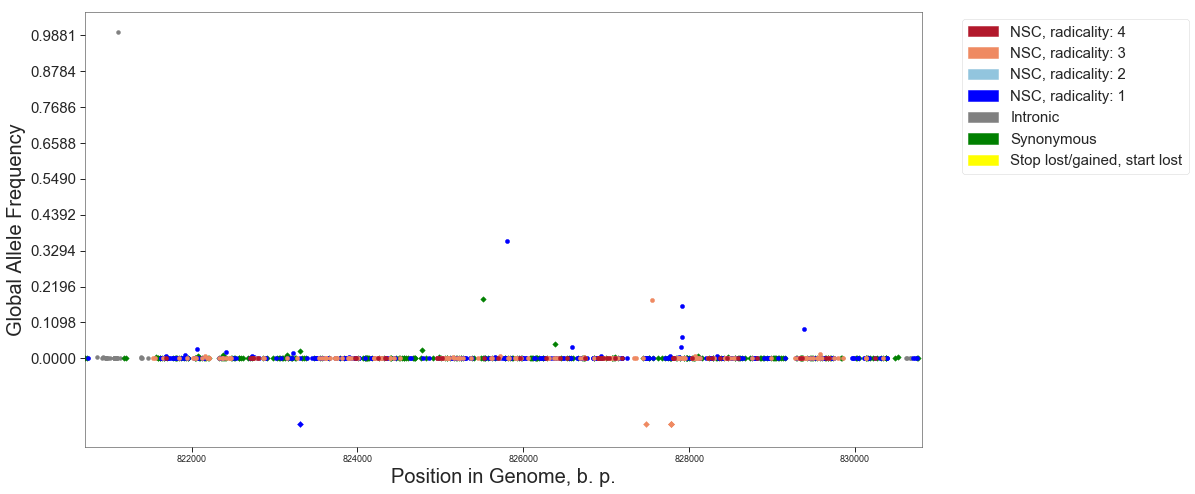

step 25 
 gene ID: PF3D7_1241700 
 start, b. p.: 1778154 
 end, b. p.: 1779411 
 gene length, b. p.: 1258 
 gene description: replication+factor+C+subunit+4%2C+putative 
 gene name: RFC4 
 conservation score: 4.520833333


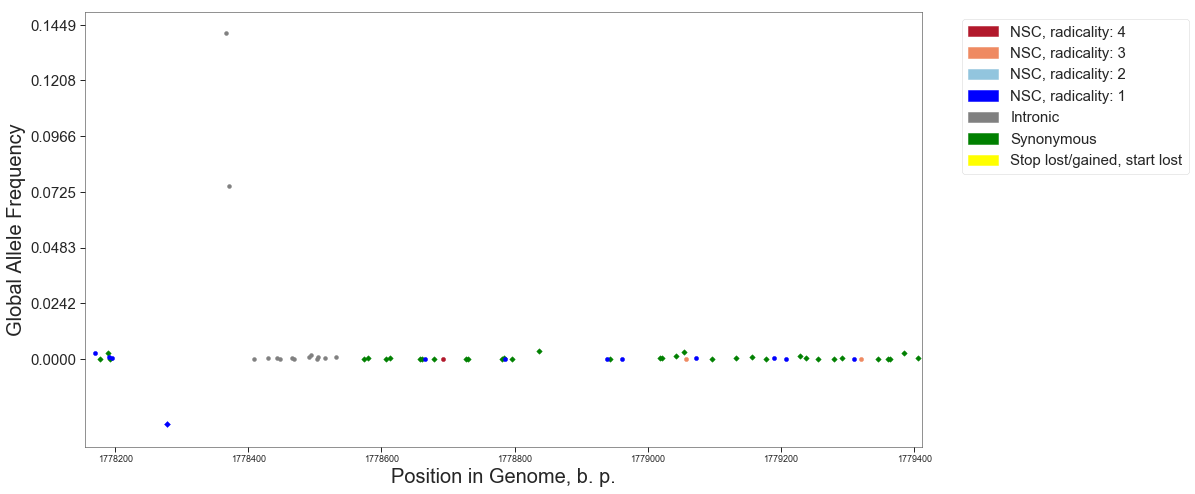

step 26 
 gene ID: PF3D7_1116700 
 start, b. p.: 630779 
 end, b. p.: 632881 
 gene length, b. p.: 2103 
 gene description: cathepsin+C%2C+homolog%2Cdipeptidyl+peptidase+1+%28DPAP1%29 
 gene name: DPAP1 
 conservation score: 2.475714286


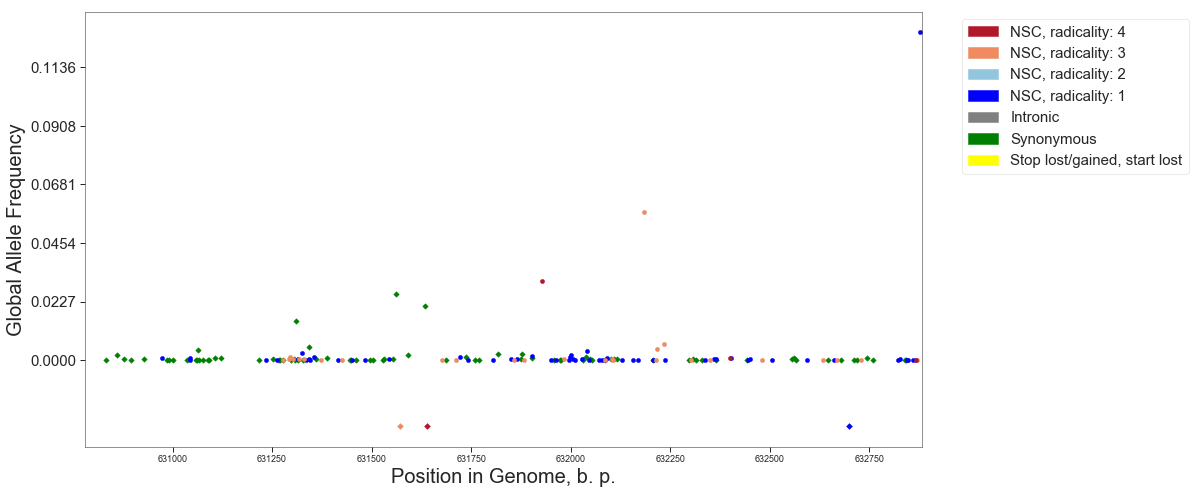

step 27 
 gene ID: PF3D7_0629500 
 start, b. p.: 1213948 
 end, b. p.: 1216005 
 gene length, b. p.: 2058 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: nan


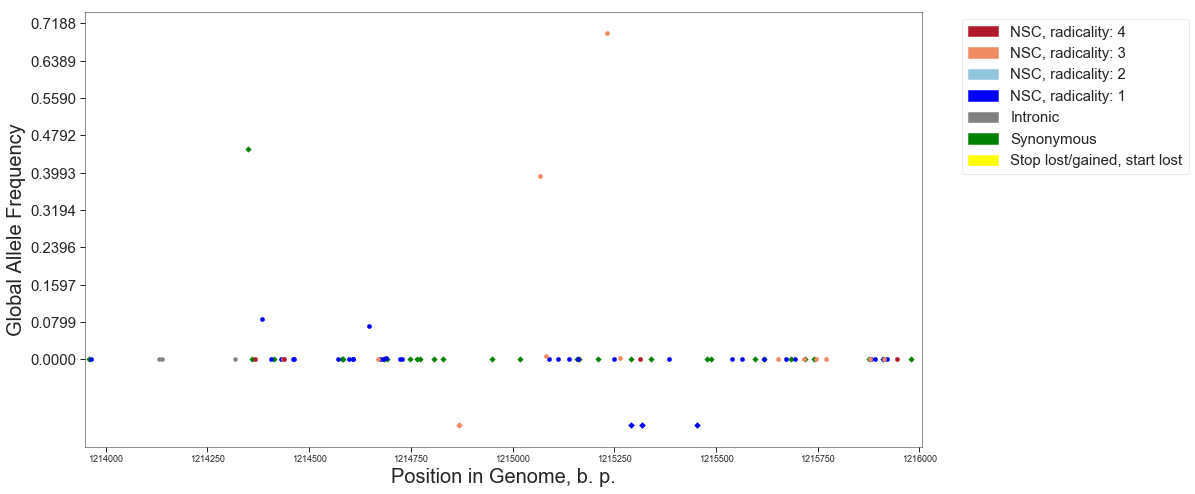

step 28 
 gene ID: PF3D7_1229100 
 start, b. p.: 1192888 
 end, b. p.: 1199214 
 gene length, b. p.: 6327 
 gene description: ABC+transporter%2C+%28CT+family%29+%28MRP2%29 
 gene name: MRP2 
 conservation score: nan


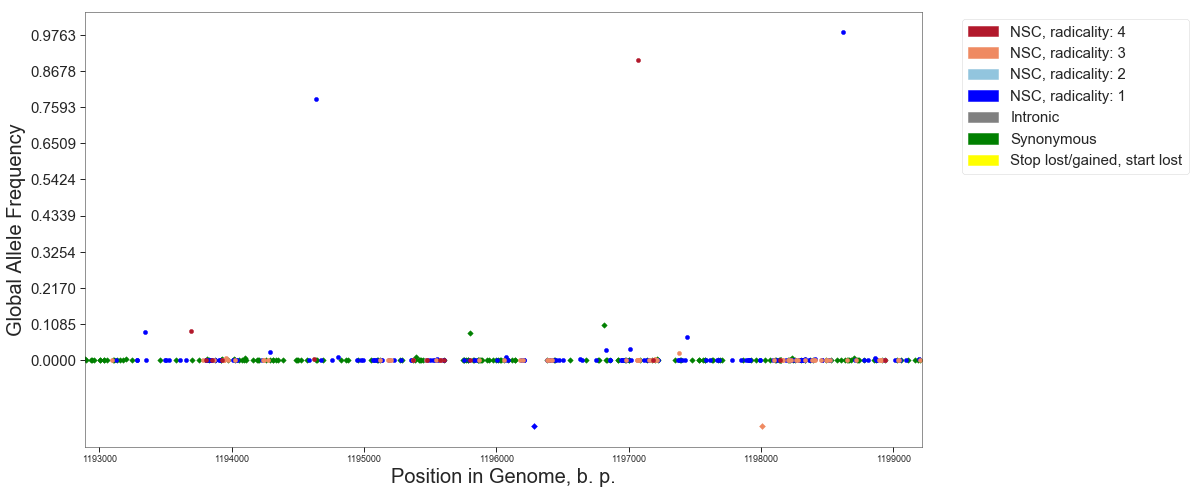

step 29 
 gene ID: PF3D7_0909700 
 start, b. p.: 440914 
 end, b. p.: 444024 
 gene length, b. p.: 3111 
 gene description: FHA+domain+protein%2C+putative 
 gene name: nan 
 conservation score: 1.005791506


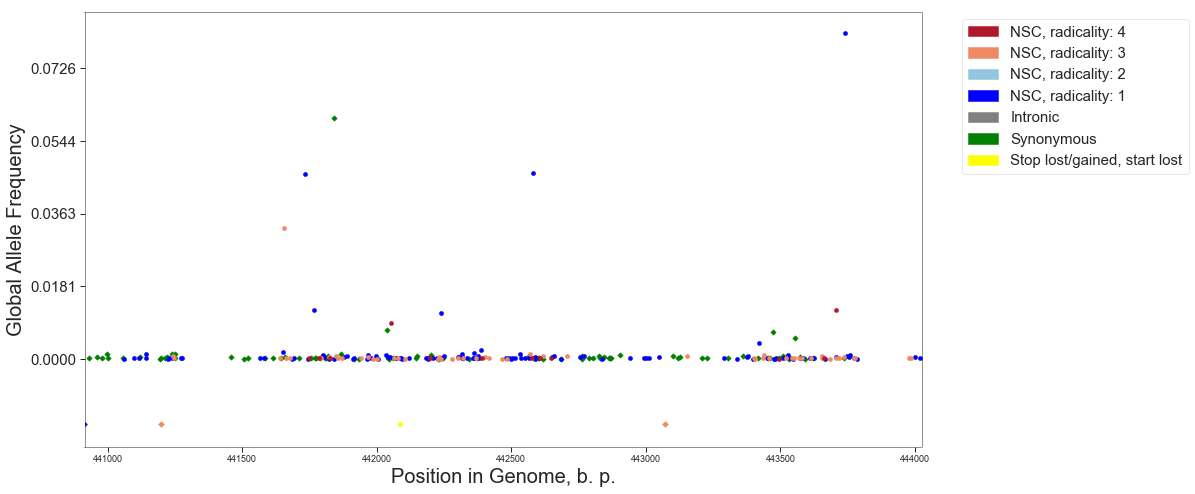

step 30 
 gene ID: PF3D7_1036800 
 start, b. p.: 1448692 
 end, b. p.: 1451646 
 gene length, b. p.: 2955 
 gene description: acetyl-CoA+transporter%2C+putative 
 gene name: ACT 
 conservation score: 2.766101695


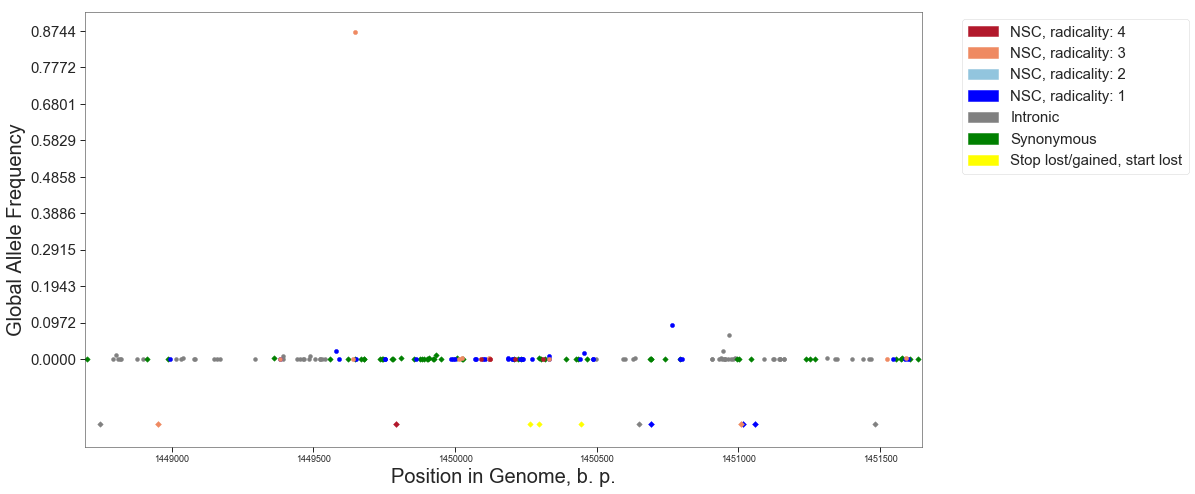

step 31 
 gene ID: PF3D7_1238800 
 start, b. p.: 1610363 
 end, b. p.: 1612741 
 gene length, b. p.: 2379 
 gene description: acyl-CoA+synthetase+%28ACS11%29 
 gene name: ACS11 
 conservation score: 2.640151515


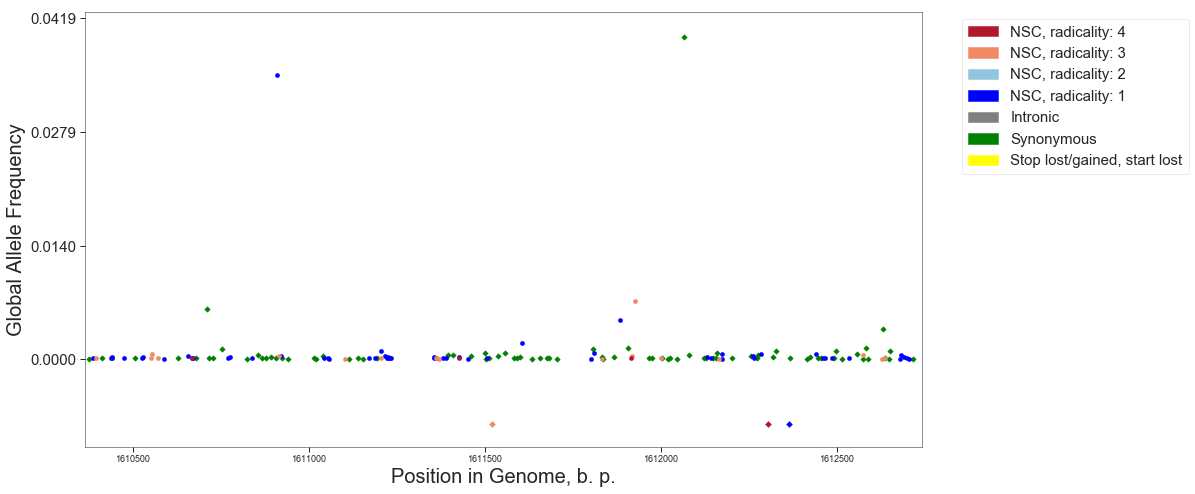

In [66]:
plotting_advanced(gene_picks_CT, df_Pf6_variants, df_cand_transp,score_metric='CCF')

step 1 
 gene ID: PF3D7_0321900 
 start, b. p.: 922974 
 end, b. p.: 927942 
 gene length, b. p.: 4969 
 gene description: cyclic+amine+resistance+locus+protein+%28CARL%29 
 gene name: CARL 
 conservation score: 0.980514419


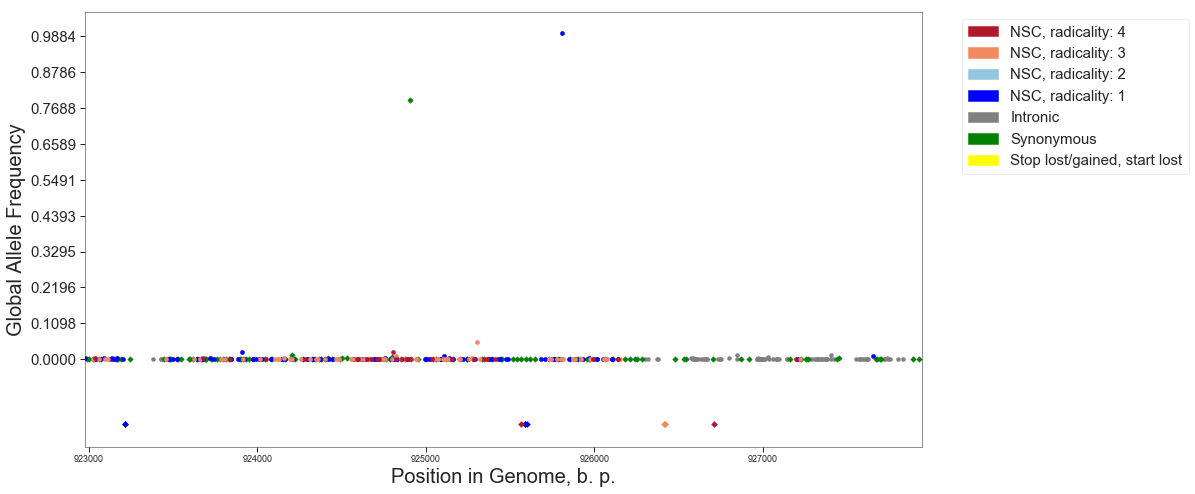

step 2 
 gene ID: PF3D7_0109800 
 start, b. p.: 380697 
 end, b. p.: 382424 
 gene length, b. p.: 1728 
 gene description: phenylalanine--tRNA+ligase%2C+putative 
 gene name: cPheRS 
 conservation score: 3.116521739


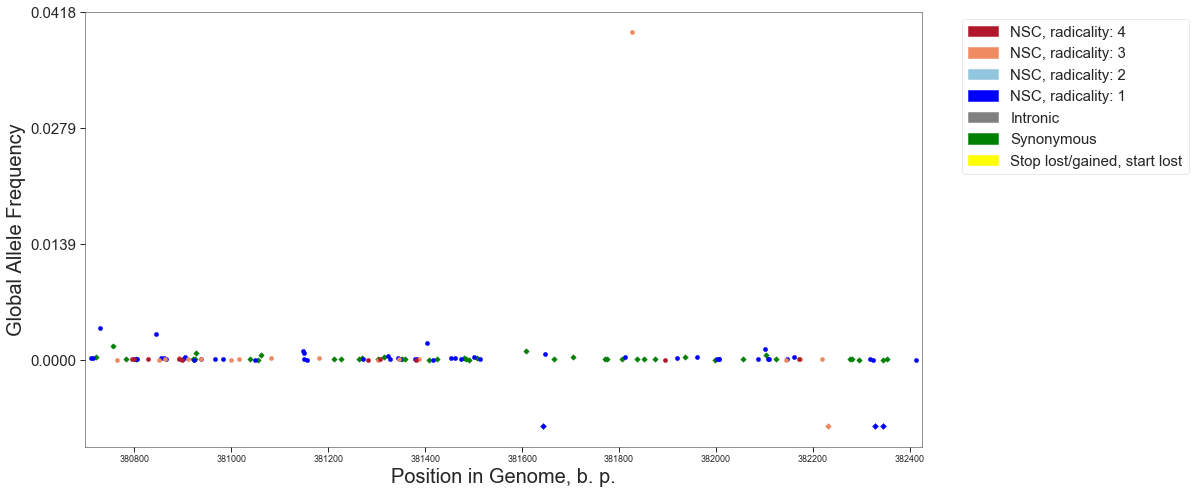

step 3 
 gene ID: PF3D7_1447900 
 start, b. p.: 1954601 
 end, b. p.: 1957675 
 gene length, b. p.: 3075 
 gene description: multidrug+resistance+protein+2+%28heavy+metal+transport+family%29+%28MDR2%29 
 gene name: MDR2 
 conservation score: 1.989257813


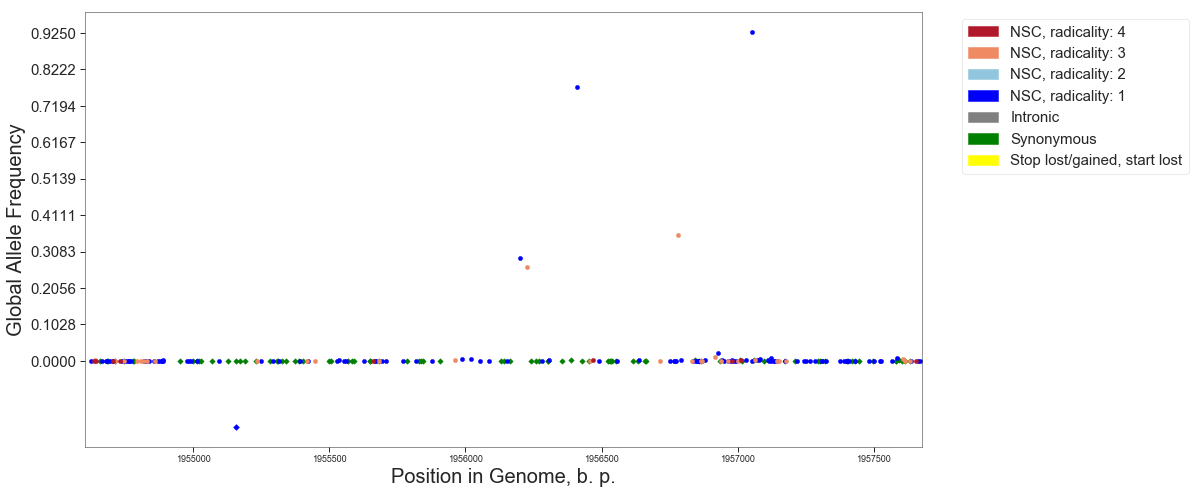

step 4 
 gene ID: PF3D7_1414700 
 start, b. p.: 592992 
 end, b. p.: 597146 
 gene length, b. p.: 4155 
 gene description: ubiquitin+carboxyl-terminal+hydrolase%2C+putative 
 gene name: nan 
 conservation score: 0.582369942


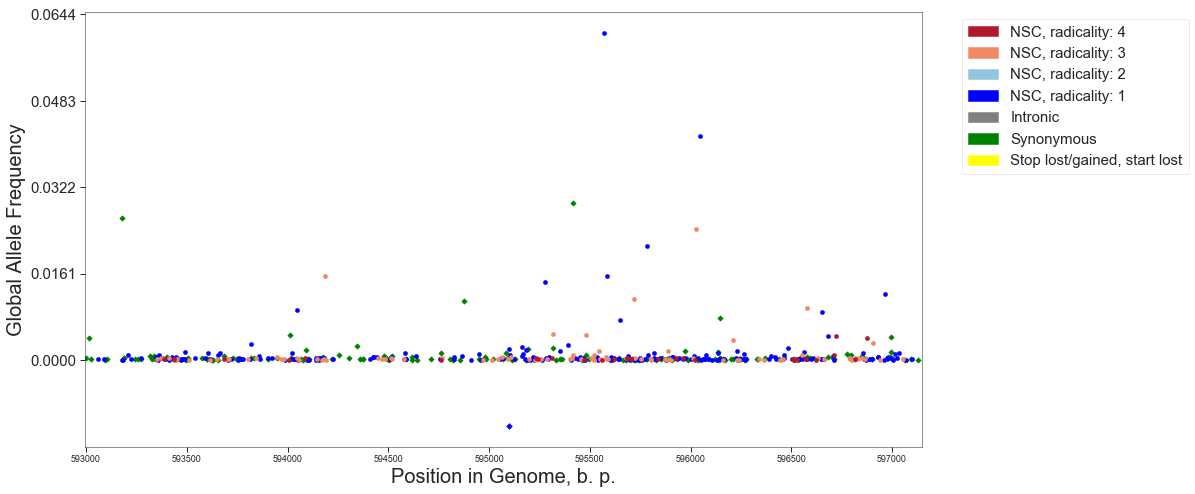

step 5 
 gene ID: PF3D7_1211900 
 start, b. p.: 529005 
 end, b. p.: 532799 
 gene length, b. p.: 3795 
 gene description: non-SERCA-type+Ca2++-transporting+P-ATPase+%28ATP4%29 
 gene name: ATP4 
 conservation score: 3.592563291


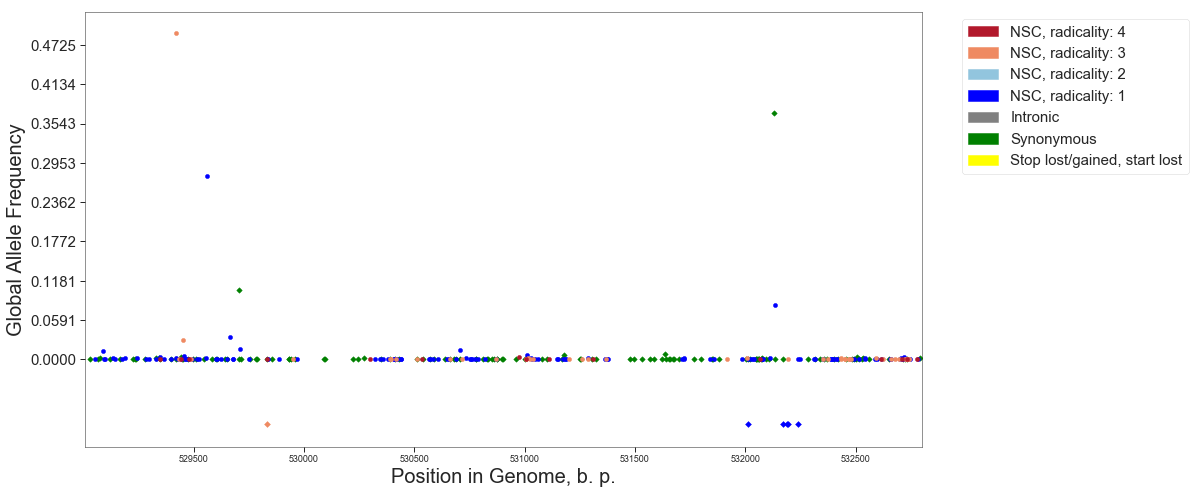

step 6 
 gene ID: PF3D7_0826100 
 start, b. p.: 1113369 
 end, b. p.: 1139144 
 gene length, b. p.: 25776 
 gene description: E3+ubiquitin-protein+ligase%2C+putative 
 gene name: nan 
 conservation score: 1.216040042


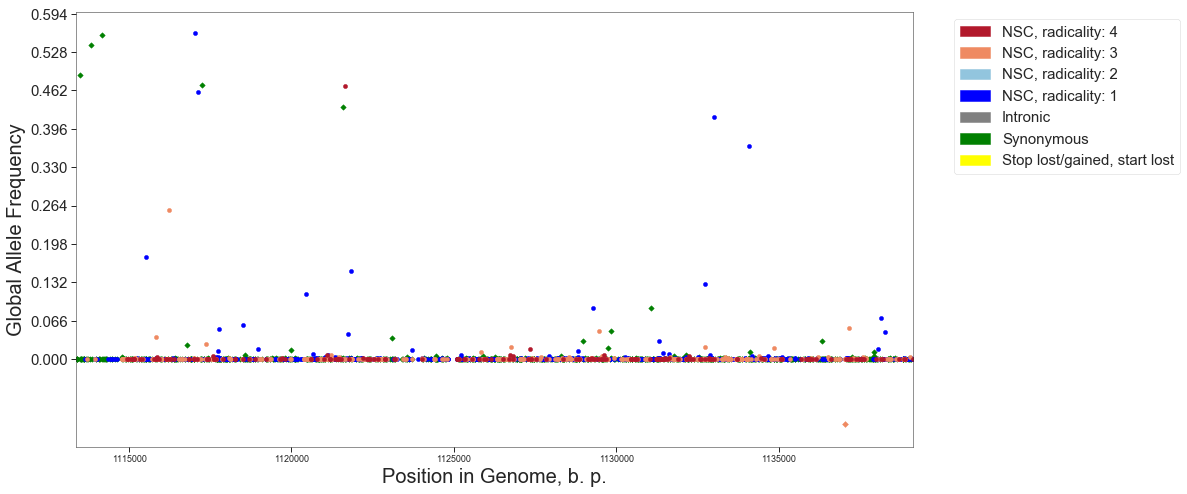

step 7 
 gene ID: PF3D7_0628200 
 start, b. p.: 1159862 
 end, b. p.: 1169080 
 gene length, b. p.: 9219 
 gene description: protein+kinase+PK4+%28PK4%29 
 gene name: PK4 
 conservation score: 0.347005208


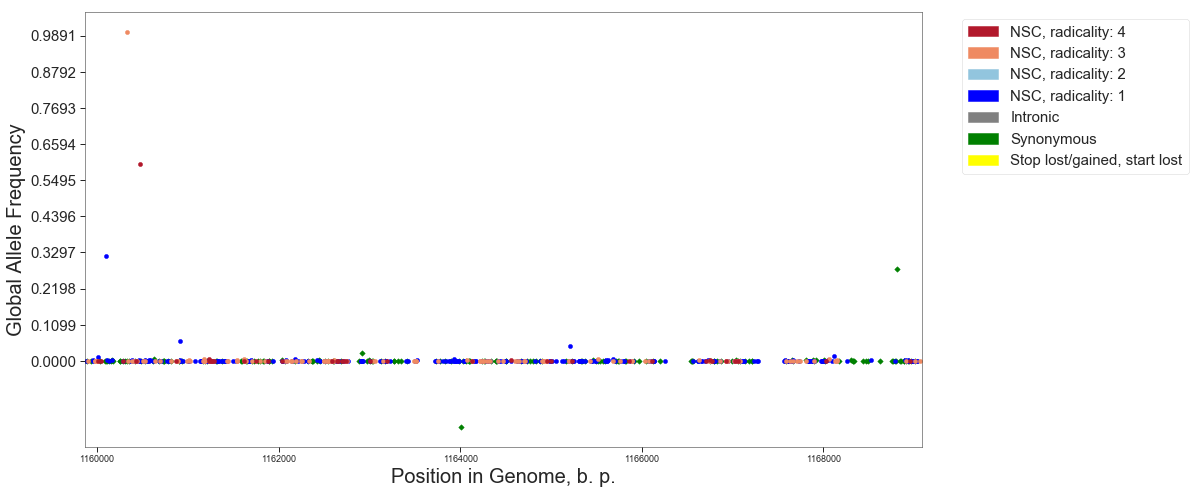

step 8 
 gene ID: PF3D7_1472100 
 start, b. p.: 2941600 
 end, b. p.: 2943259 
 gene length, b. p.: 1660 
 gene description: Yip1+protein%2C+putative 
 gene name: YIP1 
 conservation score: 2.920382166


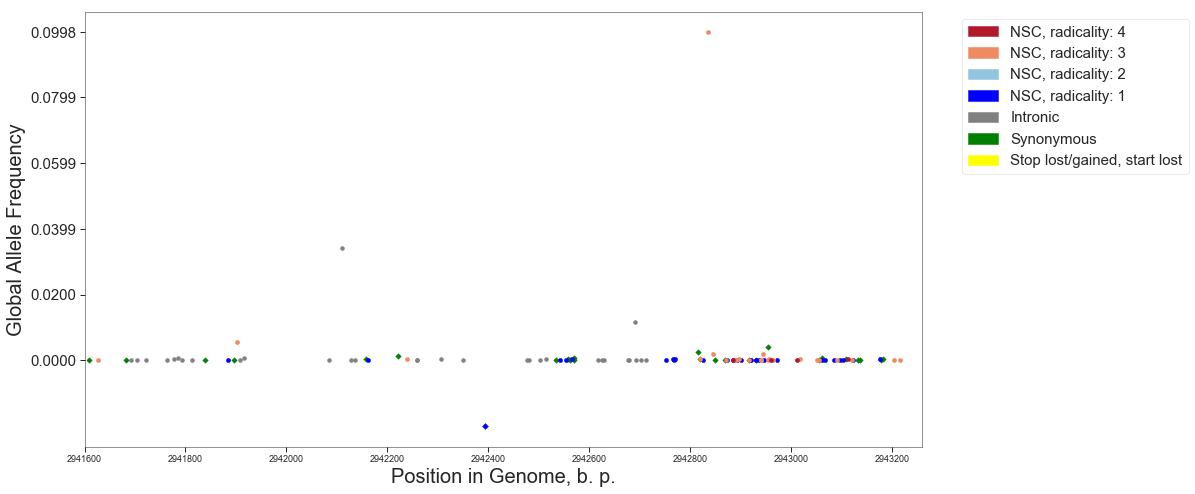

step 9 
 gene ID: PF3D7_0525100 
 start, b. p.: 1041745 
 end, b. p.: 1043766 
 gene length, b. p.: 2022 
 gene description: acyl-CoA+synthetase+%28ACS10%29 
 gene name: ACS10 
 conservation score: 3.127786033


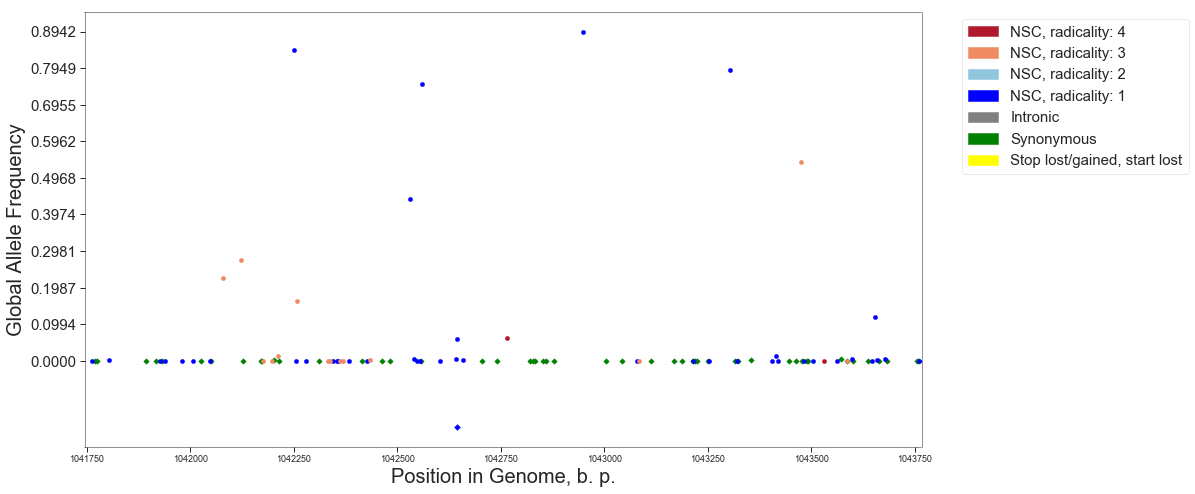

step 10 
 gene ID: PF3D7_1229100 
 start, b. p.: 1192888 
 end, b. p.: 1199214 
 gene length, b. p.: 6327 
 gene description: ABC+transporter%2C+%28CT+family%29+%28MRP2%29 
 gene name: MRP2 
 conservation score: nan


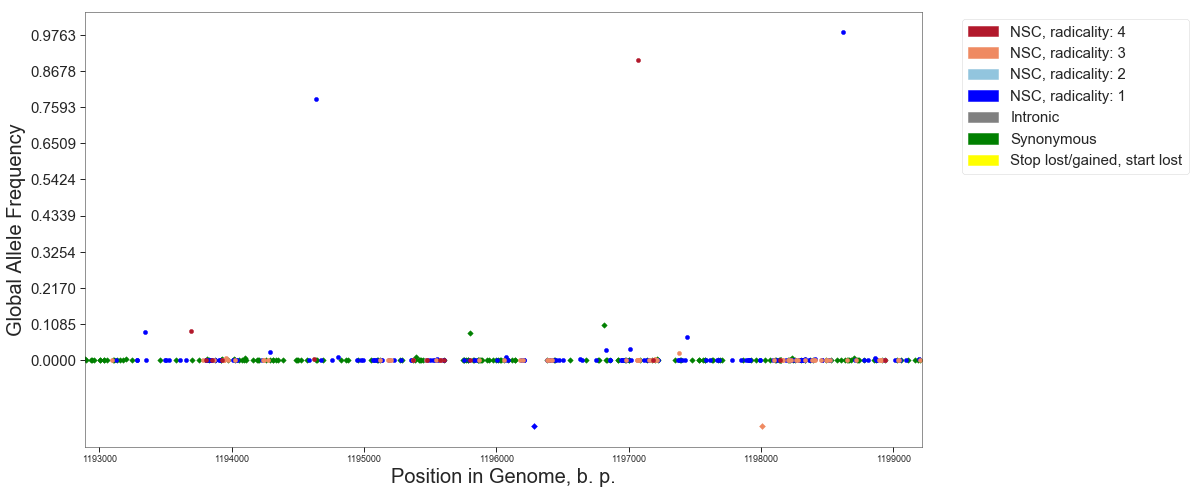

step 11 
 gene ID: PF3D7_1113300 
 start, b. p.: 519189 
 end, b. p.: 520220 
 gene length, b. p.: 1032 
 gene description: UDP-galactose+transporter%2C+putative 
 gene name: UGT 
 conservation score: 3.930029155


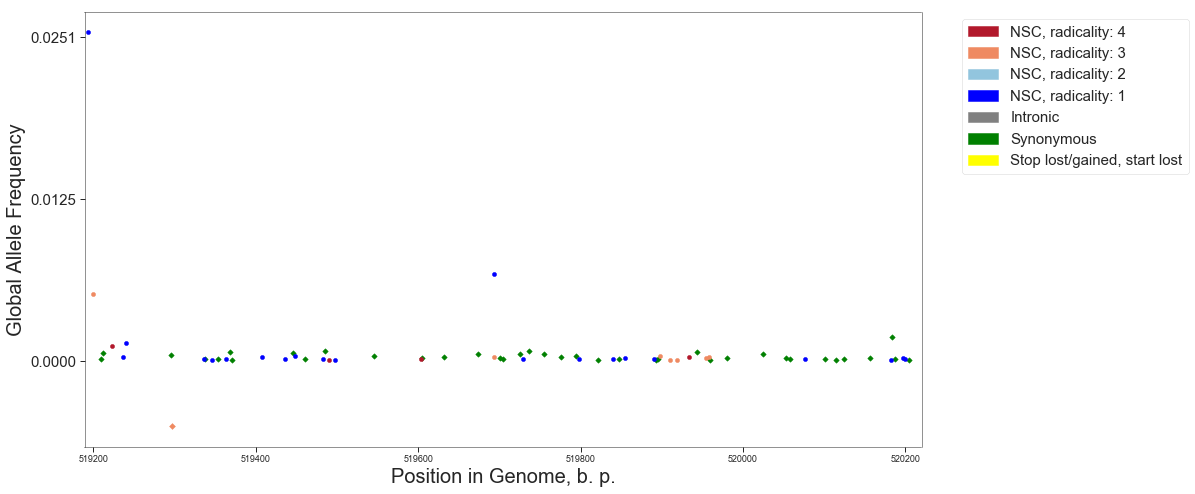

step 12 
 gene ID: PF3D7_0523000 
 start, b. p.: 957890 
 end, b. p.: 962149 
 gene length, b. p.: 4260 
 gene description: multidrug+resistance+protein+%28MDR1%29 
 gene name: MDR1 
 conservation score: 3.286116984


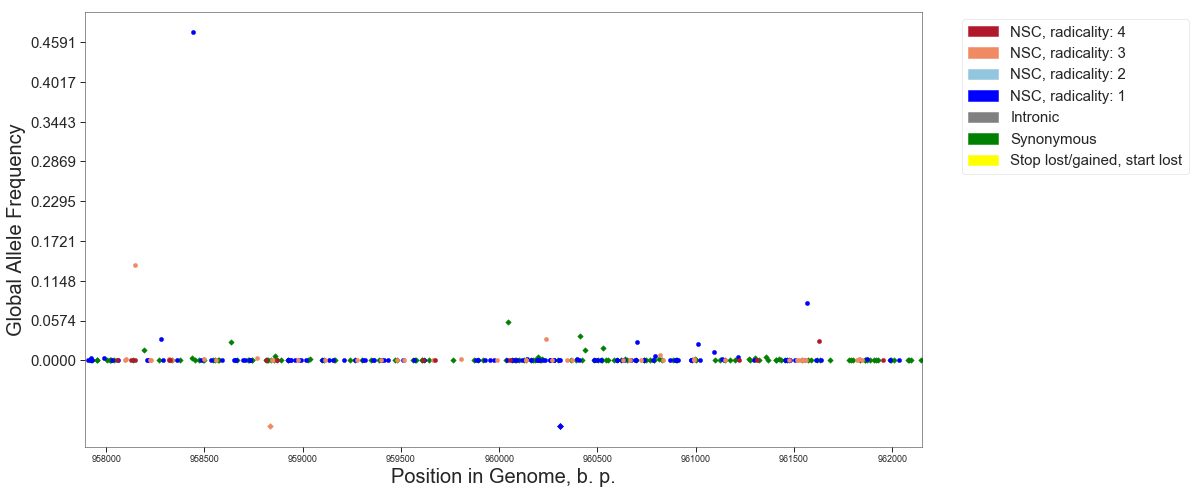

step 13 
 gene ID: PF3D7_1238800 
 start, b. p.: 1610363 
 end, b. p.: 1612741 
 gene length, b. p.: 2379 
 gene description: acyl-CoA+synthetase+%28ACS11%29 
 gene name: ACS11 
 conservation score: 2.640151515


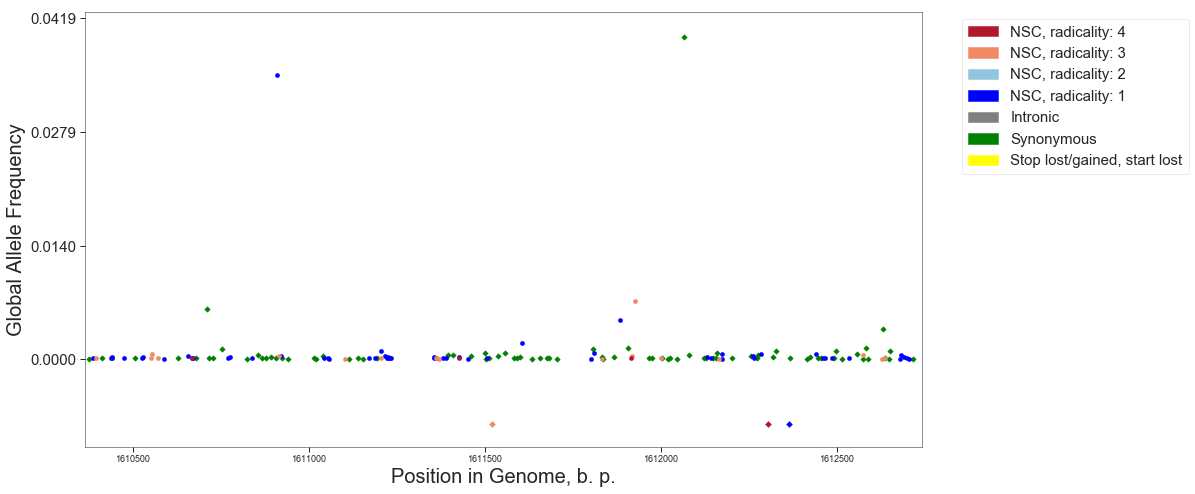

step 14 
 gene ID: PF3D7_0909700 
 start, b. p.: 440914 
 end, b. p.: 444024 
 gene length, b. p.: 3111 
 gene description: FHA+domain+protein%2C+putative 
 gene name: nan 
 conservation score: 1.005791506


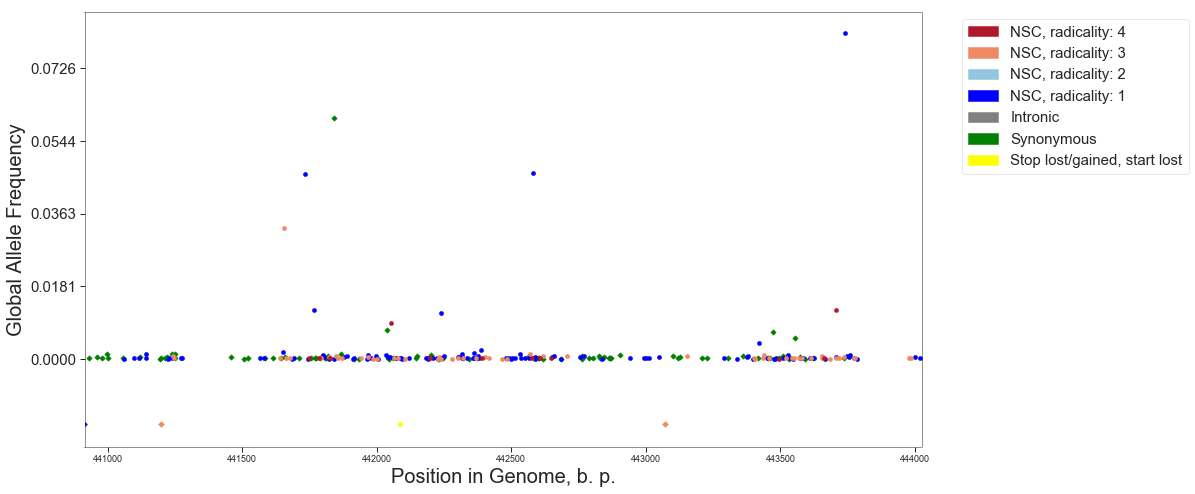

step 15 
 gene ID: PF3D7_1116700 
 start, b. p.: 630779 
 end, b. p.: 632881 
 gene length, b. p.: 2103 
 gene description: cathepsin+C%2C+homolog%2Cdipeptidyl+peptidase+1+%28DPAP1%29 
 gene name: DPAP1 
 conservation score: 2.475714286


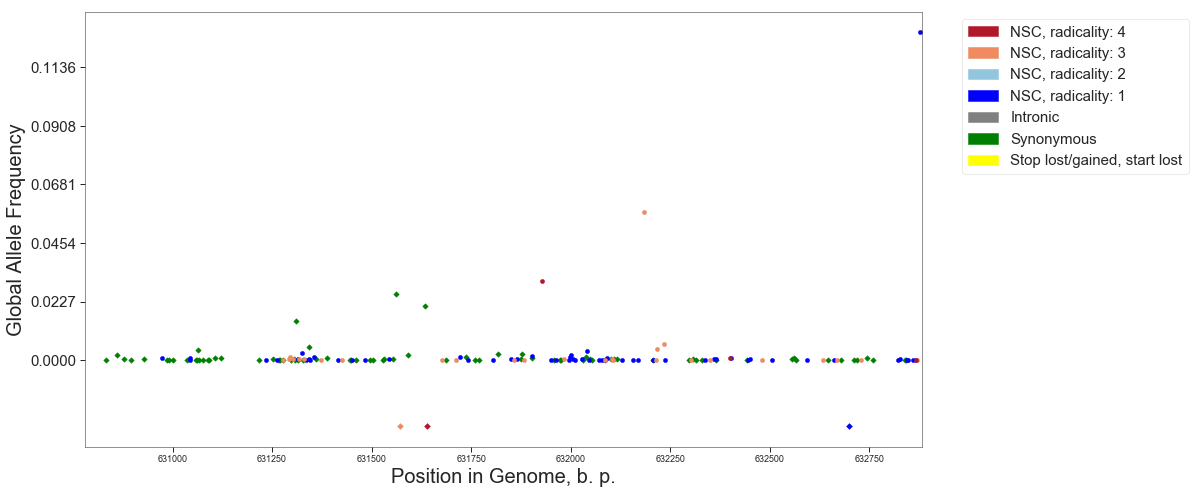

step 16 
 gene ID: PF3D7_0613800 
 start, b. p.: 566139 
 end, b. p.: 578993 
 gene length, b. p.: 12855 
 gene description: transcription+factor+with+AP2+domain%28s%29+%28ApiAP2%29 
 gene name: ApiAP2 
 conservation score: -1.505475785


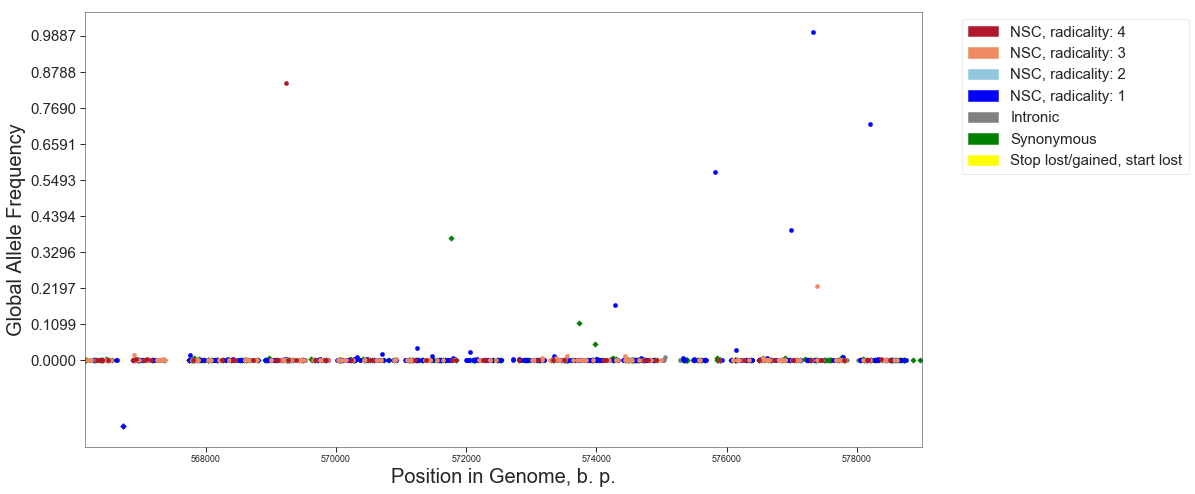

step 17 
 gene ID: PF3D7_1241700 
 start, b. p.: 1778154 
 end, b. p.: 1779411 
 gene length, b. p.: 1258 
 gene description: replication+factor+C+subunit+4%2C+putative 
 gene name: RFC4 
 conservation score: 4.520833333


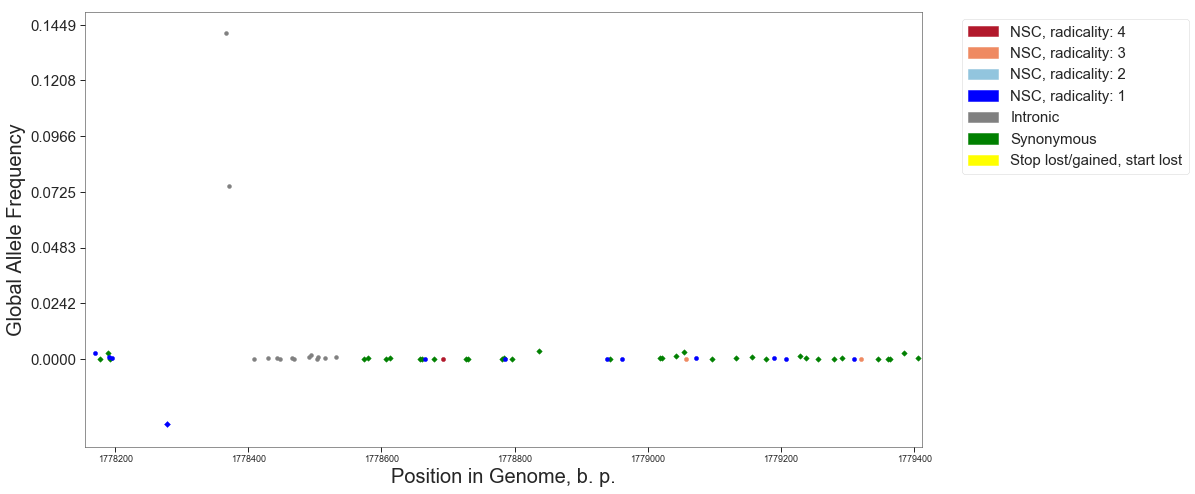

step 18 
 gene ID: PF3D7_1471200 
 start, b. p.: 2912386 
 end, b. p.: 2915354 
 gene length, b. p.: 2969 
 gene description: inorganic+anion+exchanger%2C+inorganic+anion+antiporter+%28SulP%29 
 gene name: SulP 
 conservation score: 4.037650602


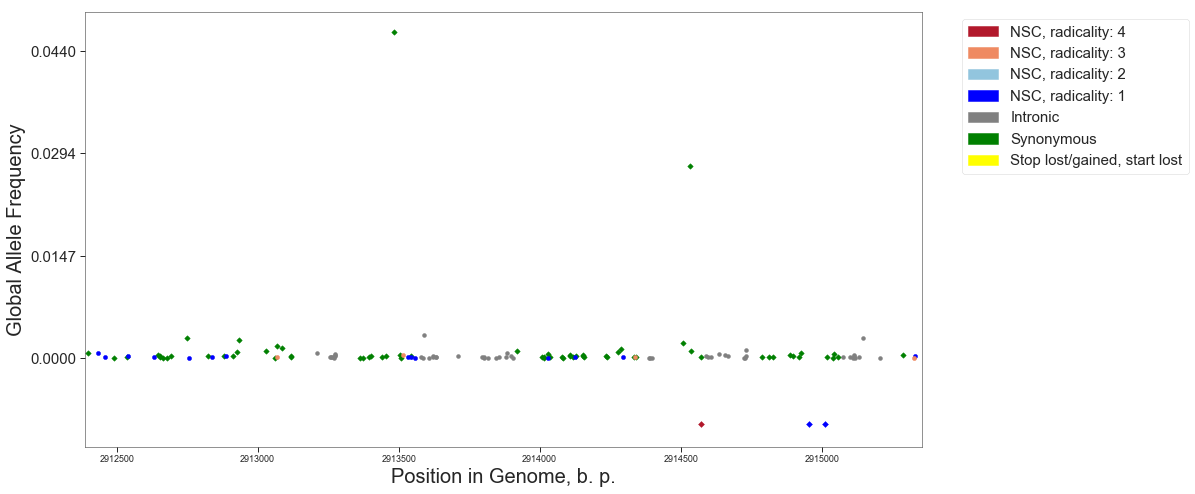

step 19 
 gene ID: PF3D7_0709000 
 start, b. p.: 403222 
 end, b. p.: 406317 
 gene length, b. p.: 3096 
 gene description: chloroquine+resistance+transporter+%28CRT%29 
 gene name: CRT 
 conservation score: 3.125


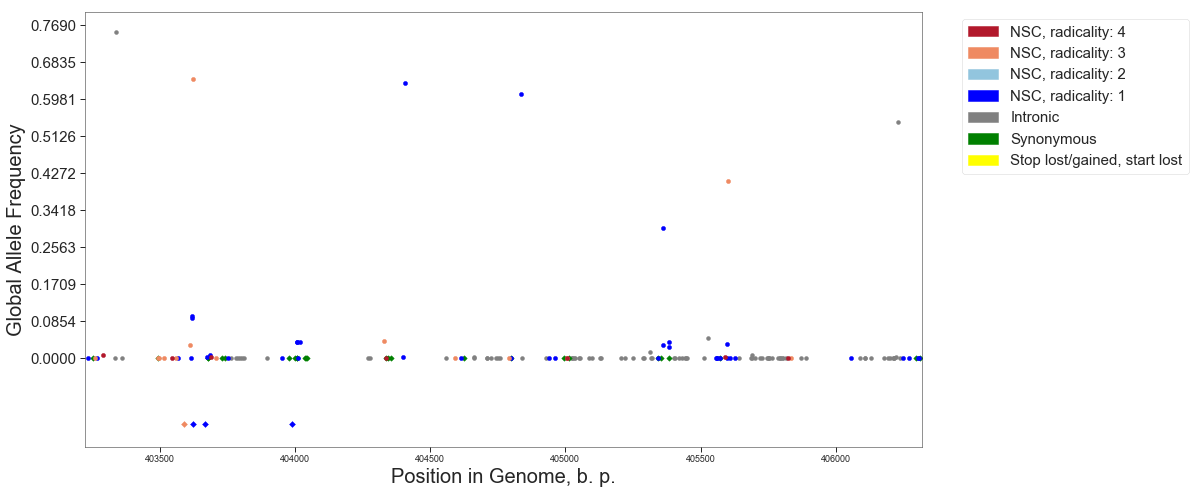

step 20 
 gene ID: PF3D7_0709700 
 start, b. p.: 435089 
 end, b. p.: 436195 
 gene length, b. p.: 1107 
 gene description: lysophospholipase%2C+putative 
 gene name: nan 
 conservation score: 2.6875


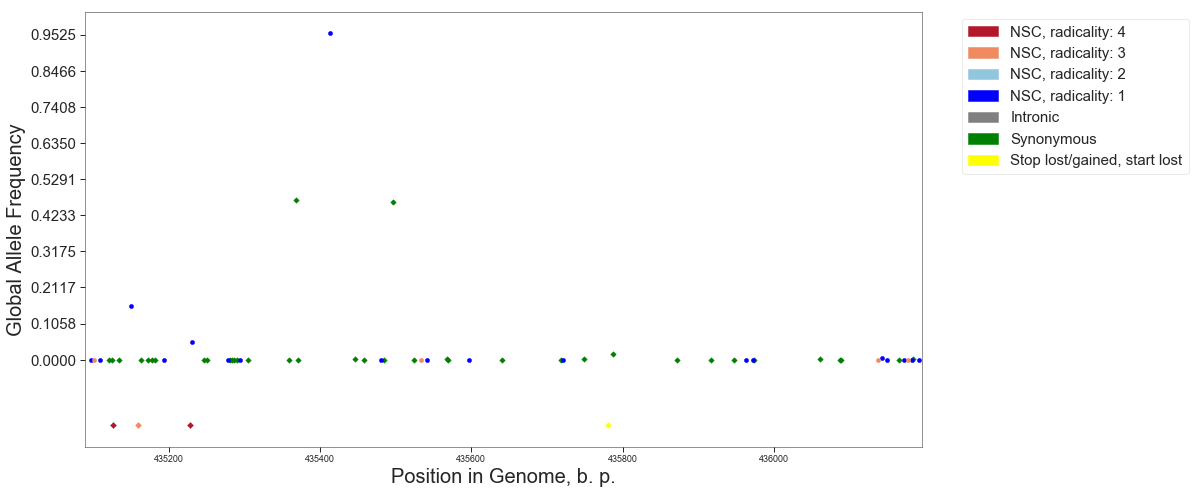

step 21 
 gene ID: PF3D7_0509800 
 start, b. p.: 410268 
 end, b. p.: 415308 
 gene length, b. p.: 5041 
 gene description: phosphatidylinositol+4-kinase 
 gene name: PI4K 
 conservation score: 1.756254009


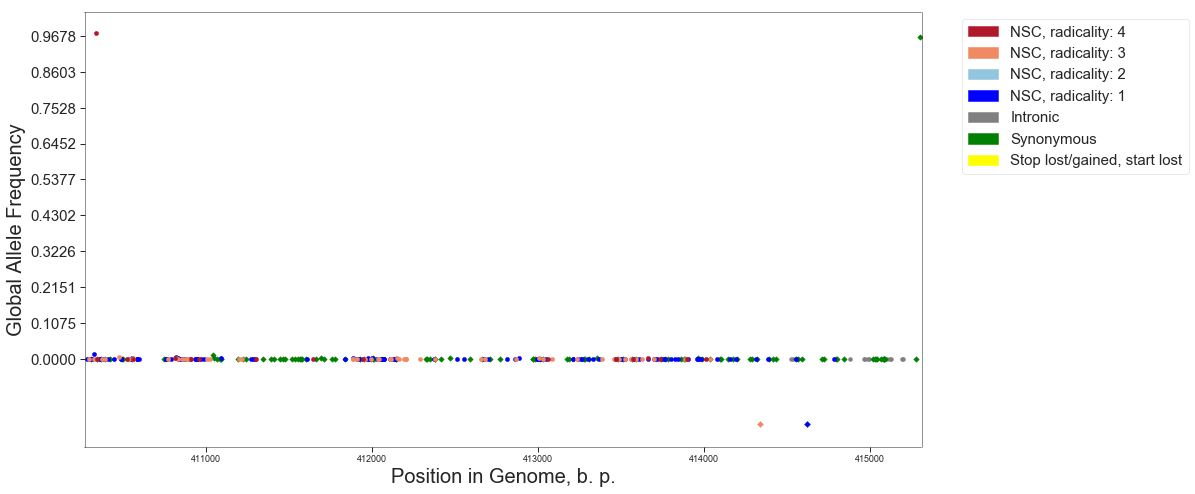

step 22 
 gene ID: PF3D7_0107500 
 start, b. p.: 304362 
 end, b. p.: 309257 
 gene length, b. p.: 4896 
 gene description: lipid%2Fsterol%3AH++symporter 
 gene name: nan 
 conservation score: 1.778911565


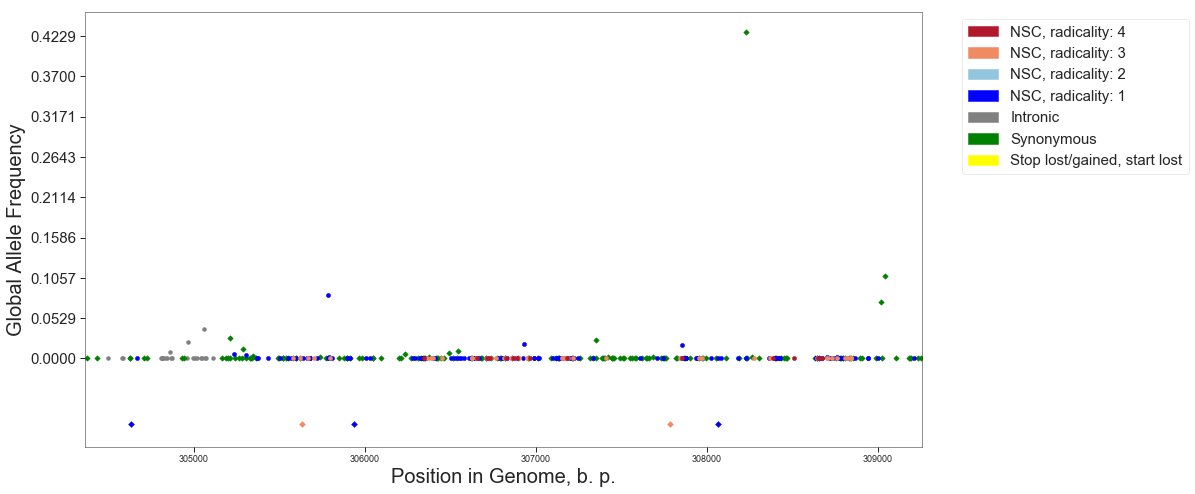

step 23 
 gene ID: PF3D7_1125100 
 start, b. p.: 986630 
 end, b. p.: 988120 
 gene length, b. p.: 1491 
 gene description: vacuolar+membrane+protein-related%2C+putative 
 gene name: nan 
 conservation score: 3.149193548


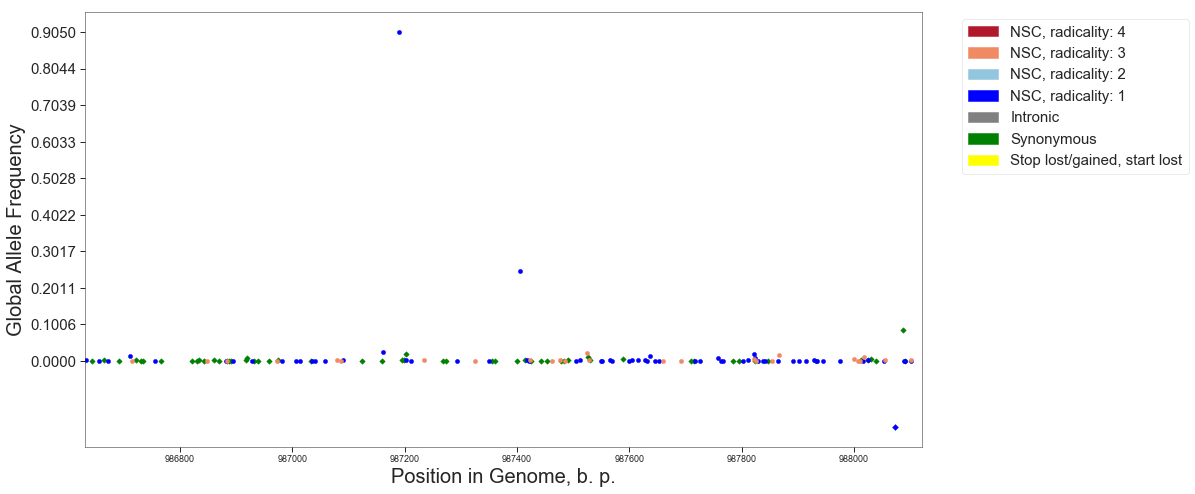

step 24 
 gene ID: PF3D7_0629500 
 start, b. p.: 1213948 
 end, b. p.: 1216005 
 gene length, b. p.: 2058 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: nan


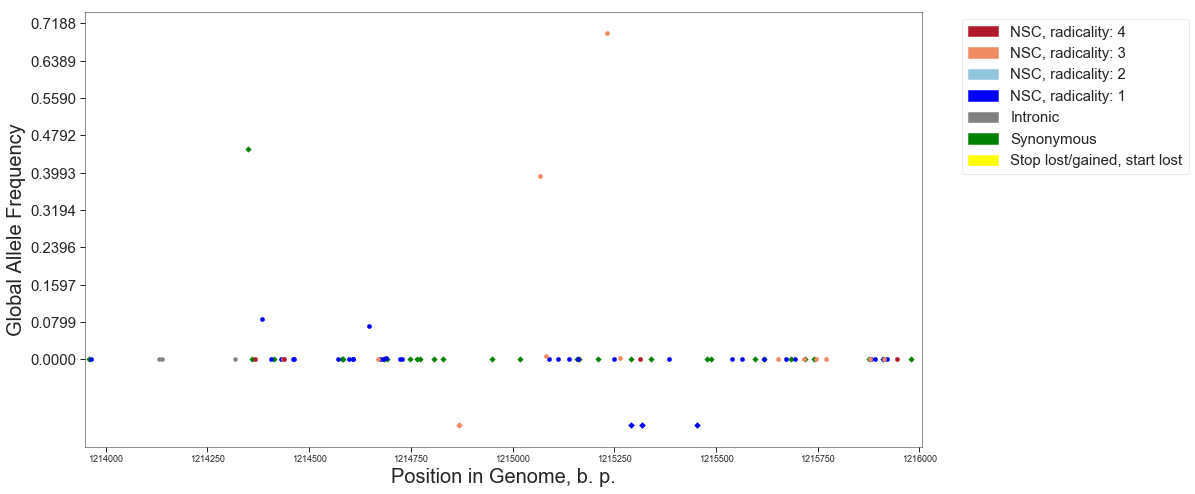

step 25 
 gene ID: PF3D7_1036800 
 start, b. p.: 1448692 
 end, b. p.: 1451646 
 gene length, b. p.: 2955 
 gene description: acetyl-CoA+transporter%2C+putative 
 gene name: ACT 
 conservation score: 2.766101695


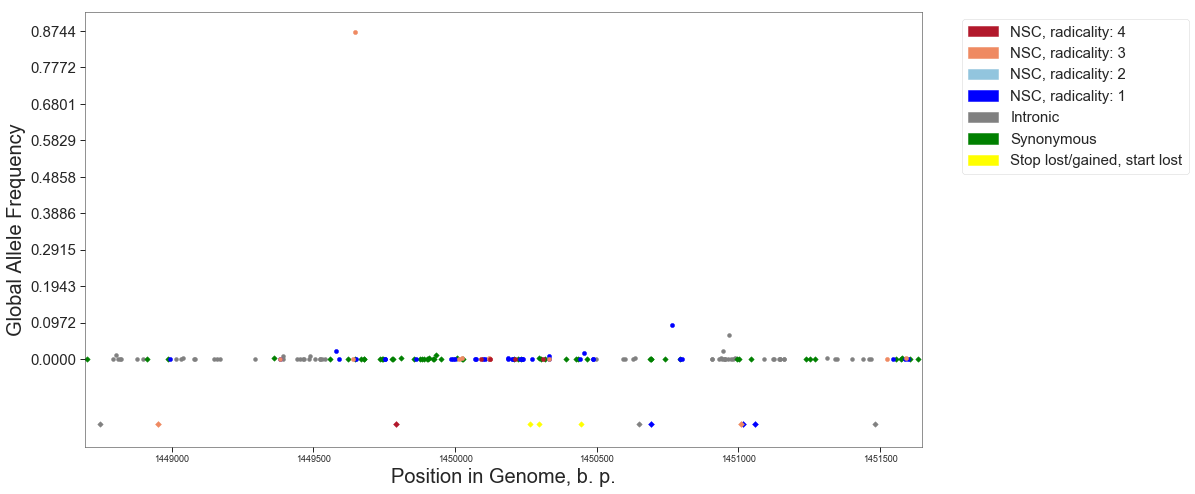

step 26 
 gene ID: PF3D7_1147500 
 start, b. p.: 1889826 
 end, b. p.: 1892597 
 gene length, b. p.: 2772 
 gene description: farnesyltransferase+beta+subunit%2C+putative 
 gene name: nan 
 conservation score: 1.616468039


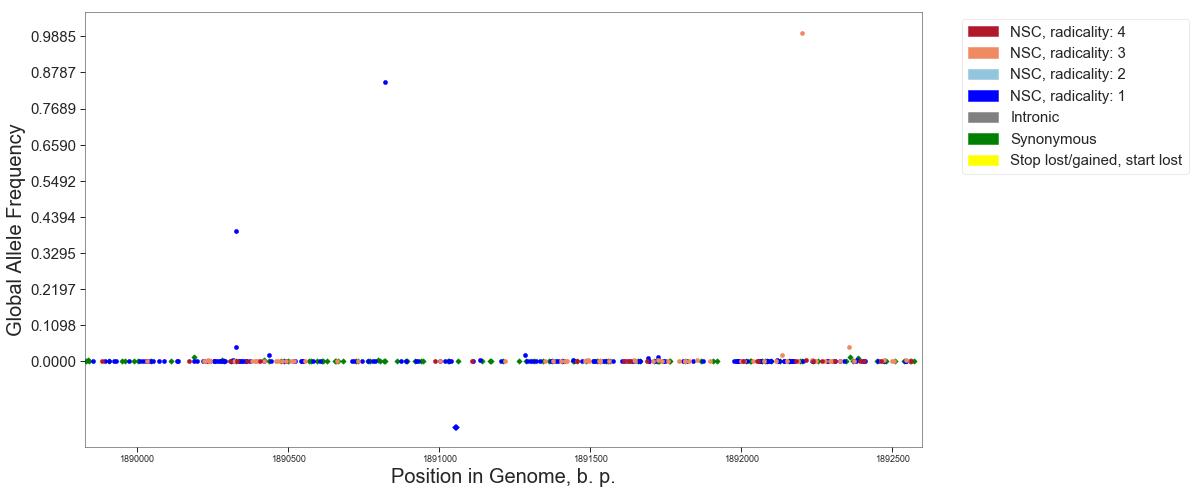

step 27 
 gene ID: PF3D7_0319700 
 start, b. p.: 820708 
 end, b. p.: 830802 
 gene length, b. p.: 10095 
 gene description: ABC+transporter%2C+putative 
 gene name: ABCI3 
 conservation score: 1.090647941


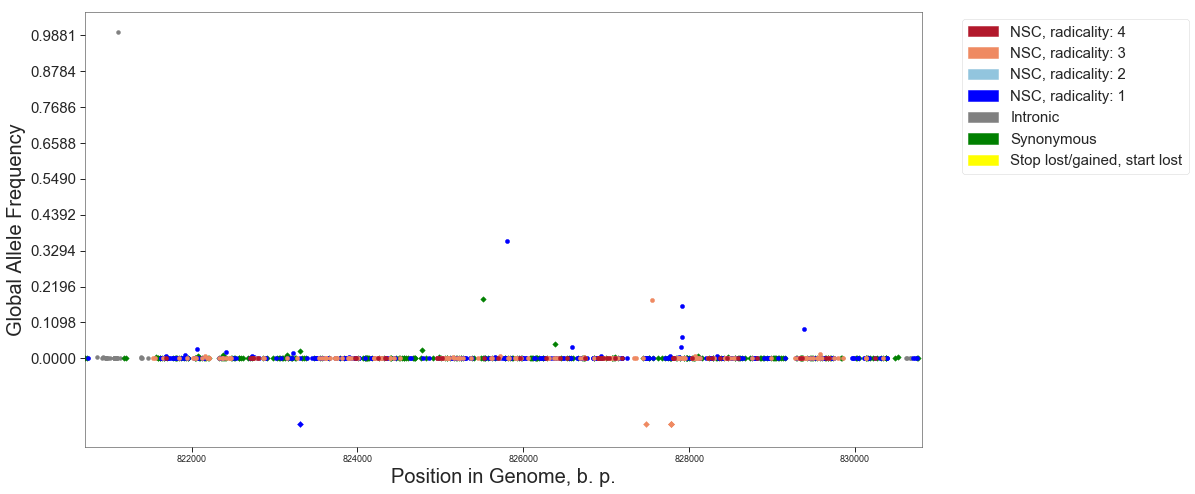

step 28 
 gene ID: PF3D7_1208400 
 start, b. p.: 390932 
 end, b. p.: 395626 
 gene length, b. p.: 4695 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: 1.377237852


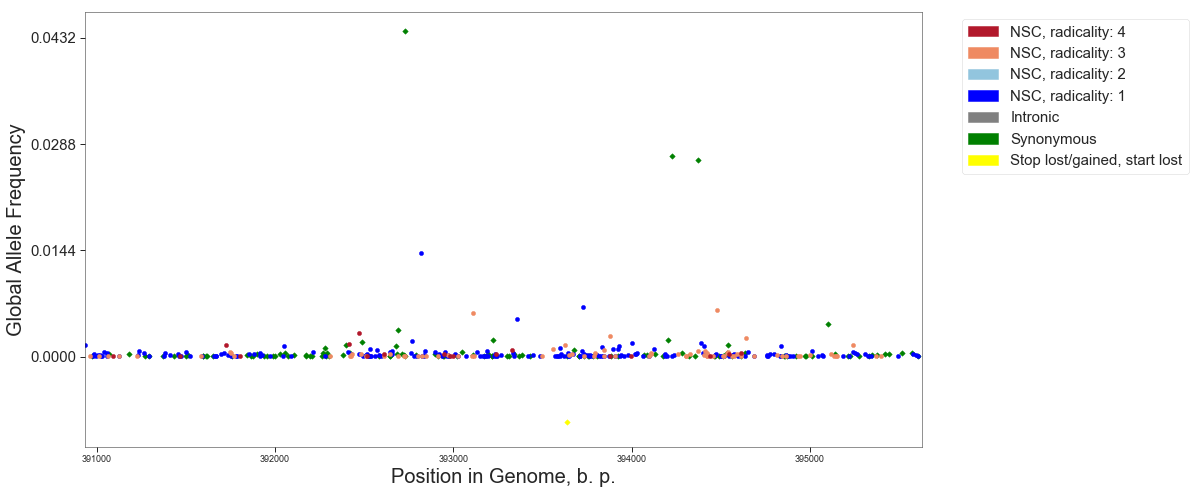

step 29 
 gene ID: PF3D7_1434000 
 start, b. p.: 1364749 
 end, b. p.: 1366113 
 gene length, b. p.: 1365 
 gene description: CCR4-associated+factor+16%2C+putative+%28CAF16%29 
 gene name: CAF16 
 conservation score: 2.918287938


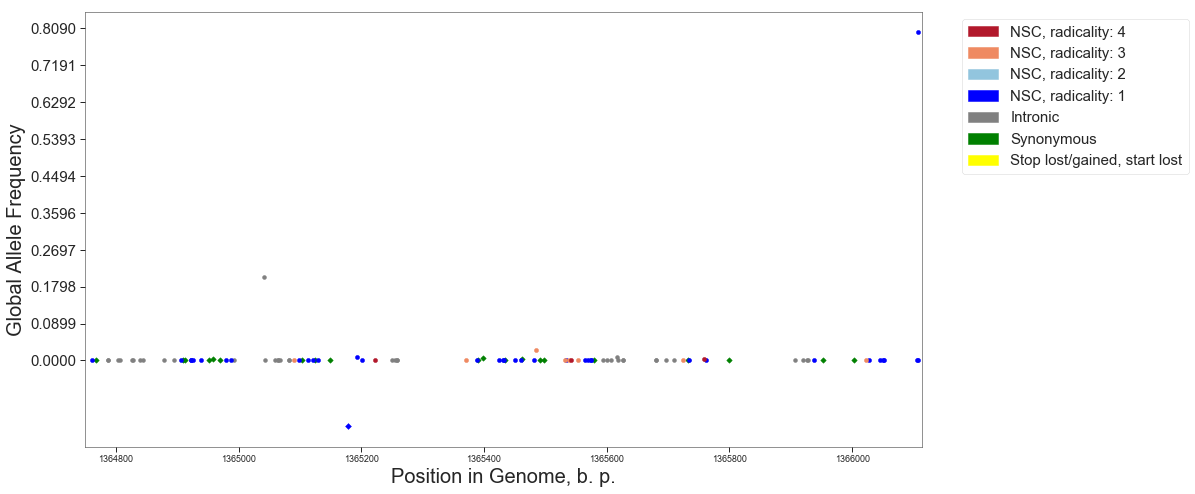

step 30 
 gene ID: PF3D7_0103100 
 start, b. p.: 134353 
 end, b. p.: 139257 
 gene length, b. p.: 4905 
 gene description: vacuolar protein sorting-associated protein 51, putative 
 gene name: VPS51 
 conservation score: -0.447368421


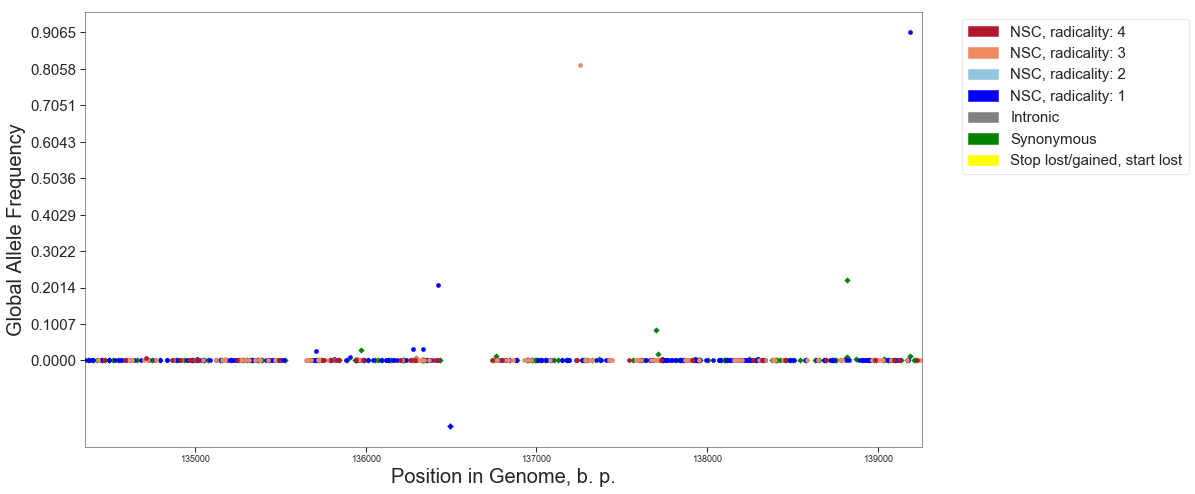

step 31 
 gene ID: PF3D7_0417200 
 start, b. p.: 748088 
 end, b. p.: 749914 
 gene length, b. p.: 1827 
 gene description: bifunctional+dihydrofolate+reductase-thymidylate+synthase+%28DHFR-TS%29 
 gene name: DHFR-TS 
 conservation score: 3.378289474


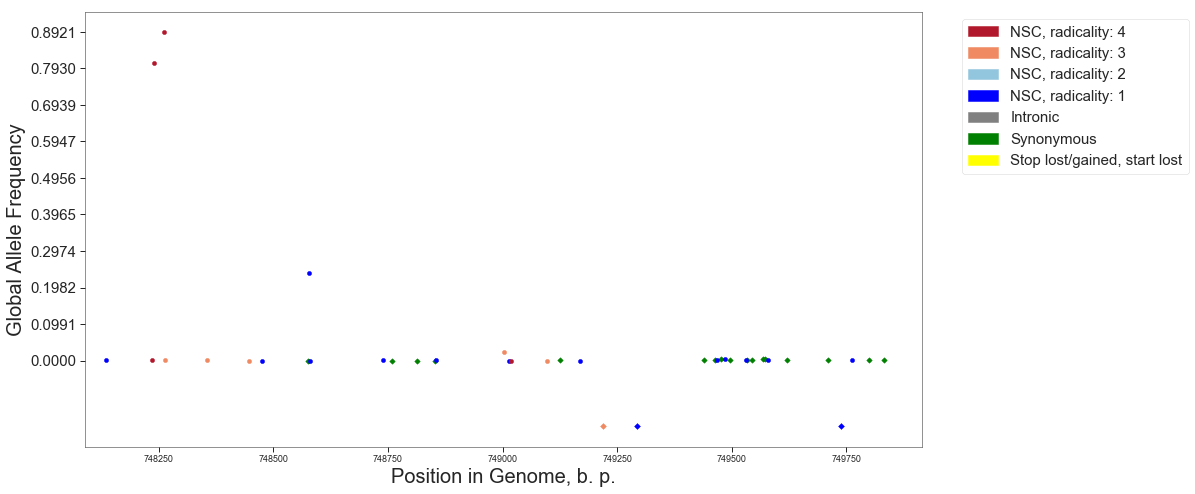

In [163]:
plotting_advanced(gene_picks_CT, df_Pf6_variants, df_cand_transp,score_metric='CCF')

In [177]:
df_cand_transp_pick = df_cand_transp[df_cand_transp.Gene_ID == 'PF3D7_0417200']
df_cand_transp_pick = df_cand_transp_pick.sort_values(by=['Position'])
df_cand_transp_pick = df_cand_transp_pick.drop_duplicates(subset = 'Position')
df_cand_transp_pick[['Compound','Position','Severity_CCF']]

Compound  Position  Severity_CCF
78  MMV027634    749220           3.0
79  MMV027634    749294           1.0
80  MMV027634    749738           1.0

In [2]:
df_Pf6_variants_cPheRS = df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0109800.1') 
                                         & (df_Pf6_variants.POS < 382400) 
                                         & (df_Pf6_variants.POS > 382300) 
                                         & (df_Pf6_variants.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')]

step 1 
 gene ID: PF3D7_1229100 
 start, b. p.: 1192888 
 end, b. p.: 1199214 
 gene length, b. p.: 6327 
 gene description: ABC+transporter%2C+%28CT+family%29+%28MRP2%29 
 gene name: MRP2 
 conservation score: nan


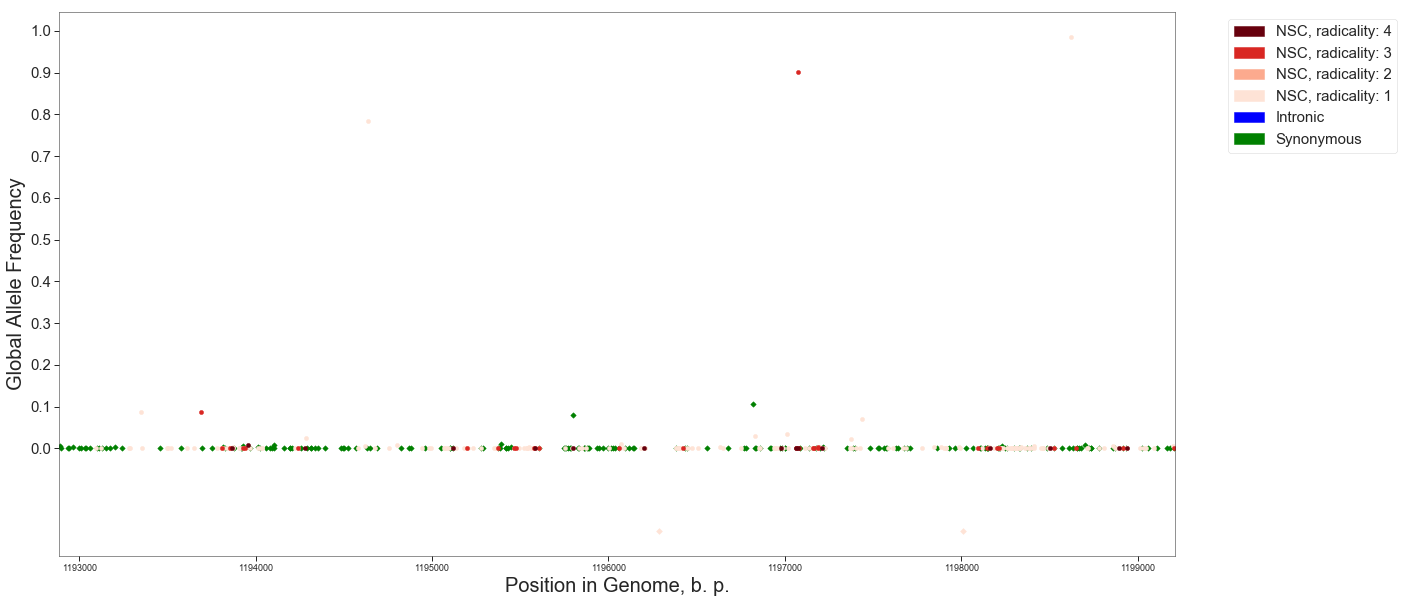

step 2 
 gene ID: PF3D7_0109800 
 start, b. p.: 380697 
 end, b. p.: 382424 
 gene length, b. p.: 1728 
 gene description: phenylalanine--tRNA+ligase%2C+putative 
 gene name: cPheRS 
 conservation score: 3.116521739


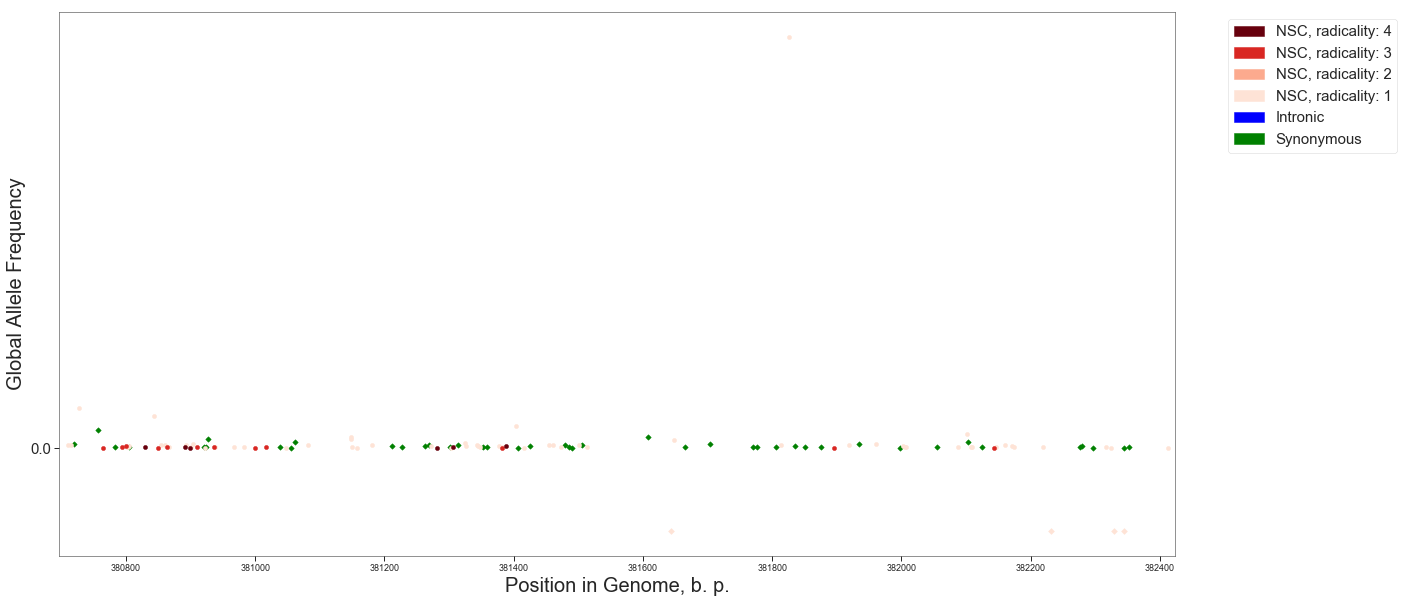

step 3 
 gene ID: PF3D7_0709700 
 start, b. p.: 435089 
 end, b. p.: 436195 
 gene length, b. p.: 1107 
 gene description: lysophospholipase%2C+putative 
 gene name: nan 
 conservation score: 2.6875


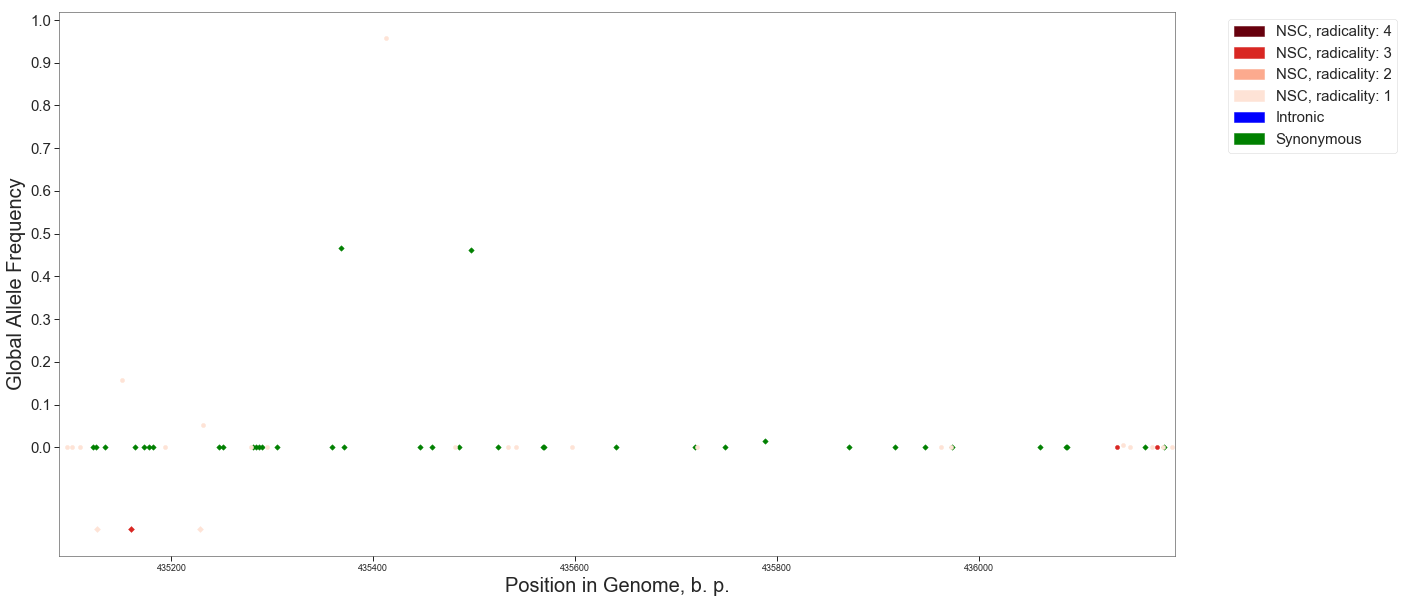

step 4 
 gene ID: PF3D7_0709000 
 start, b. p.: 403222 
 end, b. p.: 406317 
 gene length, b. p.: 3096 
 gene description: chloroquine+resistance+transporter+%28CRT%29 
 gene name: CRT 
 conservation score: 3.125


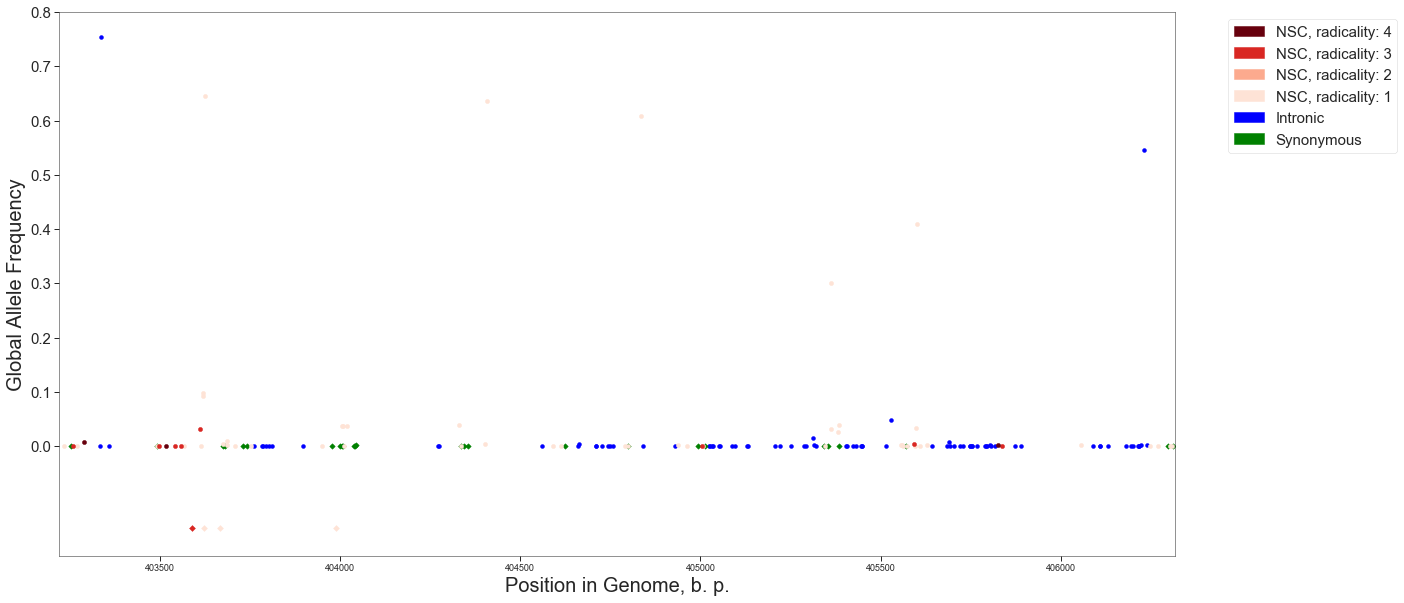

step 5 
 gene ID: PF3D7_1208400 
 start, b. p.: 390932 
 end, b. p.: 395626 
 gene length, b. p.: 4695 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: 1.377237852


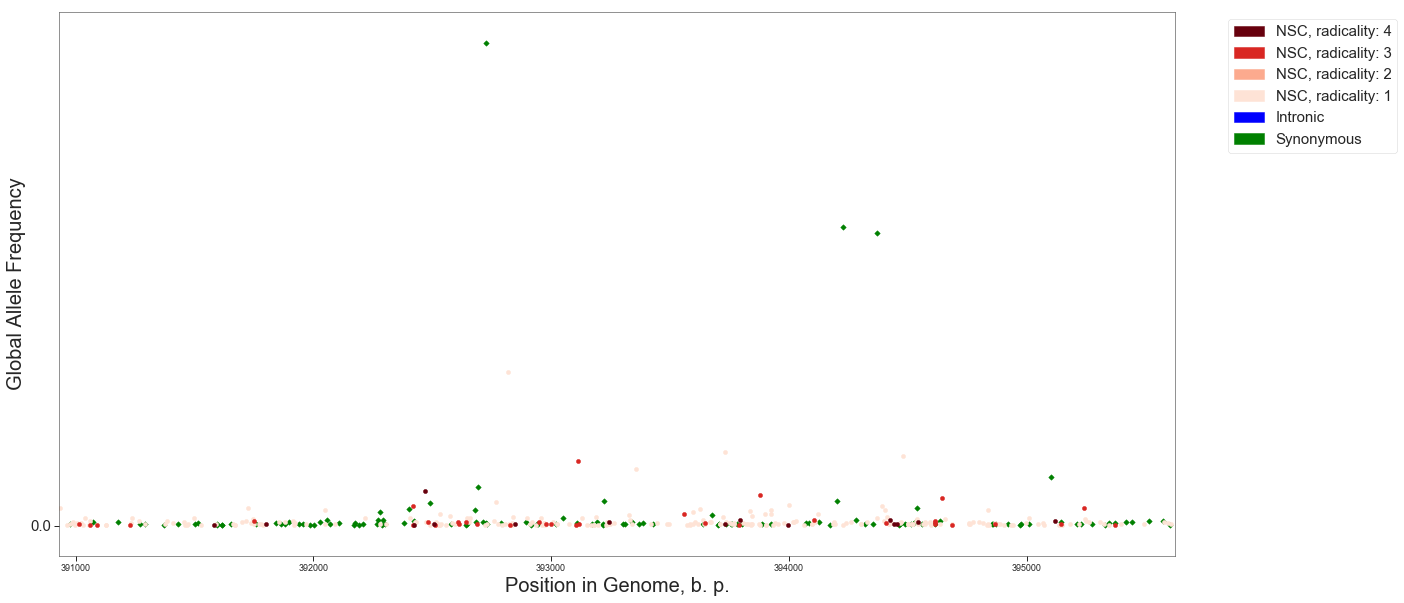

step 6 
 gene ID: PF3D7_1116700 
 start, b. p.: 630779 
 end, b. p.: 632881 
 gene length, b. p.: 2103 
 gene description: cathepsin+C%2C+homolog%2Cdipeptidyl+peptidase+1+%28DPAP1%29 
 gene name: DPAP1 
 conservation score: 2.475714286


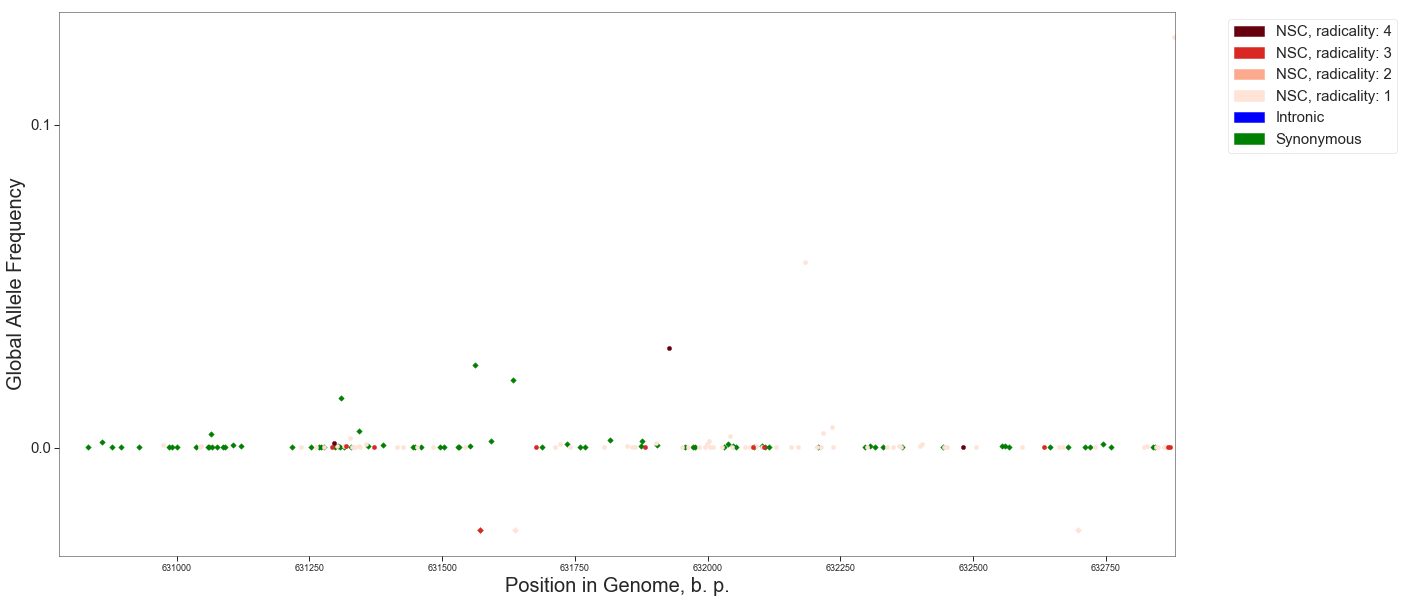

step 7 
 gene ID: PF3D7_0509800 
 start, b. p.: 410268 
 end, b. p.: 415308 
 gene length, b. p.: 5041 
 gene description: phosphatidylinositol+4-kinase 
 gene name: PI4K 
 conservation score: 1.756254009


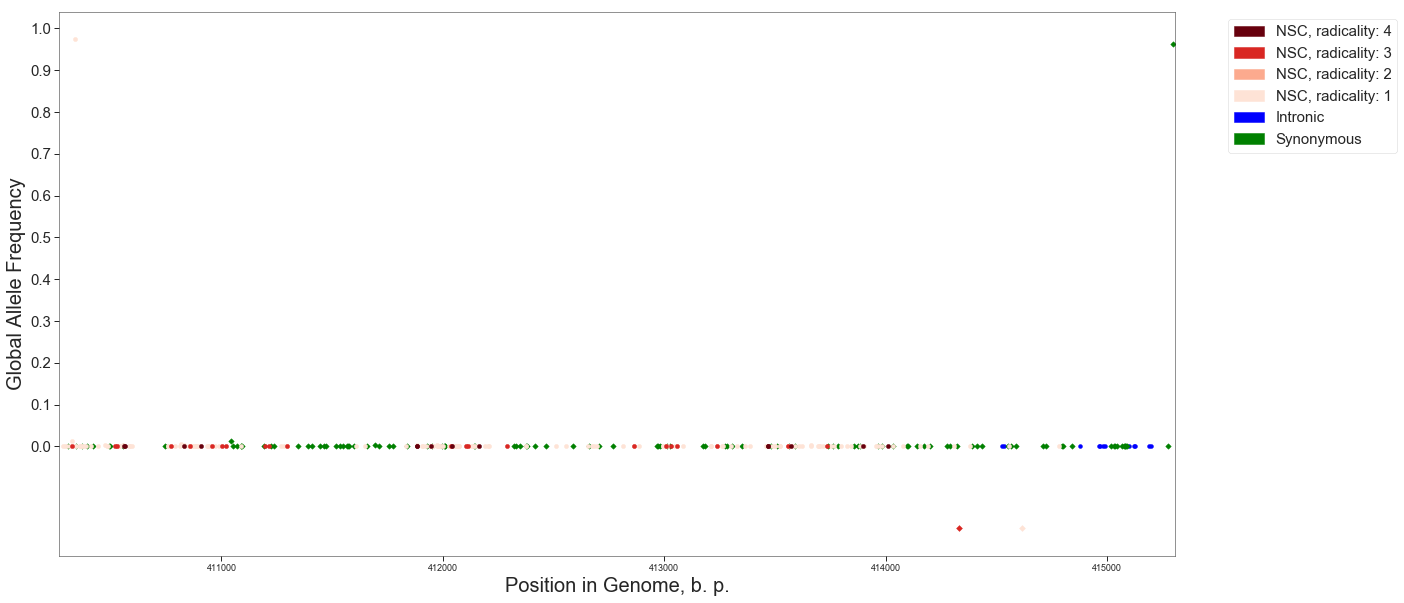

step 8 
 gene ID: PF3D7_1238800 
 start, b. p.: 1610363 
 end, b. p.: 1612741 
 gene length, b. p.: 2379 
 gene description: acyl-CoA+synthetase+%28ACS11%29 
 gene name: ACS11 
 conservation score: 2.640151515


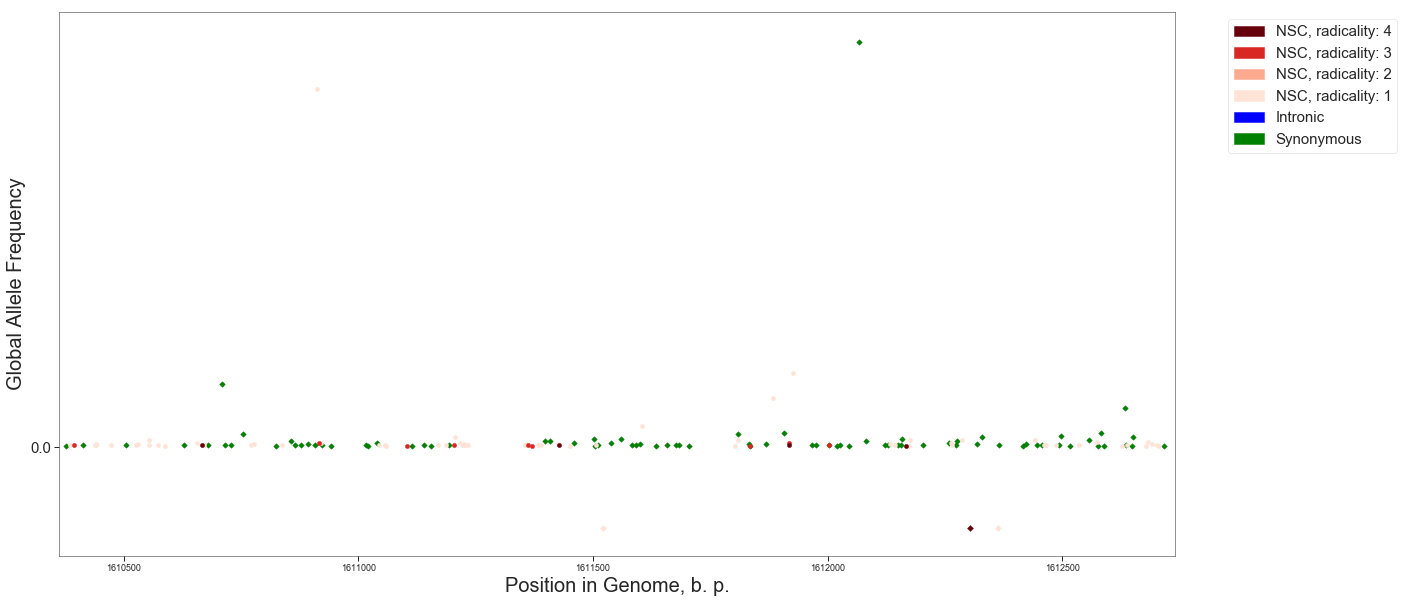

step 9 
 gene ID: PF3D7_1125100 
 start, b. p.: 986630 
 end, b. p.: 988120 
 gene length, b. p.: 1491 
 gene description: vacuolar+membrane+protein-related%2C+putative 
 gene name: nan 
 conservation score: 3.149193548


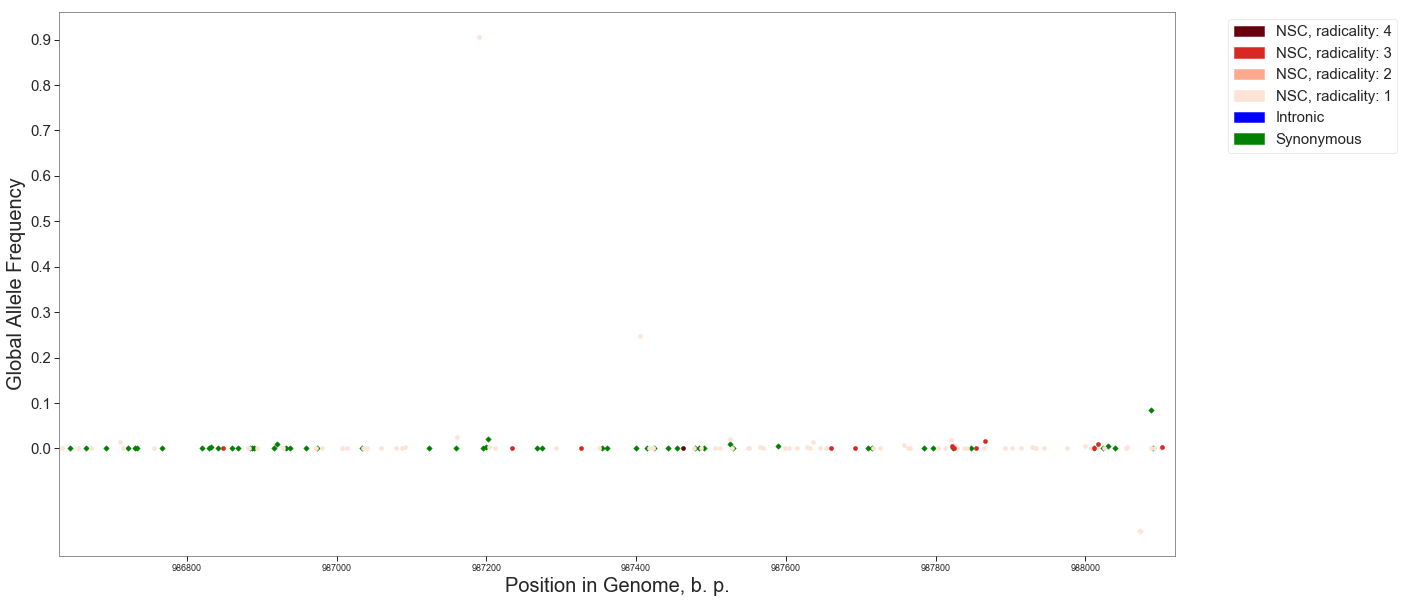

step 10 
 gene ID: PF3D7_0321900 
 start, b. p.: 922974 
 end, b. p.: 927942 
 gene length, b. p.: 4969 
 gene description: cyclic+amine+resistance+locus+protein+%28CARL%29 
 gene name: CARL 
 conservation score: 0.980514419


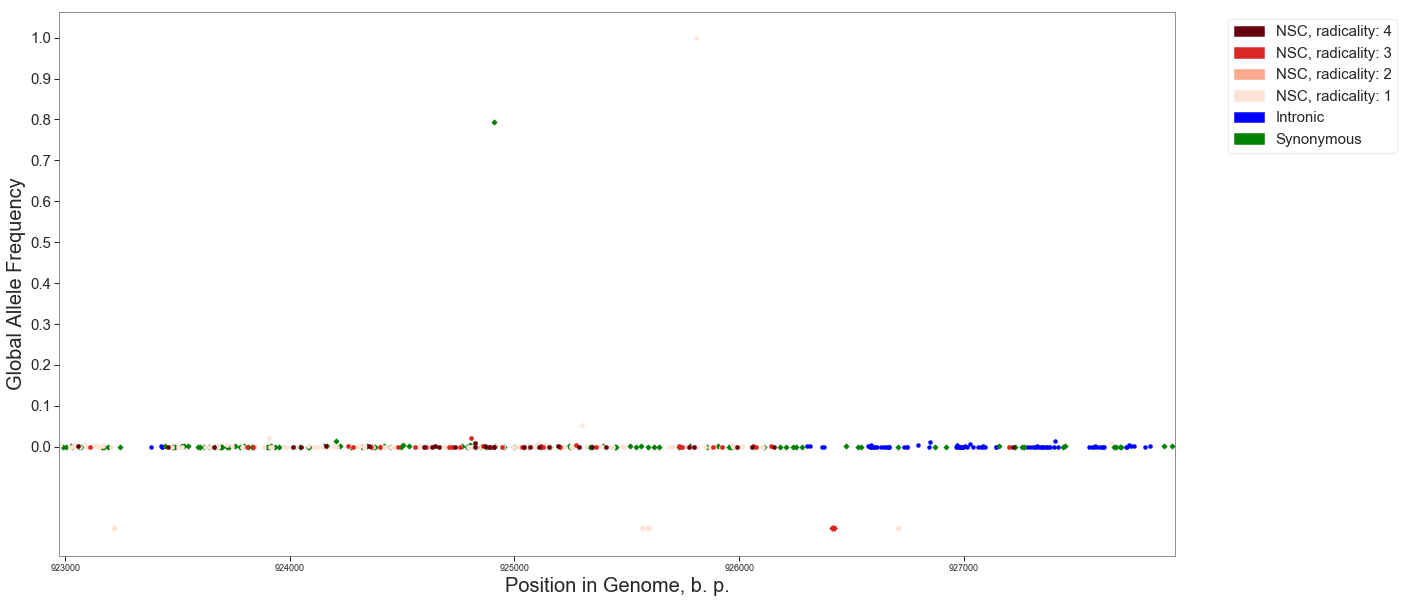

step 11 
 gene ID: PF3D7_1434000 
 start, b. p.: 1364749 
 end, b. p.: 1366113 
 gene length, b. p.: 1365 
 gene description: CCR4-associated+factor+16%2C+putative+%28CAF16%29 
 gene name: CAF16 
 conservation score: 2.918287938


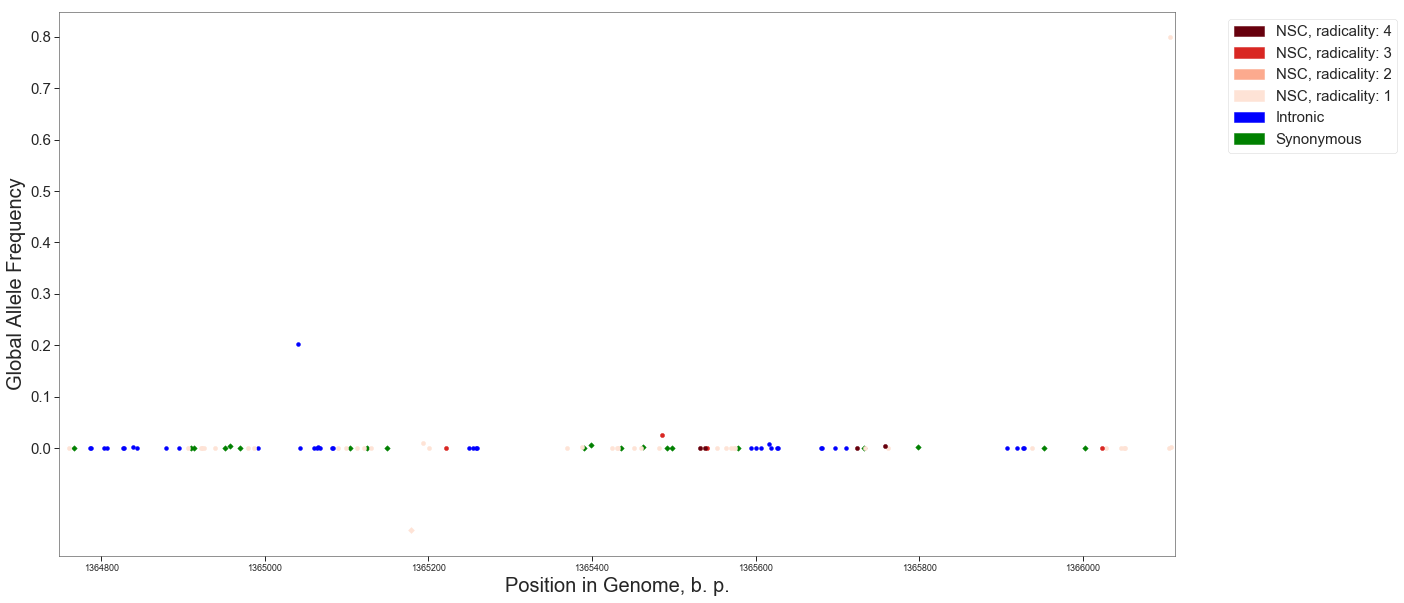

step 12 
 gene ID: PF3D7_0826100 
 start, b. p.: 1113369 
 end, b. p.: 1139144 
 gene length, b. p.: 25776 
 gene description: E3+ubiquitin-protein+ligase%2C+putative 
 gene name: nan 
 conservation score: 1.216040042


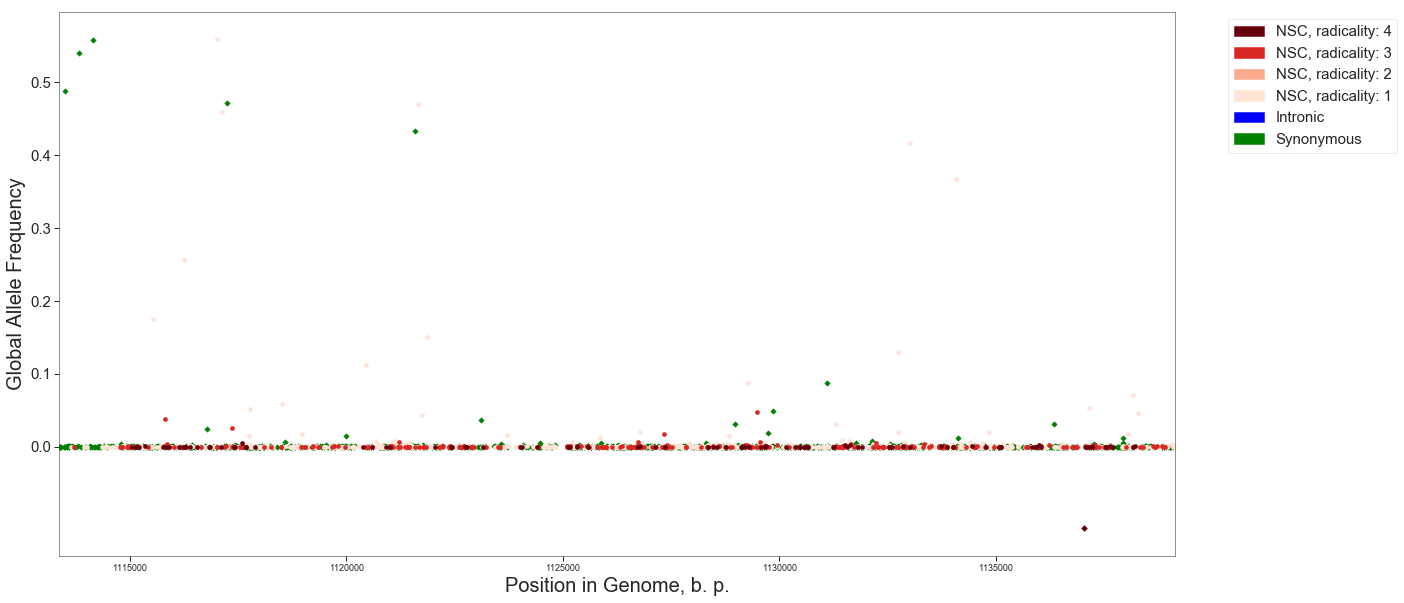

step 13 
 gene ID: PF3D7_0613800 
 start, b. p.: 566139 
 end, b. p.: 578993 
 gene length, b. p.: 12855 
 gene description: transcription+factor+with+AP2+domain%28s%29+%28ApiAP2%29 
 gene name: ApiAP2 
 conservation score: -1.505475785


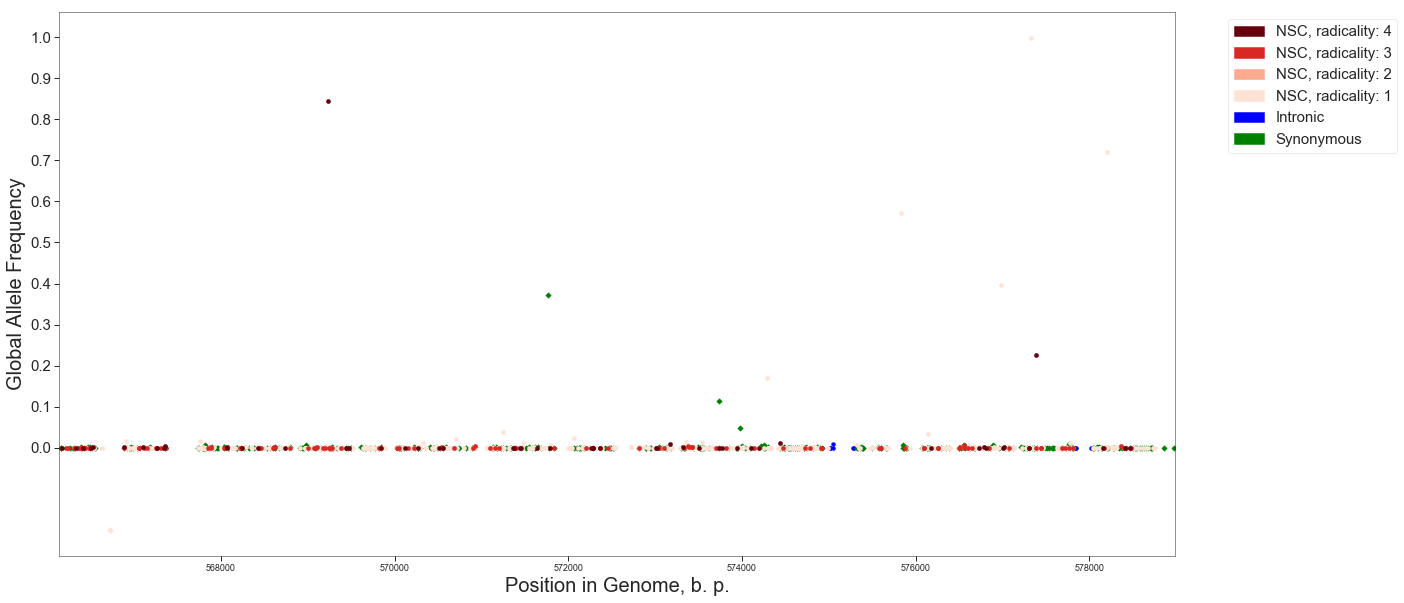

step 14 
 gene ID: PF3D7_1113300 
 start, b. p.: 519189 
 end, b. p.: 520220 
 gene length, b. p.: 1032 
 gene description: UDP-galactose+transporter%2C+putative 
 gene name: UGT 
 conservation score: 3.930029155


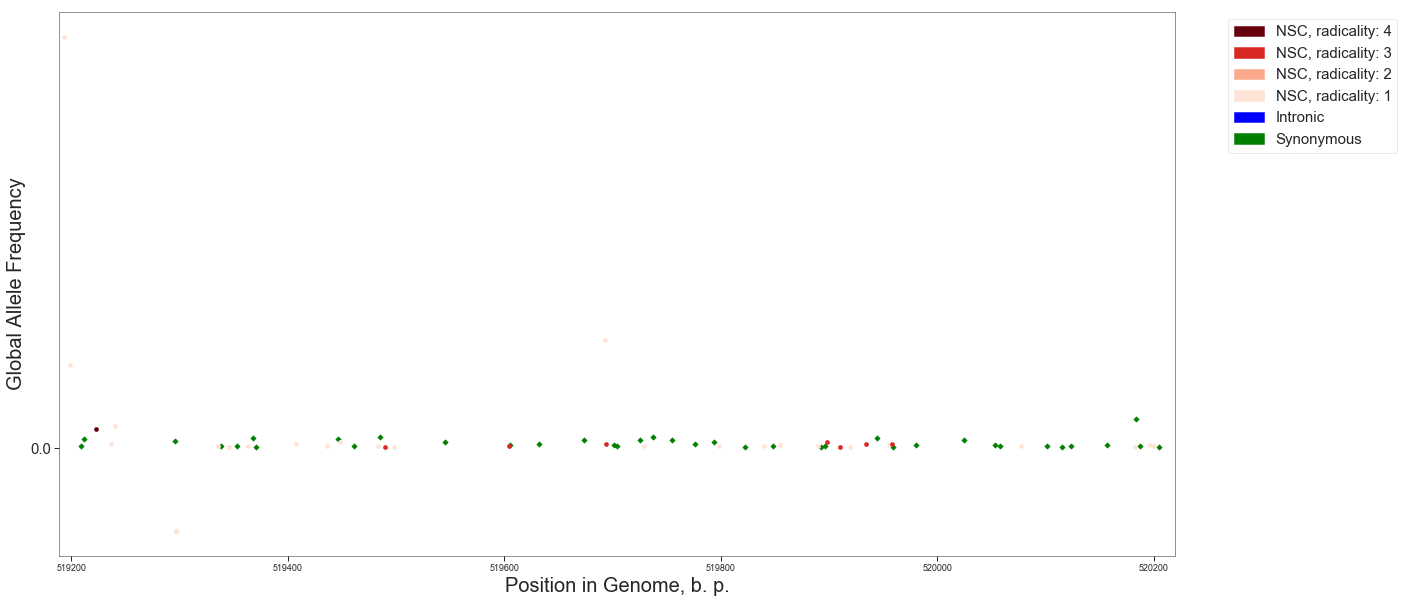

step 15 
 gene ID: PF3D7_1036800 
 start, b. p.: 1448692 
 end, b. p.: 1451646 
 gene length, b. p.: 2955 
 gene description: acetyl-CoA+transporter%2C+putative 
 gene name: ACT 
 conservation score: 2.766101695


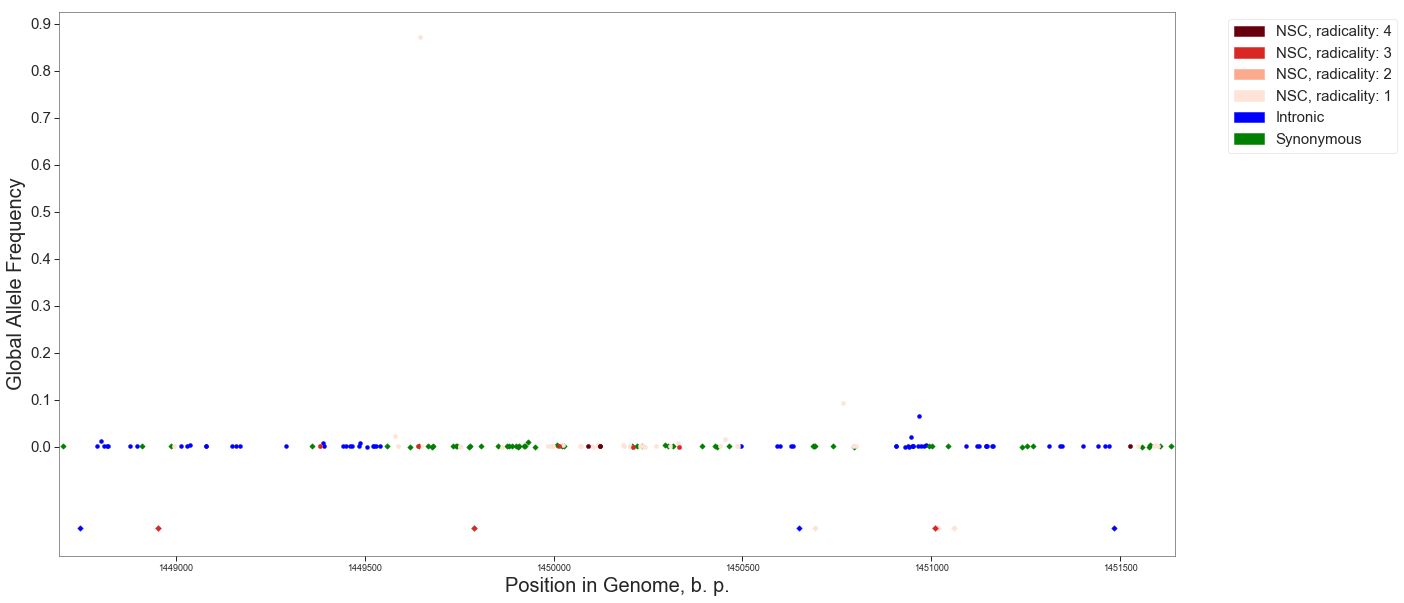

step 16 
 gene ID: PF3D7_1241700 
 start, b. p.: 1778154 
 end, b. p.: 1779411 
 gene length, b. p.: 1258 
 gene description: replication+factor+C+subunit+4%2C+putative 
 gene name: RFC4 
 conservation score: 4.520833333


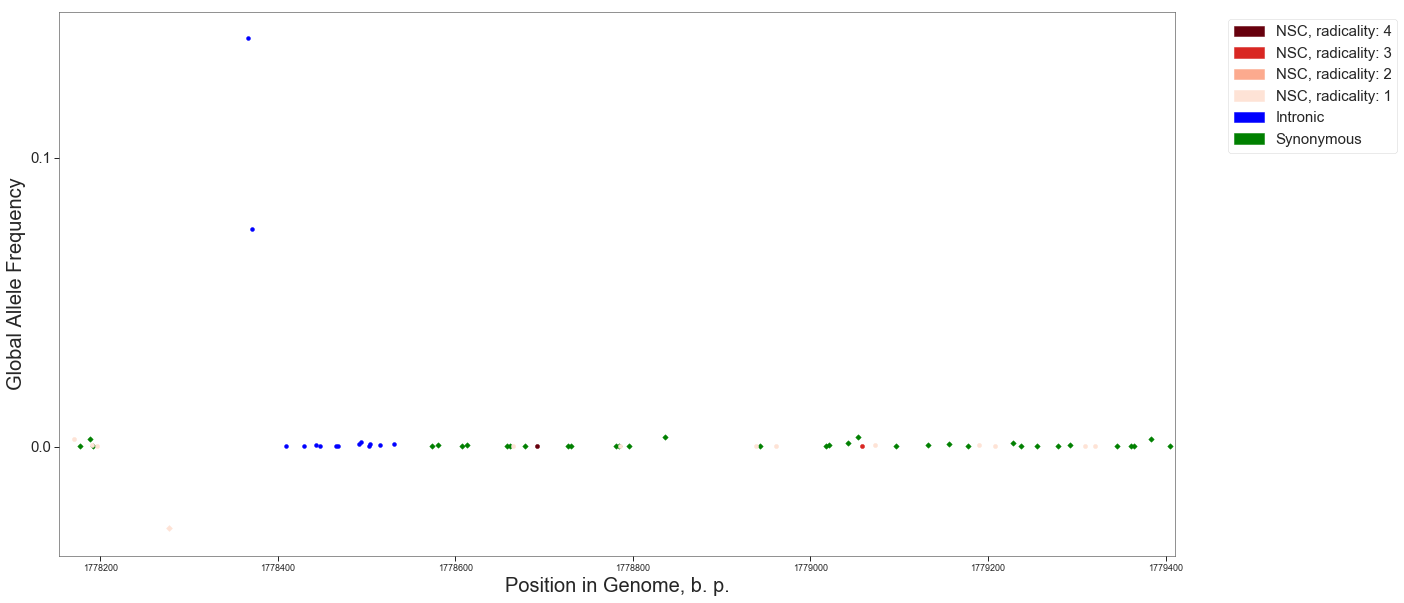

step 17 
 gene ID: PF3D7_0417200 
 start, b. p.: 748088 
 end, b. p.: 749914 
 gene length, b. p.: 1827 
 gene description: bifunctional+dihydrofolate+reductase-thymidylate+synthase+%28DHFR-TS%29 
 gene name: DHFR-TS 
 conservation score: 3.378289474


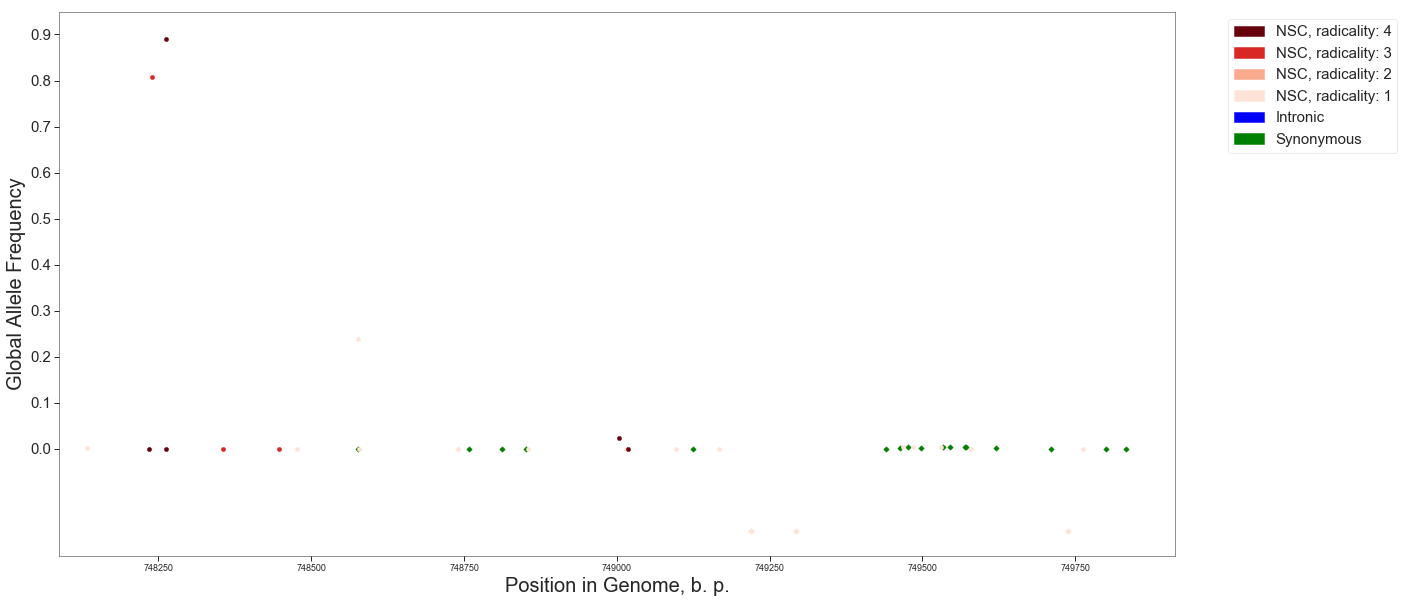

step 18 
 gene ID: PF3D7_0319700 
 start, b. p.: 820708 
 end, b. p.: 830802 
 gene length, b. p.: 10095 
 gene description: ABC+transporter%2C+putative 
 gene name: ABCI3 
 conservation score: 1.090647941


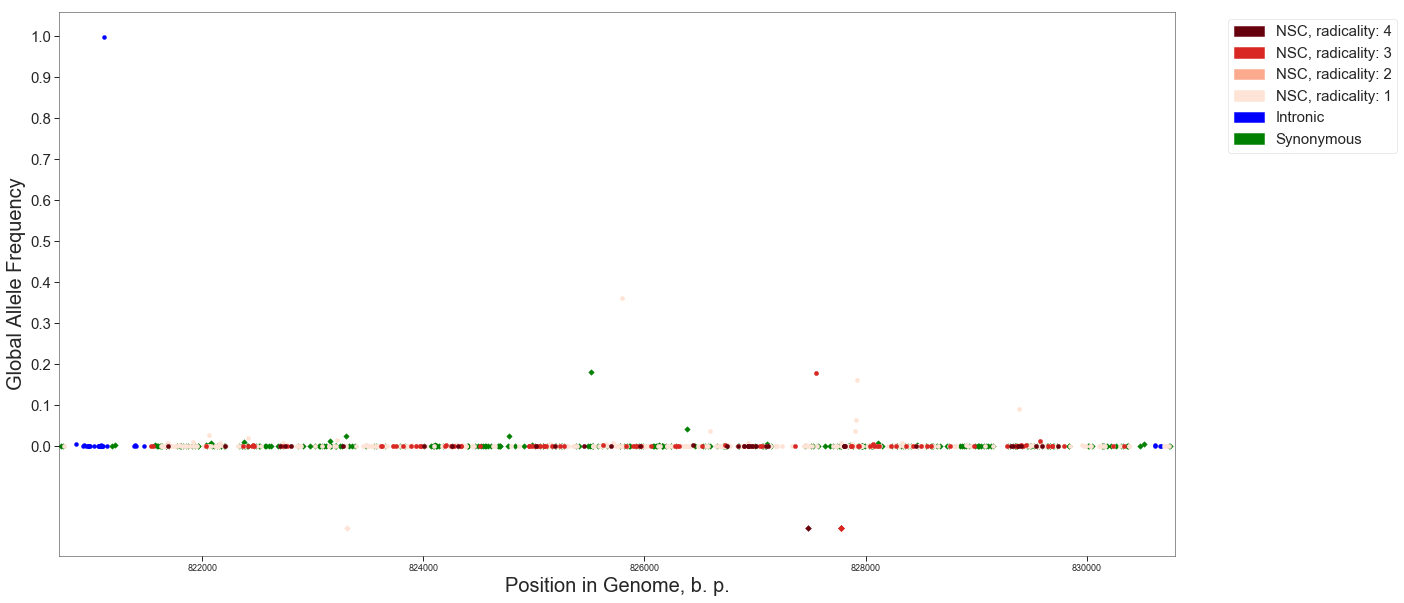

step 19 
 gene ID: PF3D7_1472100 
 start, b. p.: 2941600 
 end, b. p.: 2943259 
 gene length, b. p.: 1660 
 gene description: Yip1+protein%2C+putative 
 gene name: YIP1 
 conservation score: 2.920382166


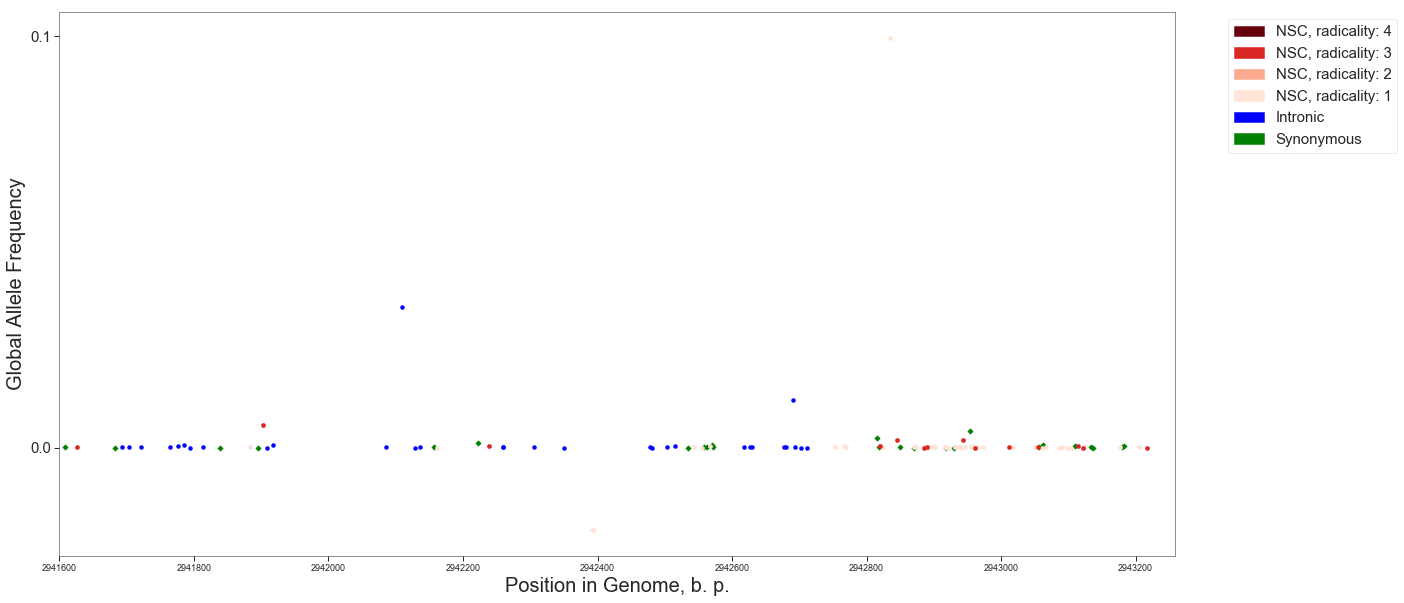

step 20 
 gene ID: PF3D7_1147500 
 start, b. p.: 1889826 
 end, b. p.: 1892597 
 gene length, b. p.: 2772 
 gene description: farnesyltransferase+beta+subunit%2C+putative 
 gene name: nan 
 conservation score: 1.616468039


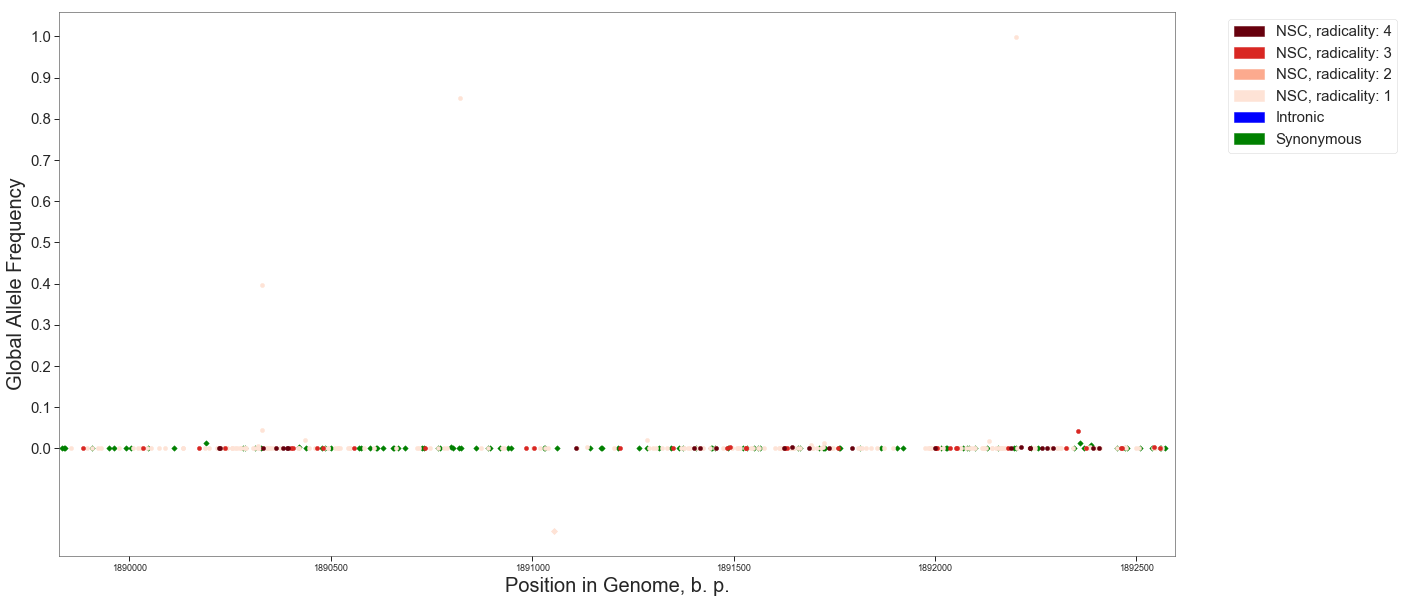

step 21 
 gene ID: PF3D7_1471200 
 start, b. p.: 2912386 
 end, b. p.: 2915354 
 gene length, b. p.: 2969 
 gene description: inorganic+anion+exchanger%2C+inorganic+anion+antiporter+%28SulP%29 
 gene name: SulP 
 conservation score: 4.037650602


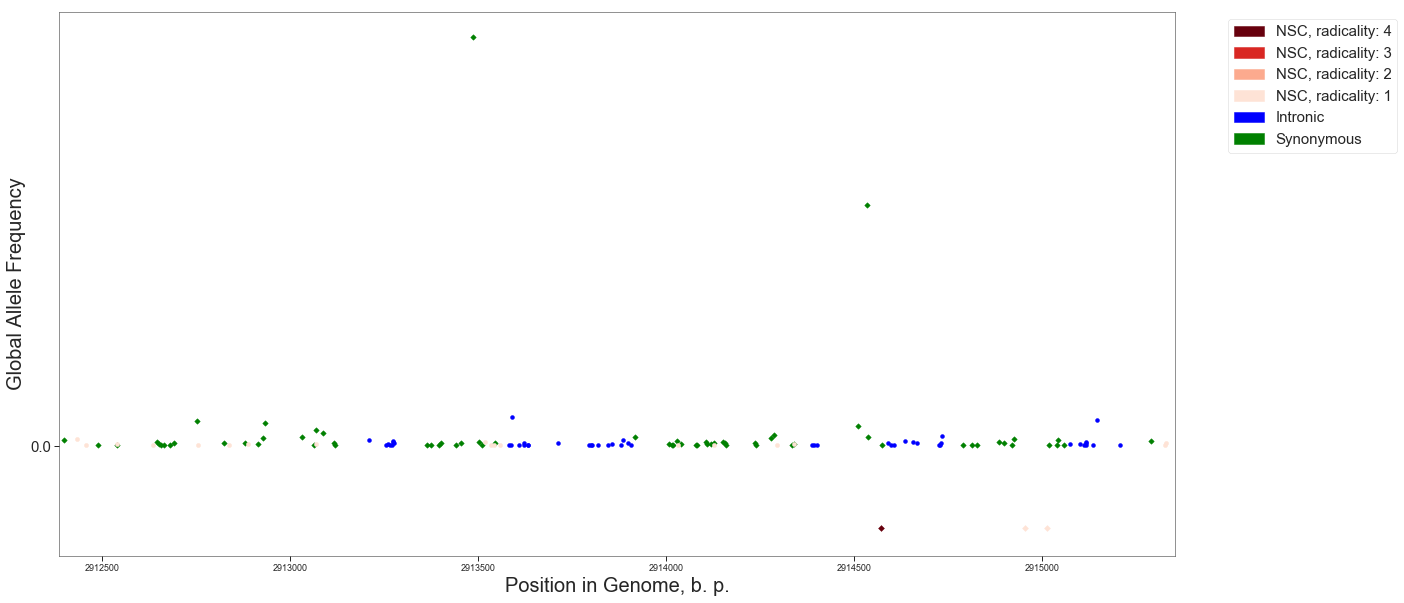

step 22 
 gene ID: PF3D7_0523000 
 start, b. p.: 957890 
 end, b. p.: 962149 
 gene length, b. p.: 4260 
 gene description: multidrug+resistance+protein+%28MDR1%29 
 gene name: MDR1 
 conservation score: 3.286116984


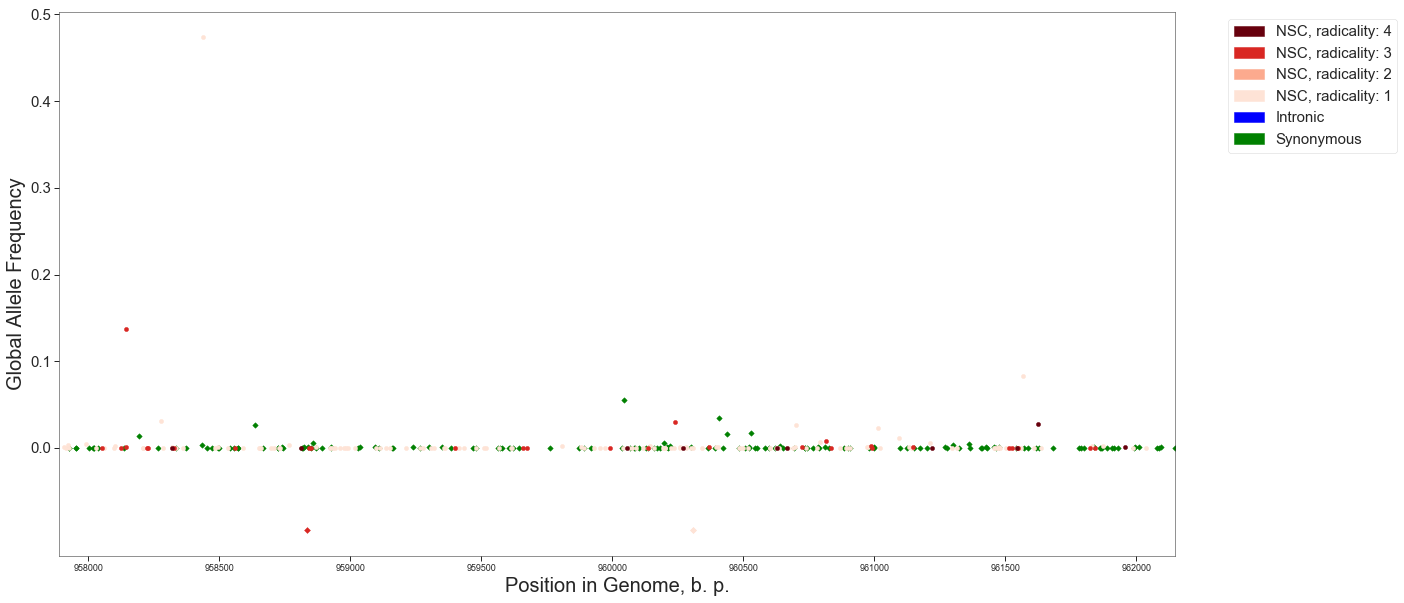

step 23 
 gene ID: PF3D7_0629500 
 start, b. p.: 1213948 
 end, b. p.: 1216005 
 gene length, b. p.: 2058 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: nan


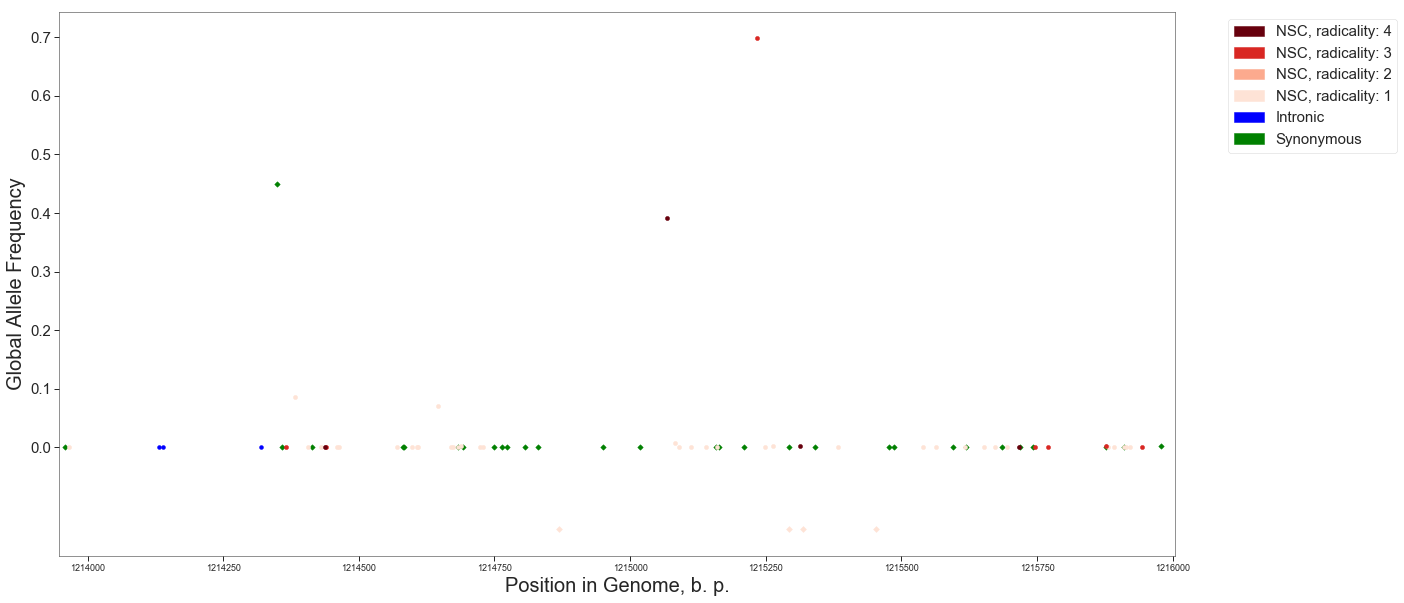

step 24 
 gene ID: PF3D7_1414700 
 start, b. p.: 592992 
 end, b. p.: 597146 
 gene length, b. p.: 4155 
 gene description: ubiquitin+carboxyl-terminal+hydrolase%2C+putative 
 gene name: nan 
 conservation score: 0.582369942


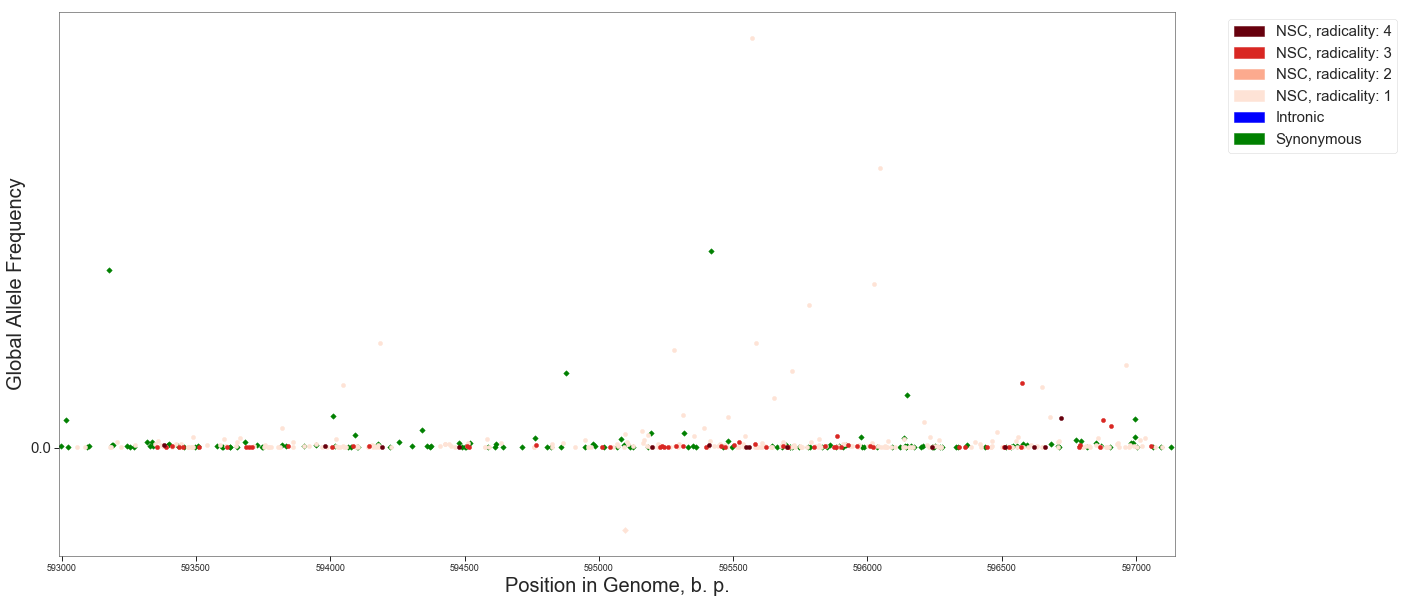

step 25 
 gene ID: PF3D7_1211900 
 start, b. p.: 529005 
 end, b. p.: 532799 
 gene length, b. p.: 3795 
 gene description: non-SERCA-type+Ca2++-transporting+P-ATPase+%28ATP4%29 
 gene name: ATP4 
 conservation score: 3.592563291


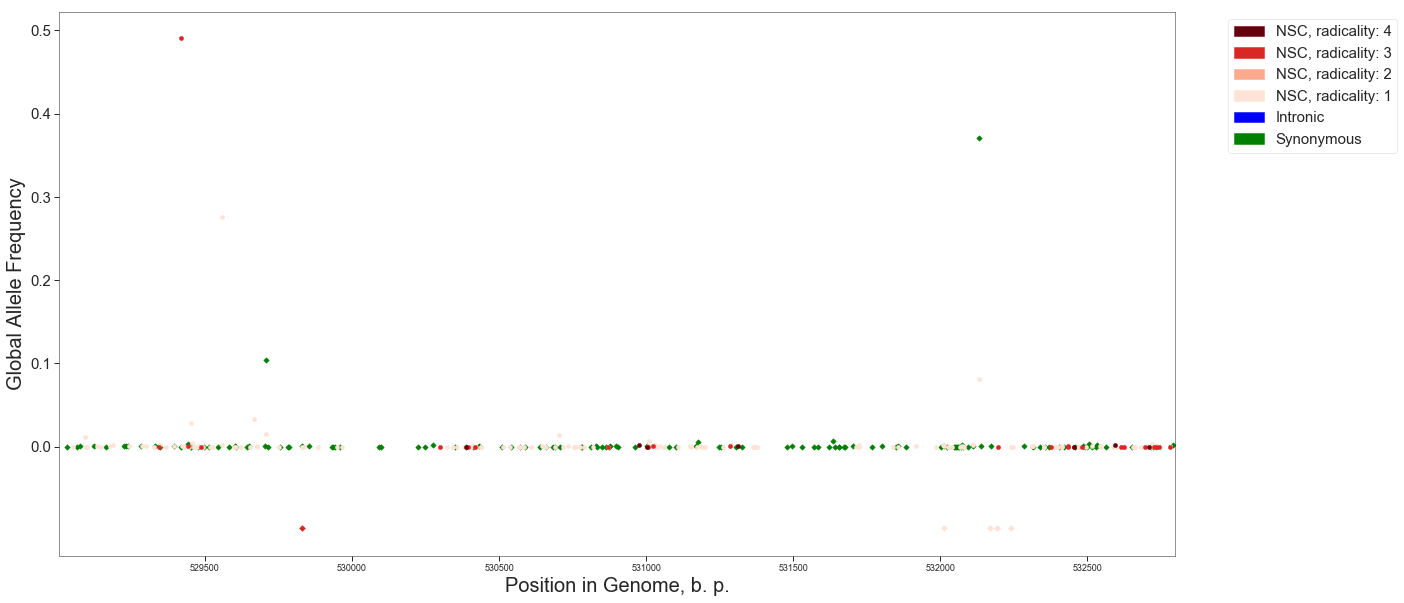

step 26 
 gene ID: PF3D7_0909700 
 start, b. p.: 440914 
 end, b. p.: 444024 
 gene length, b. p.: 3111 
 gene description: FHA+domain+protein%2C+putative 
 gene name: nan 
 conservation score: 1.005791506


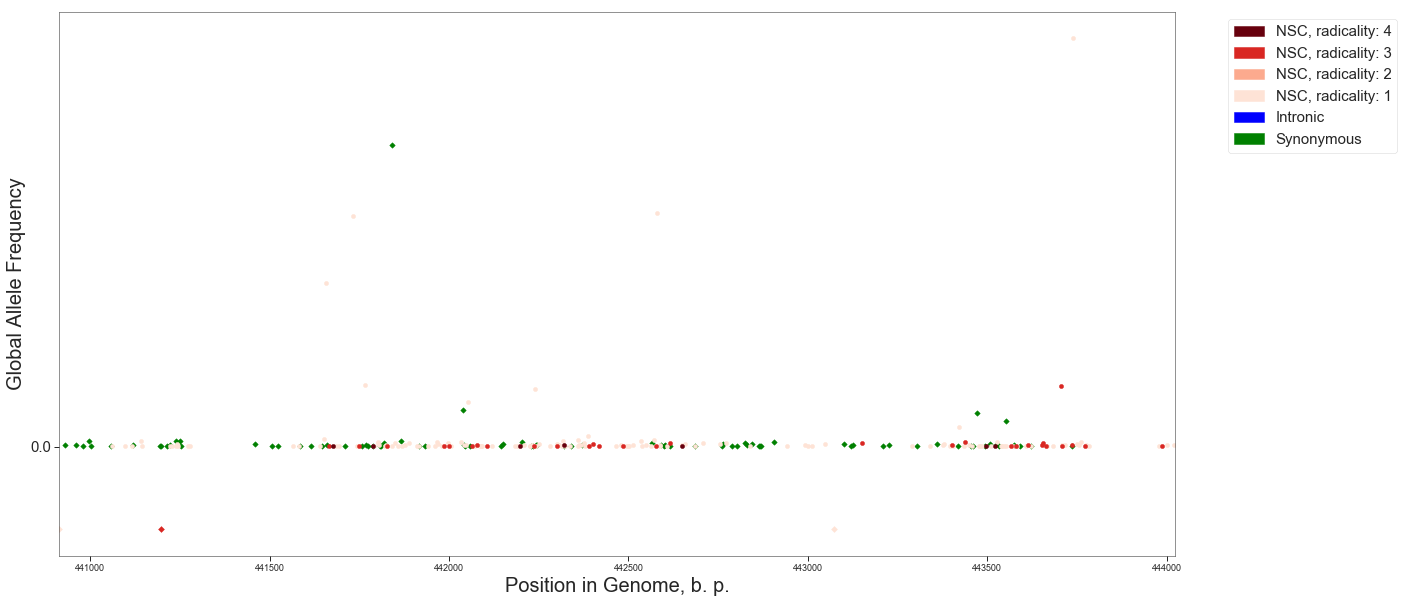

step 27 
 gene ID: PF3D7_0103100 
 start, b. p.: 134353 
 end, b. p.: 139257 
 gene length, b. p.: 4905 
 gene description: vacuolar protein sorting-associated protein 51, putative 
 gene name: VPS51 
 conservation score: -0.447368421


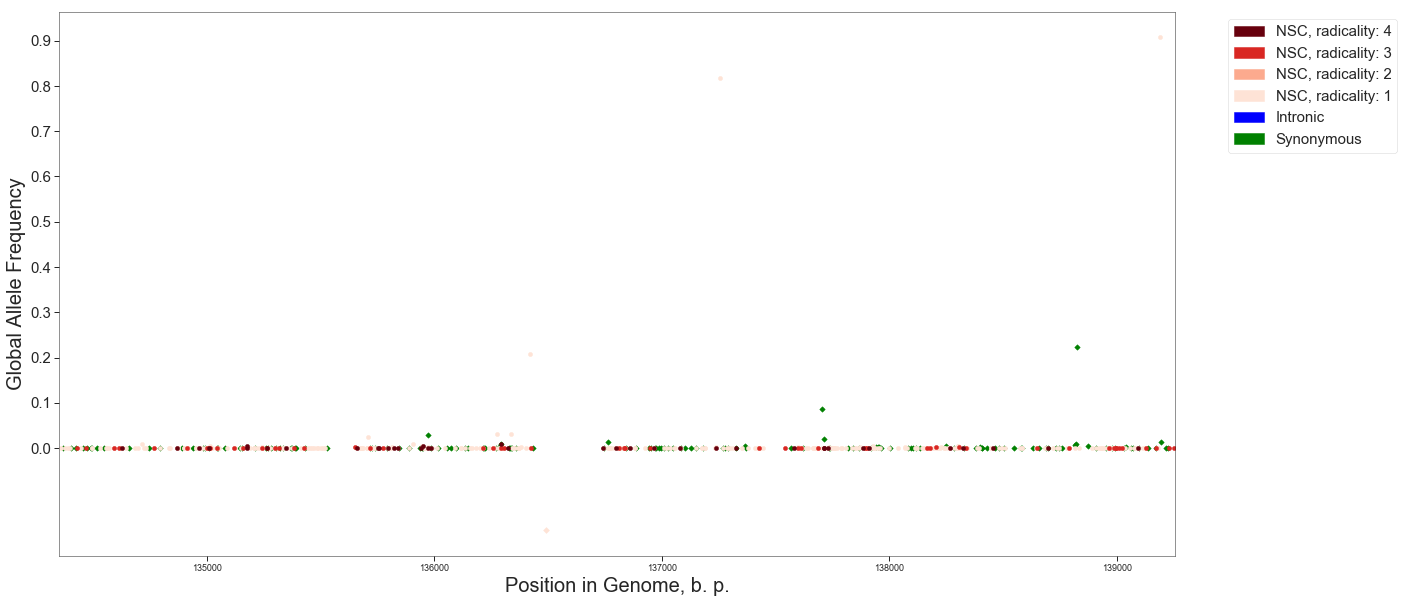

step 28 
 gene ID: PF3D7_1447900 
 start, b. p.: 1954601 
 end, b. p.: 1957675 
 gene length, b. p.: 3075 
 gene description: multidrug+resistance+protein+2+%28heavy+metal+transport+family%29+%28MDR2%29 
 gene name: MDR2 
 conservation score: 1.989257813


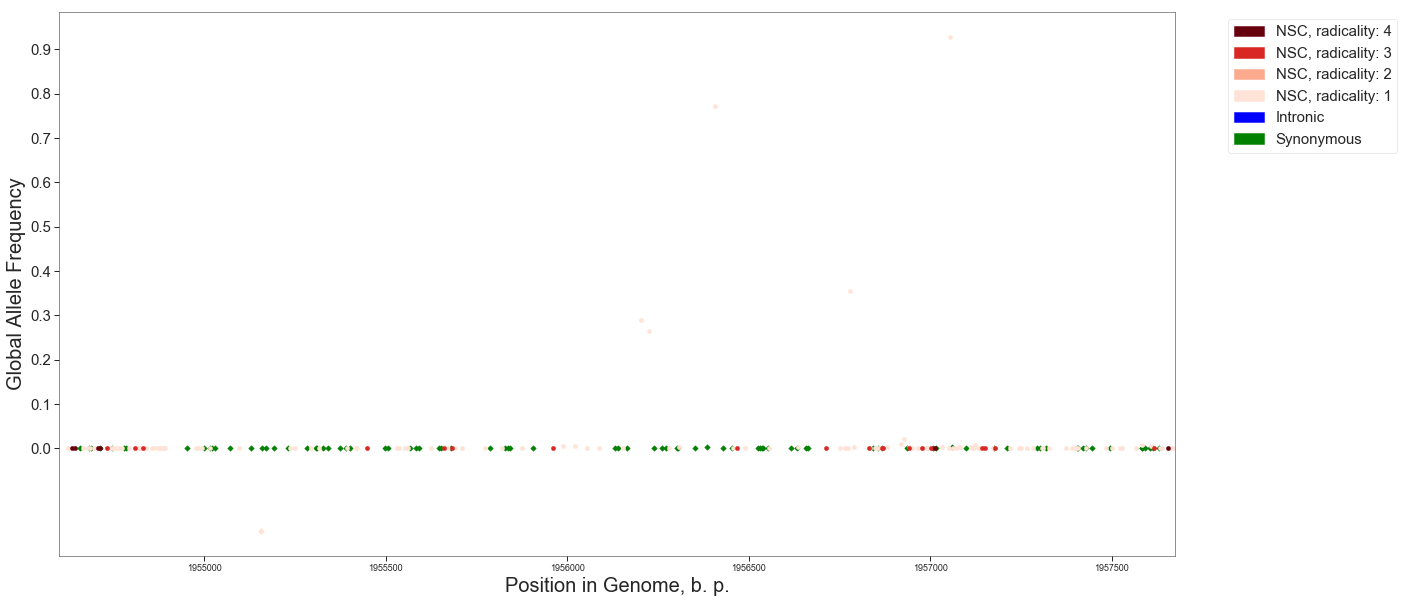

step 29 
 gene ID: PF3D7_0107500 
 start, b. p.: 304362 
 end, b. p.: 309257 
 gene length, b. p.: 4896 
 gene description: lipid%2Fsterol%3AH++symporter 
 gene name: nan 
 conservation score: 1.778911565


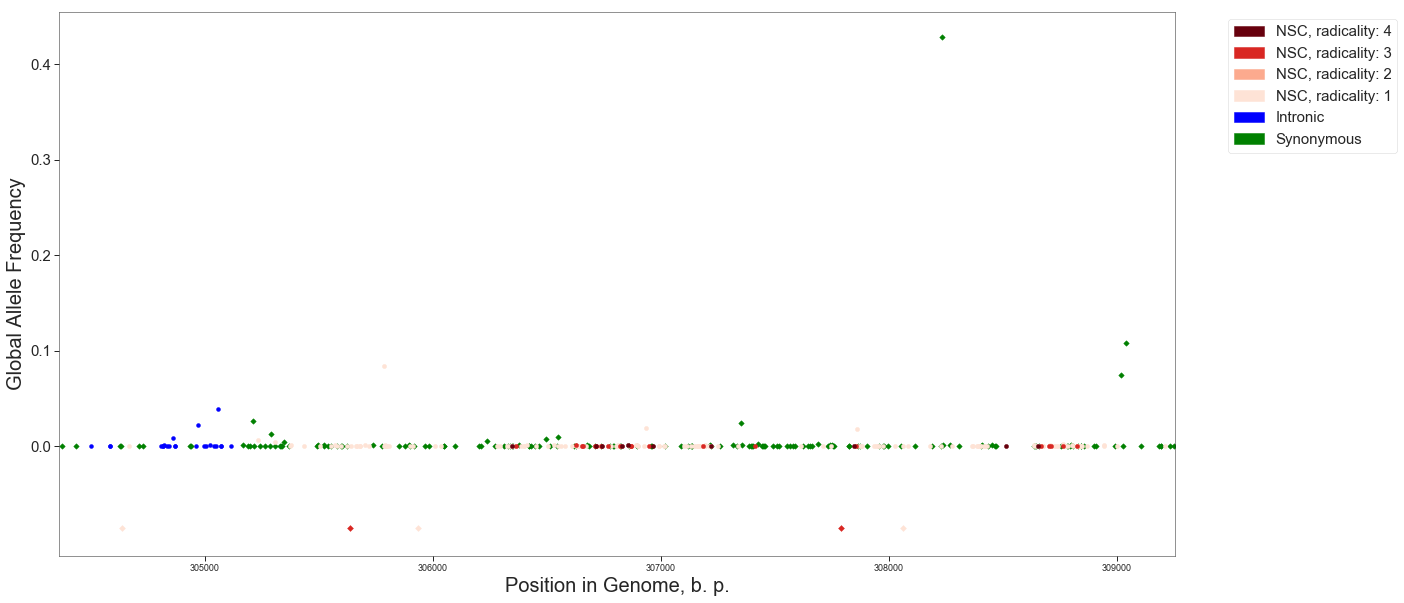

step 30 
 gene ID: PF3D7_0628200 
 start, b. p.: 1159862 
 end, b. p.: 1169080 
 gene length, b. p.: 9219 
 gene description: protein+kinase+PK4+%28PK4%29 
 gene name: PK4 
 conservation score: 0.347005208


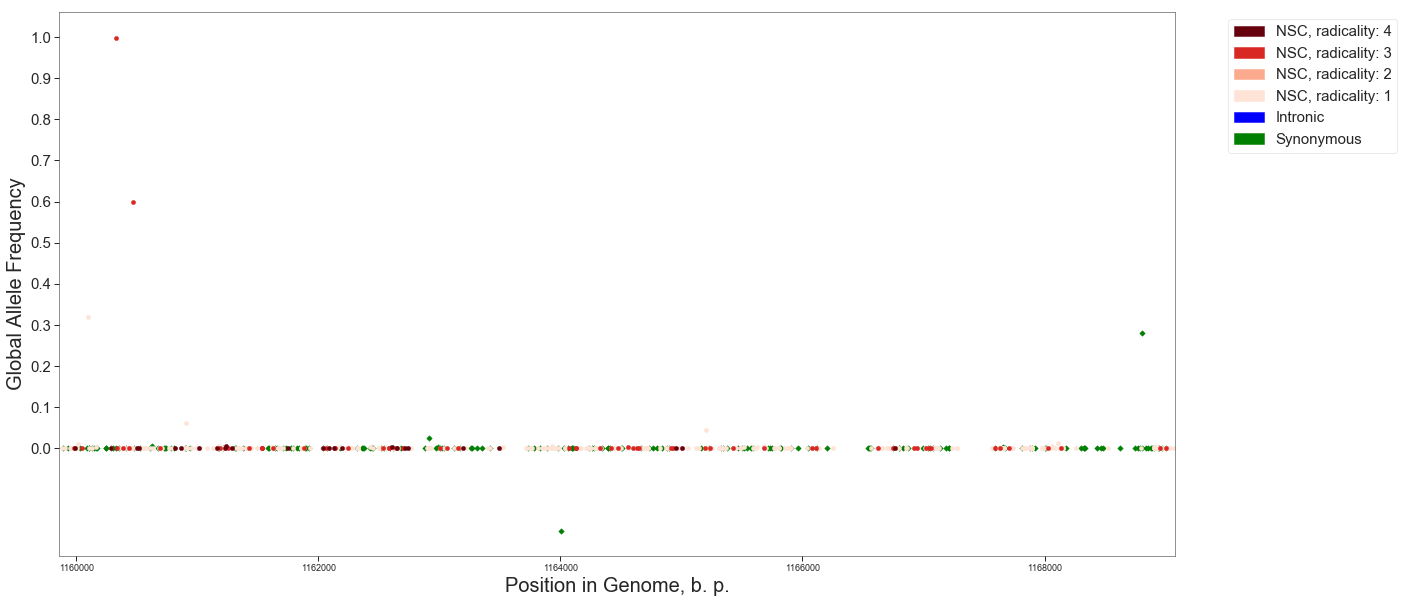

step 31 
 gene ID: PF3D7_0525100 
 start, b. p.: 1041745 
 end, b. p.: 1043766 
 gene length, b. p.: 2022 
 gene description: acyl-CoA+synthetase+%28ACS10%29 
 gene name: ACS10 
 conservation score: 3.127786033


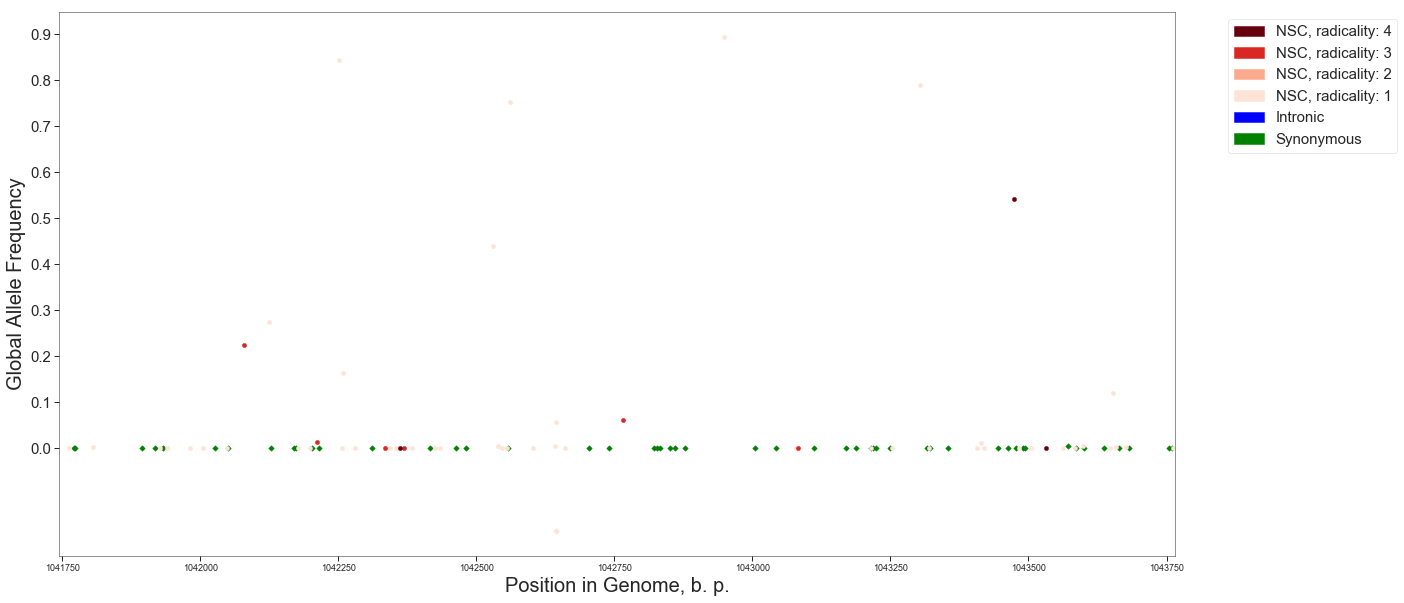

In [403]:
plotting_advanced(gene_picks_CT, df_Pf6_variants, df_cand_transp,score_metric='Grantham')

The next cell was supposed to plot mapping for the high lds gene picks, but all of those ended up being in the C&T list anyway, so skip it!!!

In [416]:
#plotting_advanced(['PF3D7_0312500'],df_variants_MFR3,df_high_lds)

In [417]:
consscore = []     # y
nonsyn_num = []    # x

common_list = list(set(list(gene_picks_CT + gene_picks_lds)))

for elem in common_list:
    gene_start = df_MALDA_lds['start'][list(df_MALDA_lds['Gene_ID']).index(elem)] # gene start
    gene_end = df_MALDA_lds['end'][list(df_MALDA_lds['Gene_ID']).index(elem)]  # gene end
    gene_len = (gene_end-gene_start+1)
    if not np.isnan(df_MALDA_lds['Conservation score'][list(df_MALDA_lds.Gene_ID).index(elem)]):
        #print(elem, df_MALDA_lds['Conservation score'][list(df_MALDA_lds.Gene_ID).index(elem)])
        consscore.append(df_MALDA_lds['Conservation score'][list(df_MALDA_lds.Gene_ID).index(elem)])
        nonsyn_num.append((len(df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                                & (df_Pf6_variants.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')]))
                         /len(df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                         & ((df_Pf6_variants.SNPEFF_EFFECT == 'SYNONYMOUS_CODING')
                                    | (df_Pf6_variants.SNPEFF_EFFECT == 'SYNONYMOUS_STOP'))]))
        #if (df_MALDA_lds['Conservation score'][list(df_MALDA_lds.Gene_ID).index(elem)]<0.23):
        #    print(elem)


Plotting N/S (non-synonymous/synonumous ratio) in respect to gene conservation score

correlation matrix [[ 1.         -0.71422716]
 [-0.71422716  1.        ]]
len x 29 len y 29


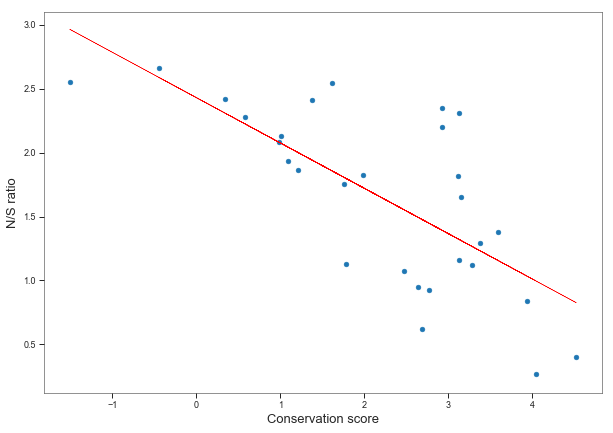

[-1.505475785, -0.447368421, 0.347005208, 0.582369942, 0.980514419, 1.005791506, 1.090647941, 1.216040042, 1.377237852, 1.616468039, 1.756254009, 1.778911565, 1.989257813, 2.475714286, 2.640151515, 2.6875, 2.766101695, 2.918287938, 2.920382166, 3.116521739, 3.125, 3.127786033, 3.149193548, 3.286116984, 3.378289474, 3.592563291, 3.930029155, 4.037650602, 4.520833333]


In [420]:
x_my = nonsyn_num
y_my = consscore
x = y_my
y = x_my
#print(x,y)                         
print('correlation matrix',np.corrcoef(x, y))
fig = plt.figure(figsize=[10, 7])
fig.add_subplot(111)
plt.scatter(x,y)
plt.xlabel('Conservation score',fontsize=13)
plt.ylabel('N/S ratio',fontsize=13)
print('len x',len(x), 'len y', len(y))
# for i in range(len(x)):
#     print(i,x[i])
#     if x[i] < 0.23:
#         x.remove(x[i])
#         y.remove(y[i])
x = y_my
y = x_my
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")
plt.show()
print(sorted(x))

In [ ]:
# quick calculator
substit = input()
print(max(Grantham_matrix[substit[0]][substit[1]],Grantham_matrix[substit[1]][substit[0]]))

Skip pretty much everything that follows after this

In [203]:
# ADVANCED PLOTTING PF6 VS COWELL (WITH GRANTHAM SCORE METRIC)

def plotting_advanced_with_bars(gene_picks, Pf6_dataset, Cowell_dataset):
# TODO: add pictures of gene structures, Fluff about with domains and aa substitutions, manual cleanup!
    i = 0
    for elem in gene_picks:                          # elem is a genen ID from gene_picks
        
        gene_start = Cowell_dataset['start'][list(Cowell_dataset['Gene_ID']).index(elem)] # gene start
        gene_end = Cowell_dataset['end'][list(Cowell_dataset['Gene_ID']).index(elem)]  # gene end

        
        print('step',i+1, '\n', 'gene ID:', elem,  '\n',                          # some useful information
              'start, b. p.:', gene_start, '\n',
              'end, b. p.:', gene_end, '\n',
              'gene length, b. p.:', gene_end - gene_start + 1, '\n',
              'gene description:', Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)], '\n',
              'gene name:',
                Cowell_dataset['Gene Name'][list(Cowell_dataset['Gene_ID']).index(elem)],'\n',
              'conservation score:', Cowell_dataset['Conservation score'][list(Cowell_dataset['Gene_ID']).index(elem)])

        # non-synonymous coding, start loss and stop gain SNPs from Cowell
        x_Cowell_important_4 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset.Severity == 4) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
        x_Cowell_important_3 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset.Severity == 3) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
                        
        x_Cowell_important_2 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset.Severity == 2) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)
        
        
        x_Cowell_important_1 = list(Cowell_dataset[    (Cowell_dataset.Gene_ID == elem) & 
                                                   (Cowell_dataset.Severity == 1) &
                                                  ( (Cowell_dataset['Effect'] == 'non_synonymous_coding') |
                                                   (Cowell_dataset['Effect'] == 'NON_SYNONYMOUS_CODING') | 
                                                   (Cowell_dataset['Effect'] == 'START_LOST') |
                                                  (Cowell_dataset['Effect'] == 'stop_gained') ) ].Position)

        # intergenic, intergenic_region, intron_variant and splice_region_variant+intron_variant SNPs from Cowell
        x_Cowell_noncod = list(Cowell_dataset[  (Cowell_dataset.Gene_ID == elem) 
                                          & ((Cowell_dataset.Effect == 'intergenic') |
                                                  (Cowell_dataset.Effect == 'intergenic_region') |
                                                  (Cowell_dataset.Effect == 'intron_variant') |
                                                (Cowell_dataset.Effect == 'splice_region_variant+intron_variant'))
                                              ].Position)



        # non-synonymous coding, start loss, stop gain and stop loss SNPs from Pf6
        x_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        x_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
                                                   #].POS)
        x_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        
        x_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
                    
        y_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        y_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                                                   #].POS)
        y_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        
        y_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & (Pf6_dataset.Severity == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                    
                    
                    


        # intergenic, intragenic and intron SNPs from Pf6
        x_Pf6_noncod = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                           | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON'))
                                                   ].POS)
        y_Pf6_noncod = list(Pf6_dataset[  (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                           | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON'))
                                                   ].AF)
        #print('pass 1')
        y_Cowell_important_1 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 + y_Pf6_noncod)]*len(x_Cowell_important_1) 
        y_Cowell_important_2 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 + y_Pf6_noncod)]*len(x_Cowell_important_2)
        y_Cowell_important_3 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 + y_Pf6_noncod)]*len(x_Cowell_important_3)
        y_Cowell_important_4 = [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 + y_Pf6_noncod)]*len(x_Cowell_important_4)
        y_Cowell_noncod =  [-0.2*max(y_Pf6_important_1 
                                         + y_Pf6_important_2 
                                         + y_Pf6_important_3 
                                         + y_Pf6_important_4 + y_Pf6_noncod)]*len(x_Cowell_noncod)
                                                            # for beauty

        #print('pass 2')
        fig = plt.figure(figsize=[20, 10])
        fig.add_subplot(111)

        plt.xlim( gene_start, gene_end )
        plt.ylabel("AF (Allele Frequency)",fontsize=20)
        #plt.xticks(np.arange(gene_start, gene_end, step=300),fontsize=13)
        plt.yticks(fontsize=15)
        plt.xlabel("Position in genome, b. p.",fontsize=20)    
        
        #ax.set_yticks(plt.yticks[1:])
        # colors
        sev_4_color = '#67000d'
        sev_3_color = '#d92723'
        sev_2_color = '#fcaa8e'
        sev_1_color = '#fee3d6'
        noncod_color = '#9ed9bb'

        
        
        plt.scatter(x_Cowell_important_1,y_Cowell_important_1,color=sev_1_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_2,y_Cowell_important_2,color=sev_2_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_3,y_Cowell_important_3,color=sev_3_color,s=17,marker='D')
        plt.scatter(x_Cowell_important_4,y_Cowell_important_4,color=sev_4_color,s=17,marker='D')

        plt.scatter(x_Cowell_noncod,y_Cowell_noncod,c=noncod_color,s=15,marker='D')
        
        plt.scatter(x_Pf6_important_1,y_Pf6_important_1,c=sev_1_color,s=17)
        plt.scatter(x_Pf6_important_2,y_Pf6_important_2,c=sev_2_color,s=17)
        plt.scatter(x_Pf6_important_3,y_Pf6_important_3,c=sev_3_color,s=17)
        plt.scatter(x_Pf6_important_4,y_Pf6_important_4,c=sev_4_color,s=17)
        
        plt.scatter(x_Pf6_noncod,y_Pf6_noncod,c=noncod_color,s=15)
        
#         plt.bar(x_Cowell_important_1,y_Cowell_important_1,color=sev_1_color)
#         plt.bar(x_Cowell_important_2,y_Cowell_important_2,color=sev_2_color)
#         plt.bar(x_Cowell_important_3,y_Cowell_important_3,color=sev_3_color)
#         plt.bar(x_Cowell_important_4,y_Cowell_important_4,color=sev_4_color)

#         plt.bar(x_Cowell_noncod,y_Cowell_noncod,color=noncod_color)
        
#         plt.bar(x_Pf6_important_1,y_Pf6_important_1,color=sev_1_color)
#         plt.bar(x_Pf6_important_2,y_Pf6_important_2,color=sev_2_color)
#         plt.bar(x_Pf6_important_3,y_Pf6_important_3,color=sev_3_color)
#         plt.bar(x_Pf6_important_4,y_Pf6_important_4,color=sev_4_color)
        
#         plt.bar(x_Pf6_noncod,y_Pf6_noncod,color=noncod_color)
        
        
        
        #    plt.title(elem,
        #             Pf6_dataset['SNPEFF_GENE_NAME'][list(Pf6_dataset['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],   
        #             Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)])

        
        
        patch_sev_4 = mpatches.Patch(color=sev_4_color, label='NSC, severity: 4')
        patch_sev_3 = mpatches.Patch(color=sev_3_color, label='NSC, severity: 3')
        patch_sev_2 = mpatches.Patch(color=sev_2_color, label='NSC, severity: 2')
        patch_sev_1 = mpatches.Patch(color=sev_1_color, label='NSC, severity: 1')
        patch_noncod = mpatches.Patch(color=noncod_color, label='non-coding')
        plt.legend(handles=[patch_sev_4,patch_sev_3,patch_sev_2,patch_sev_1,patch_noncod],prop={'size': 15},
                   bbox_to_anchor=(1.04,1), loc="upper left")
        
        
        i += 1
        plt.show()

In [85]:
#plotting_advanced_with_bars(gene_picks_lds, df_Pf6_variants, df_high_lds)

step 1 
 gene ID: PF3D7_0826100 
 start, b. p.: 1113369 
 end, b. p.: 1139144 
 gene length, b. p.: 25776 
 gene description: E3+ubiquitin-protein+ligase%2C+putative 
 gene name: nan 
 conservation score: 1.216040042


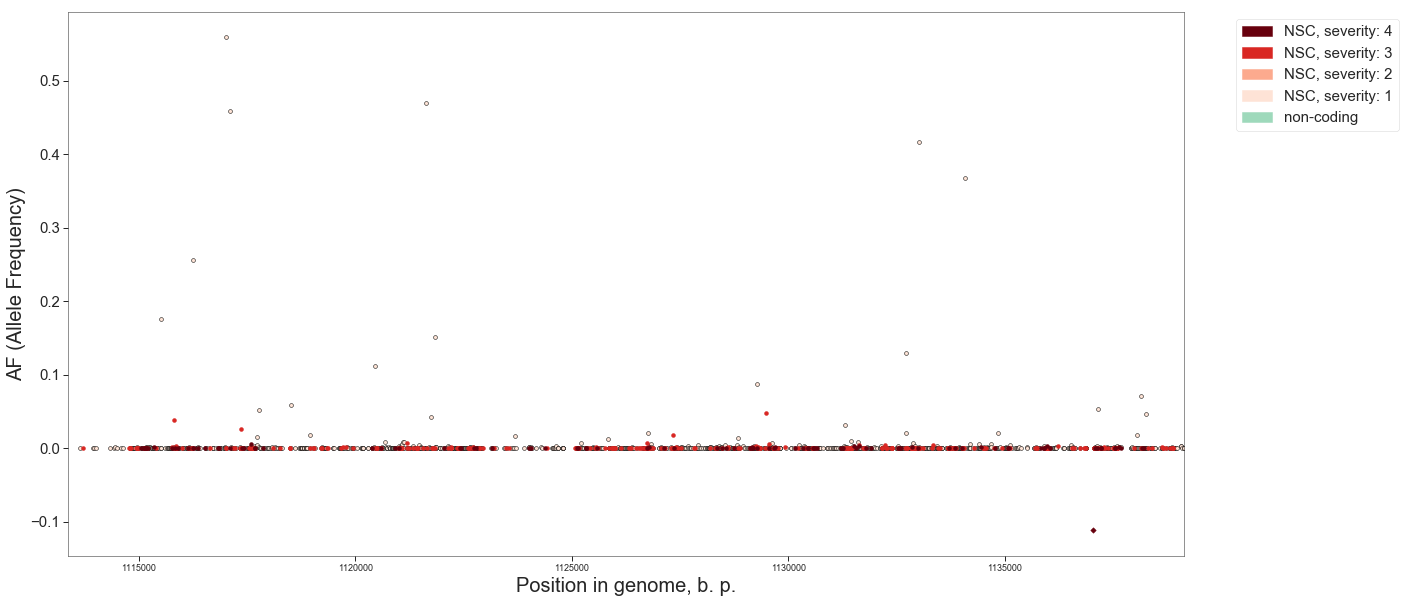

step 2 
 gene ID: PF3D7_1036800 
 start, b. p.: 1448692 
 end, b. p.: 1451646 
 gene length, b. p.: 2955 
 gene description: acetyl-CoA+transporter%2C+putative 
 gene name: ACT 
 conservation score: 2.766101695


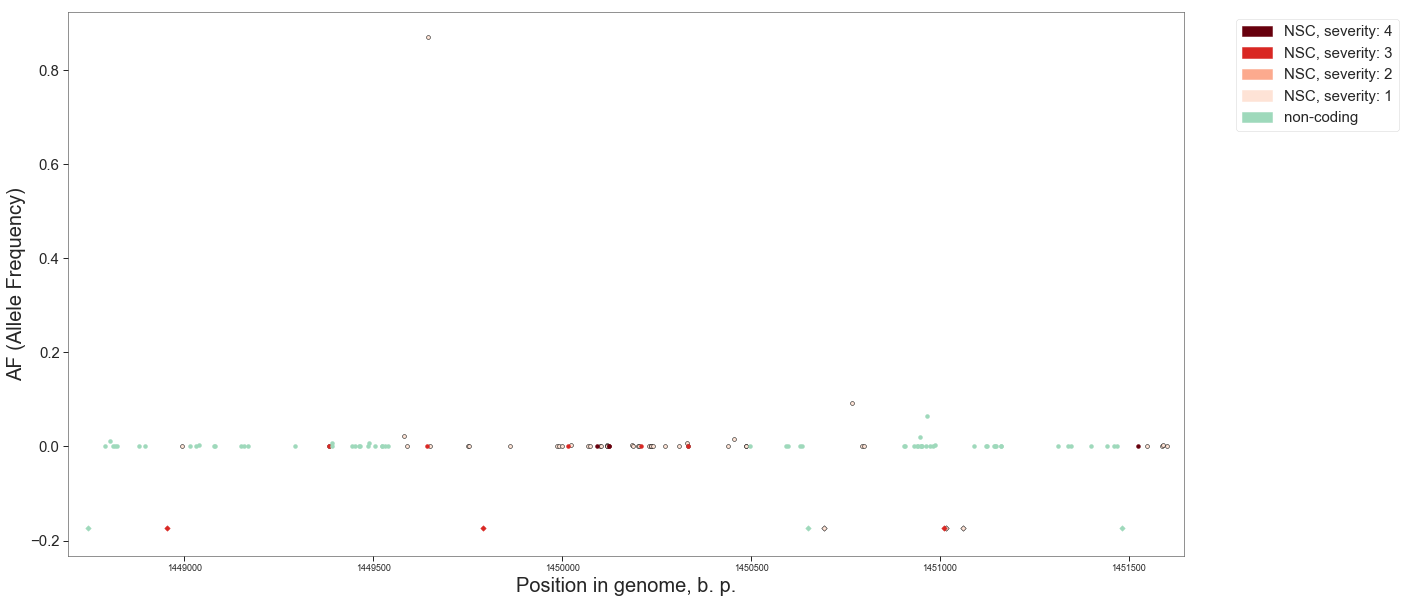

step 3 
 gene ID: PF3D7_0613800 
 start, b. p.: 566139 
 end, b. p.: 578993 
 gene length, b. p.: 12855 
 gene description: transcription+factor+with+AP2+domain%28s%29+%28ApiAP2%29 
 gene name: ApiAP2 
 conservation score: -1.505475785


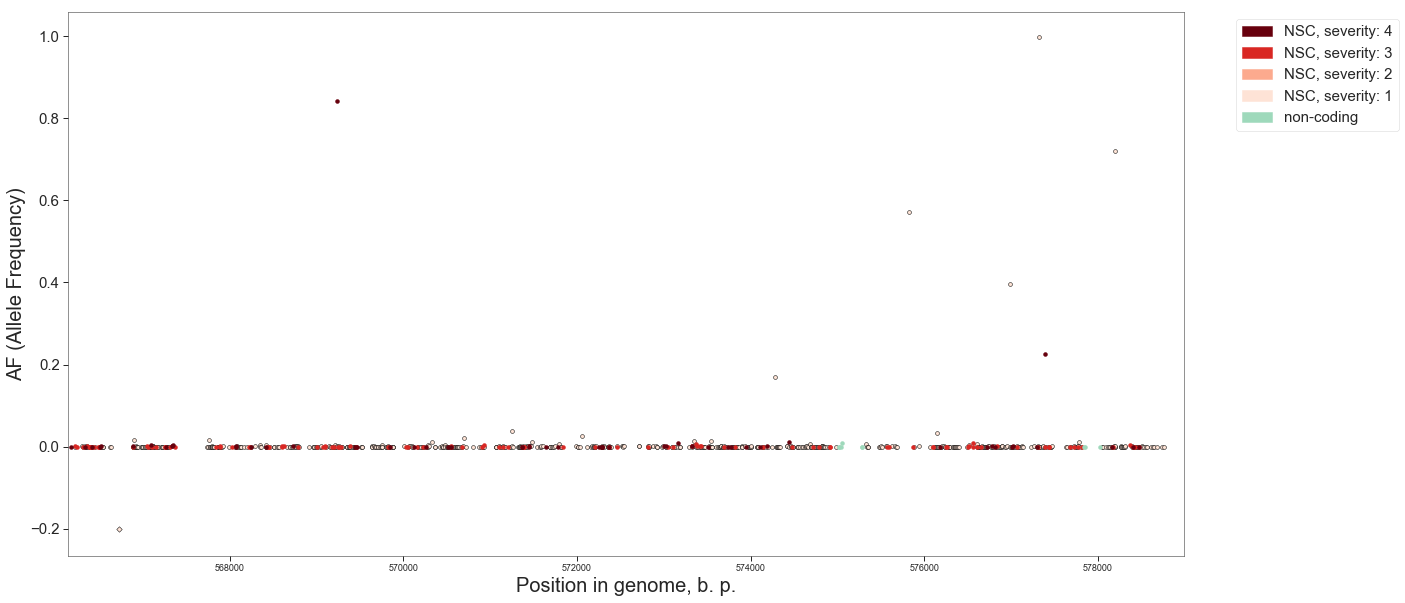

step 4 
 gene ID: PF3D7_1211900 
 start, b. p.: 529005 
 end, b. p.: 532799 
 gene length, b. p.: 3795 
 gene description: non-SERCA-type+Ca2++-transporting+P-ATPase+%28ATP4%29 
 gene name: ATP4 
 conservation score: 3.592563291


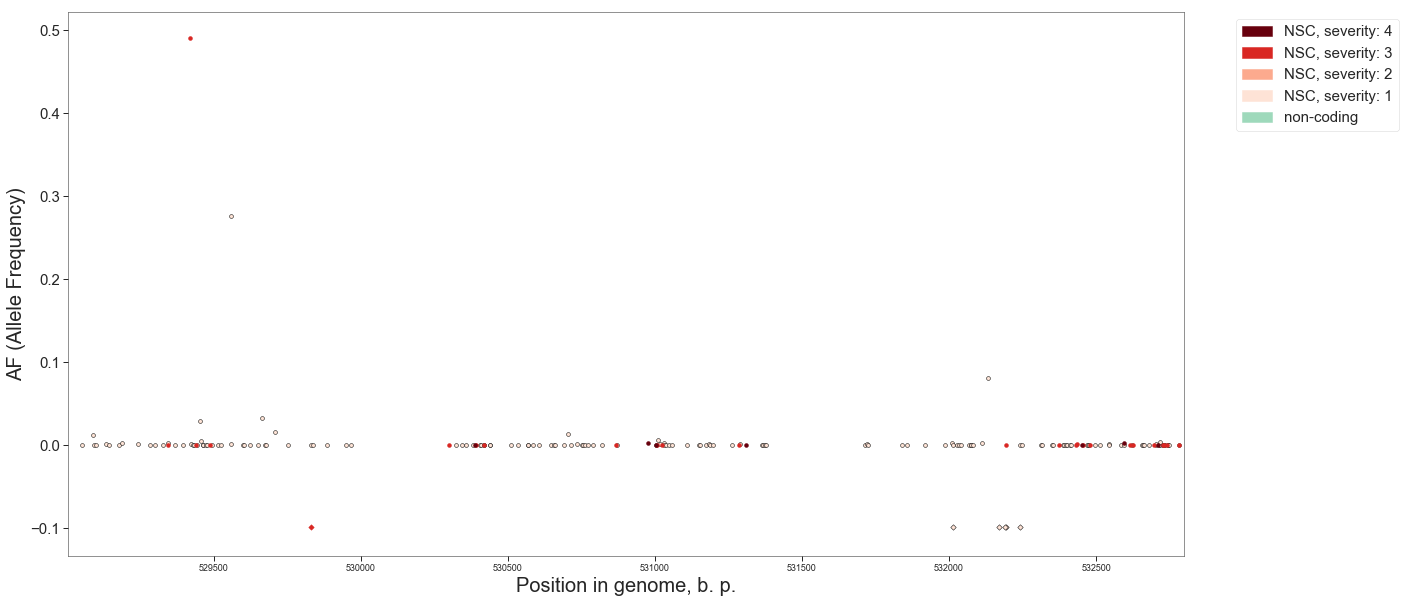

step 5 
 gene ID: PF3D7_0103100 
 start, b. p.: 134353 
 end, b. p.: 139257 
 gene length, b. p.: 4905 
 gene description: vacuolar protein sorting-associated protein 51, putative 
 gene name: VPS51 
 conservation score: -0.447368421


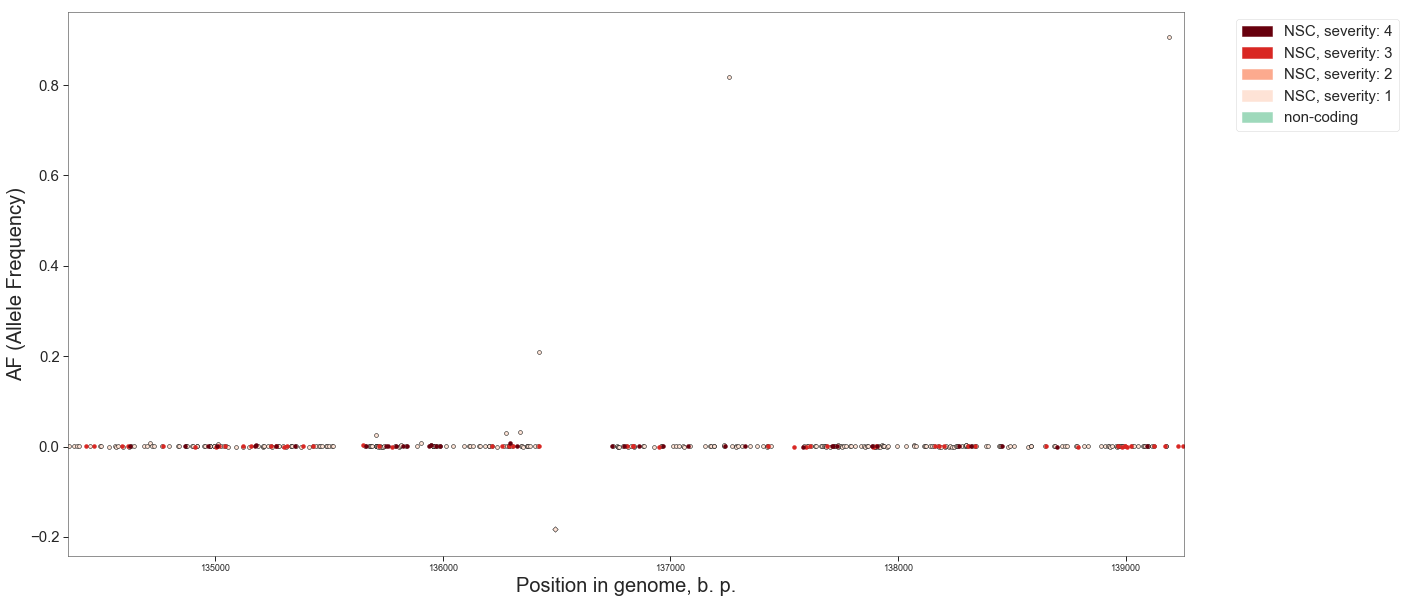

step 6 
 gene ID: PF3D7_1472100 
 start, b. p.: 2941600 
 end, b. p.: 2943259 
 gene length, b. p.: 1660 
 gene description: Yip1+protein%2C+putative 
 gene name: YIP1 
 conservation score: 2.920382166


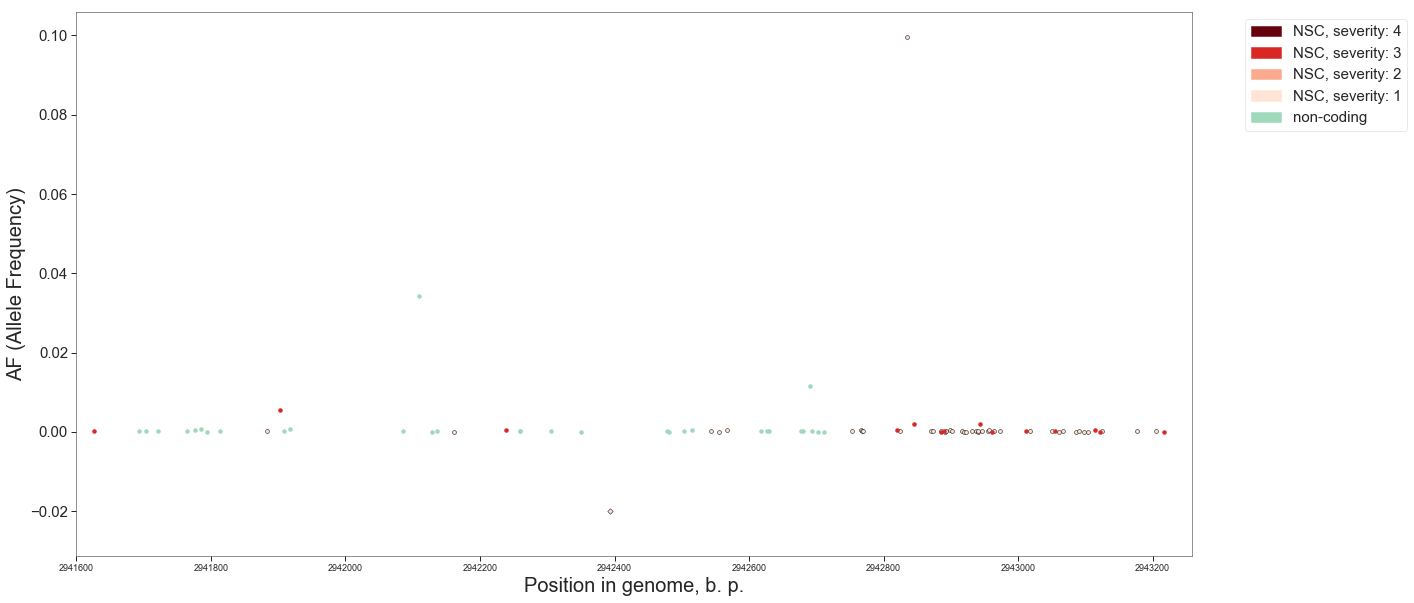

step 7 
 gene ID: PF3D7_1238800 
 start, b. p.: 1610363 
 end, b. p.: 1612741 
 gene length, b. p.: 2379 
 gene description: acyl-CoA+synthetase+%28ACS11%29 
 gene name: ACS11 
 conservation score: 2.640151515


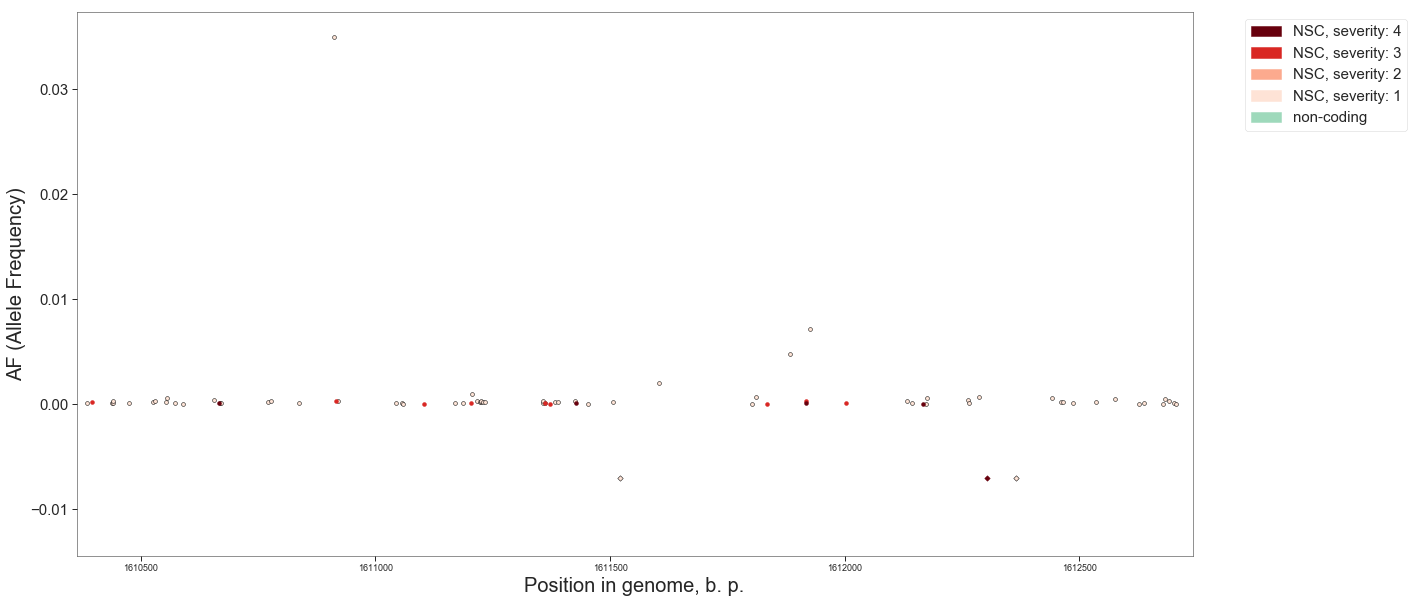

step 8 
 gene ID: PF3D7_0509800 
 start, b. p.: 410268 
 end, b. p.: 415308 
 gene length, b. p.: 5041 
 gene description: phosphatidylinositol+4-kinase 
 gene name: PI4K 
 conservation score: 1.756254009


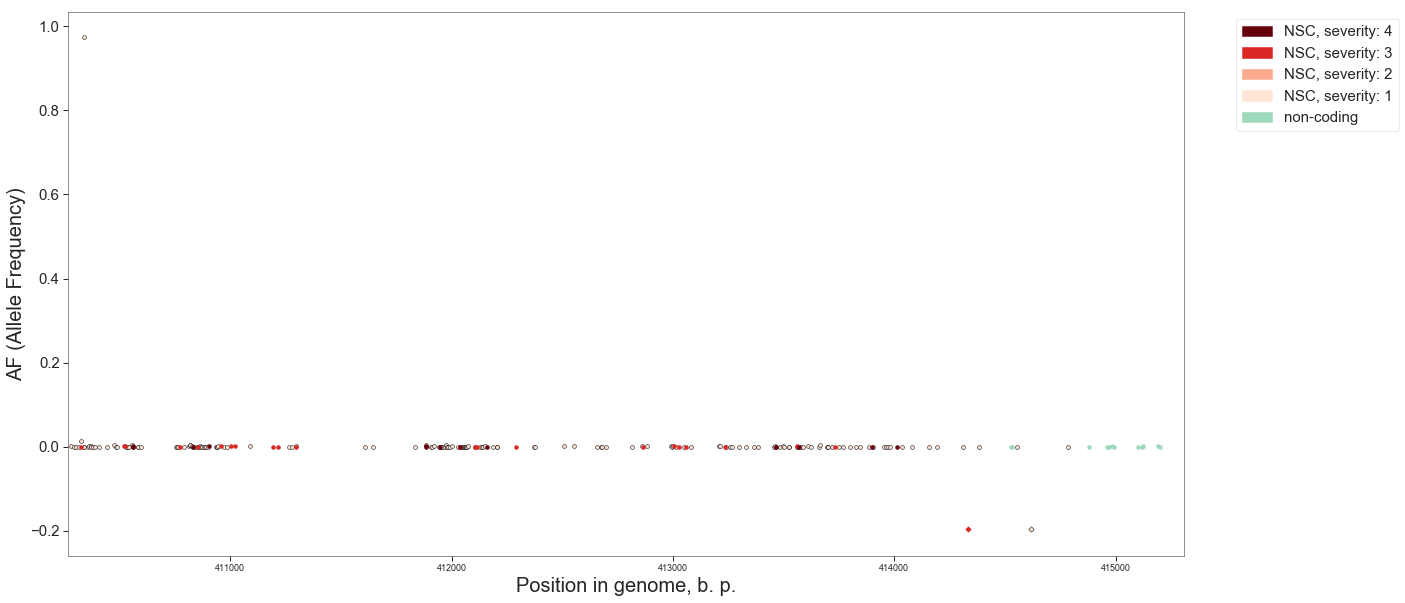

step 9 
 gene ID: PF3D7_1434000 
 start, b. p.: 1364749 
 end, b. p.: 1366113 
 gene length, b. p.: 1365 
 gene description: CCR4-associated+factor+16%2C+putative+%28CAF16%29 
 gene name: CAF16 
 conservation score: 2.918287938


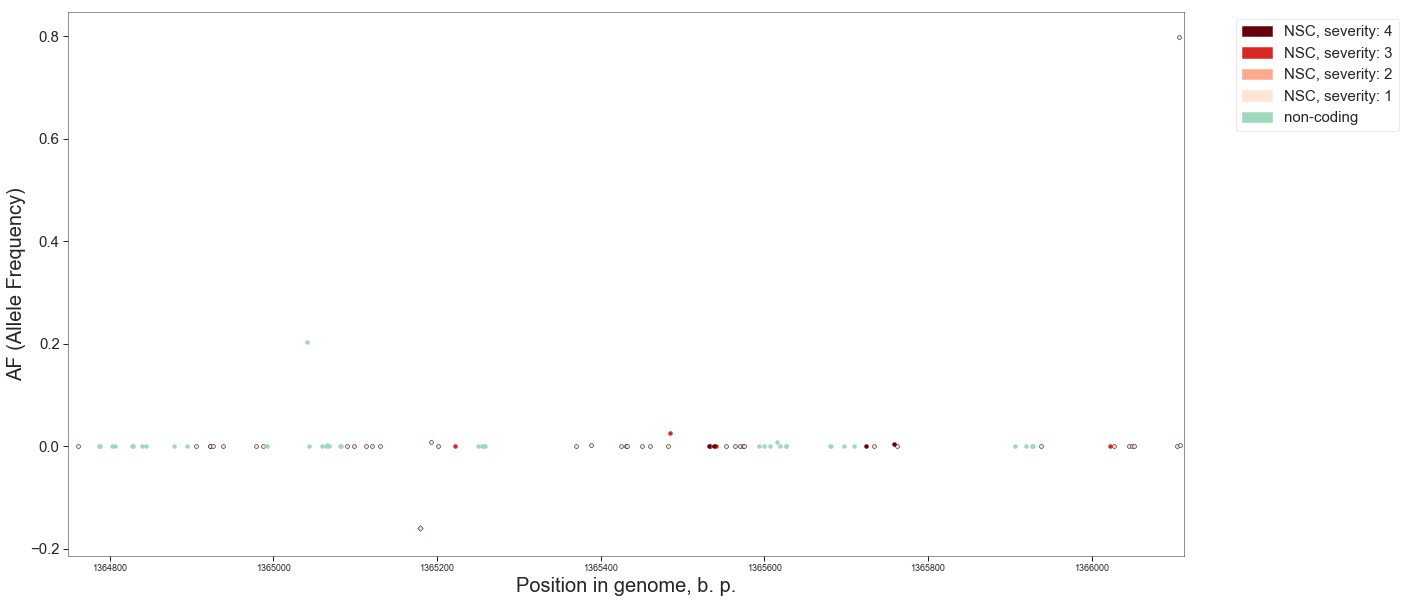

step 10 
 gene ID: PF3D7_0629500 
 start, b. p.: 1213948 
 end, b. p.: 1216005 
 gene length, b. p.: 2058 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: nan


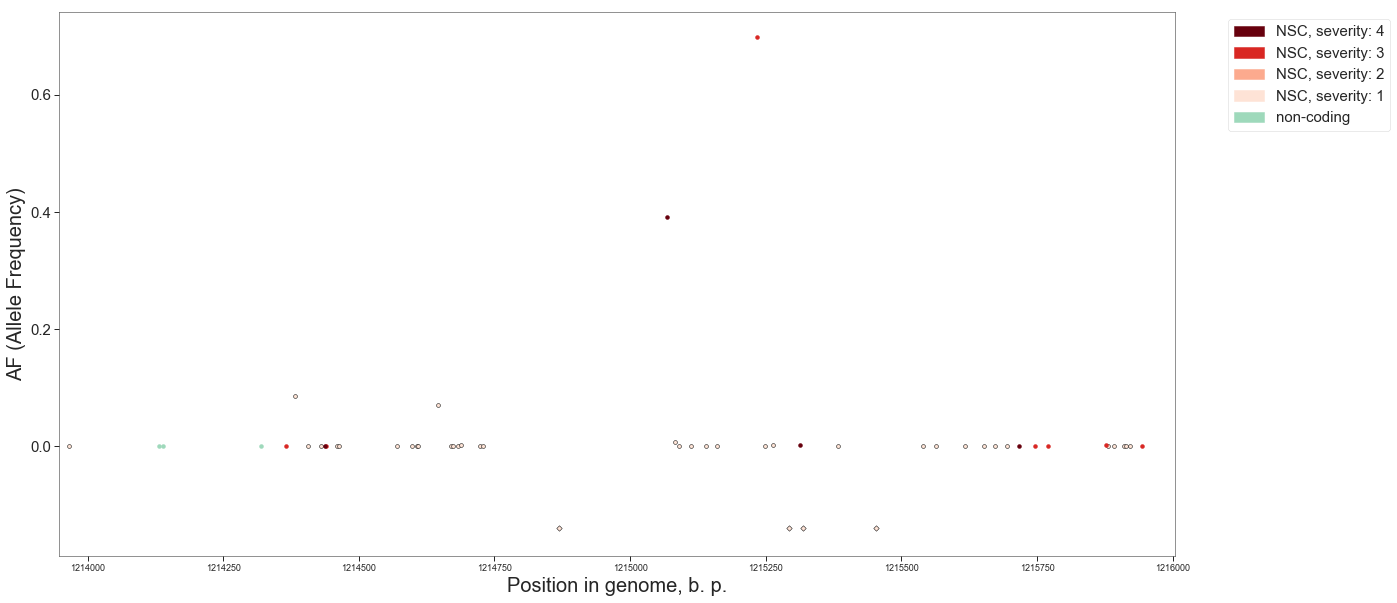

step 11 
 gene ID: PF3D7_0109800 
 start, b. p.: 380697 
 end, b. p.: 382424 
 gene length, b. p.: 1728 
 gene description: phenylalanine--tRNA+ligase%2C+putative 
 gene name: cPheRS 
 conservation score: 3.116521739


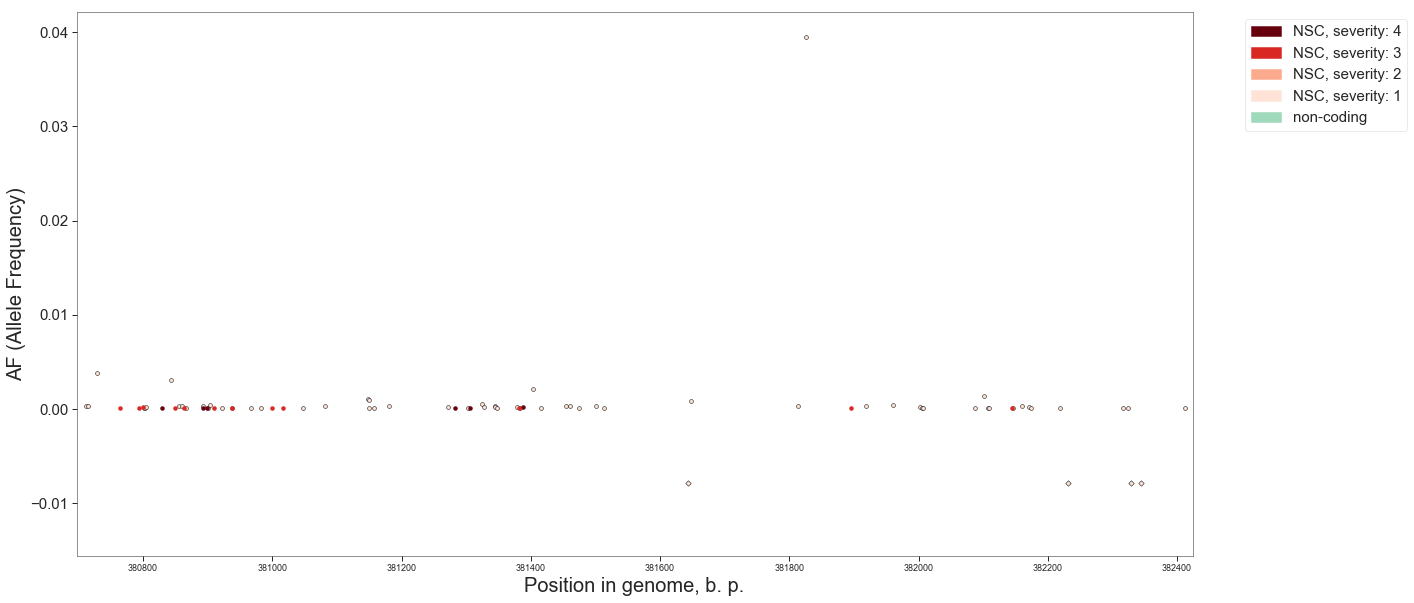

step 12 
 gene ID: PF3D7_0628200 
 start, b. p.: 1159862 
 end, b. p.: 1169080 
 gene length, b. p.: 9219 
 gene description: protein+kinase+PK4+%28PK4%29 
 gene name: PK4 
 conservation score: 0.347005208


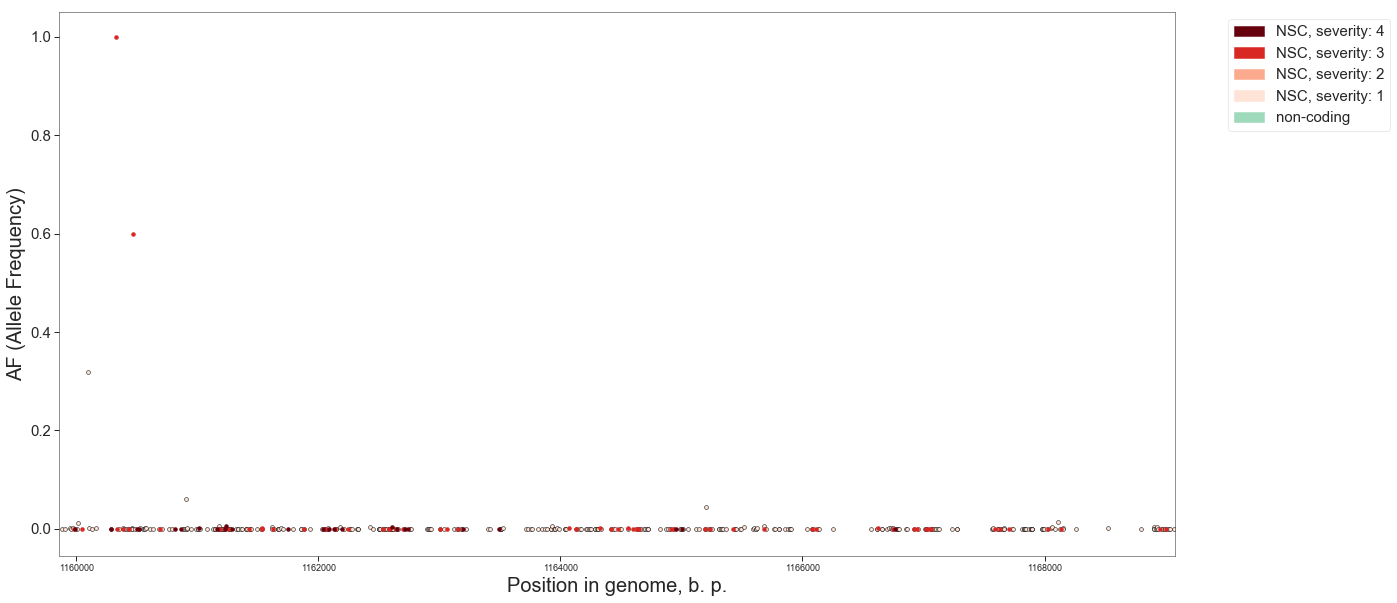

step 13 
 gene ID: PF3D7_1241700 
 start, b. p.: 1778154 
 end, b. p.: 1779411 
 gene length, b. p.: 1258 
 gene description: replication+factor+C+subunit+4%2C+putative 
 gene name: RFC4 
 conservation score: 4.520833333


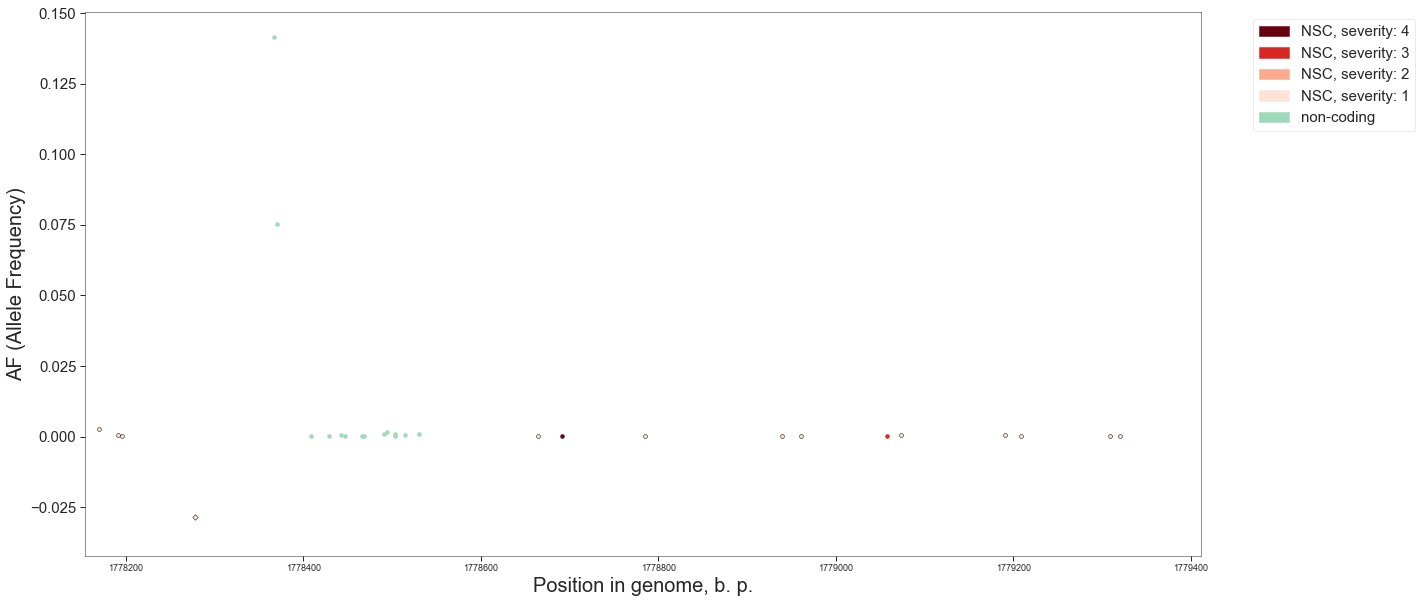

step 14 
 gene ID: PF3D7_1208400 
 start, b. p.: 390932 
 end, b. p.: 395626 
 gene length, b. p.: 4695 
 gene description: amino+acid+transporter%2C+putative 
 gene name: nan 
 conservation score: 1.377237852


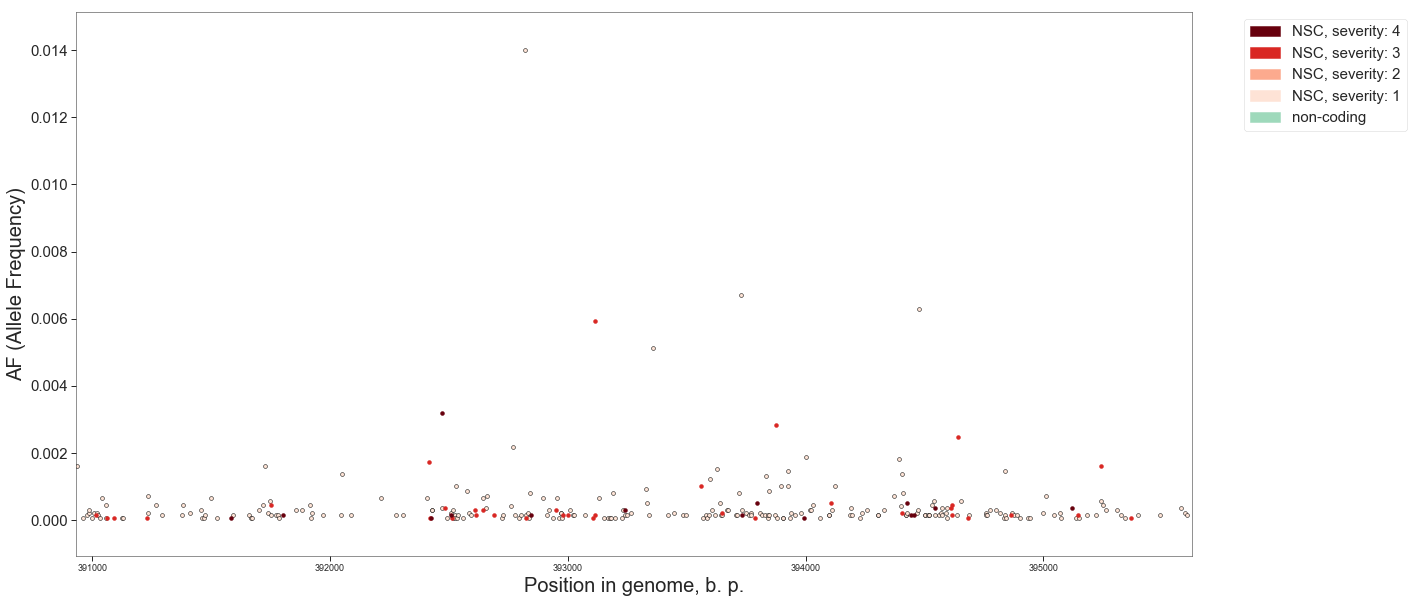

step 15 
 gene ID: PF3D7_1113300 
 start, b. p.: 519189 
 end, b. p.: 520220 
 gene length, b. p.: 1032 
 gene description: UDP-galactose+transporter%2C+putative 
 gene name: UGT 
 conservation score: 3.930029155


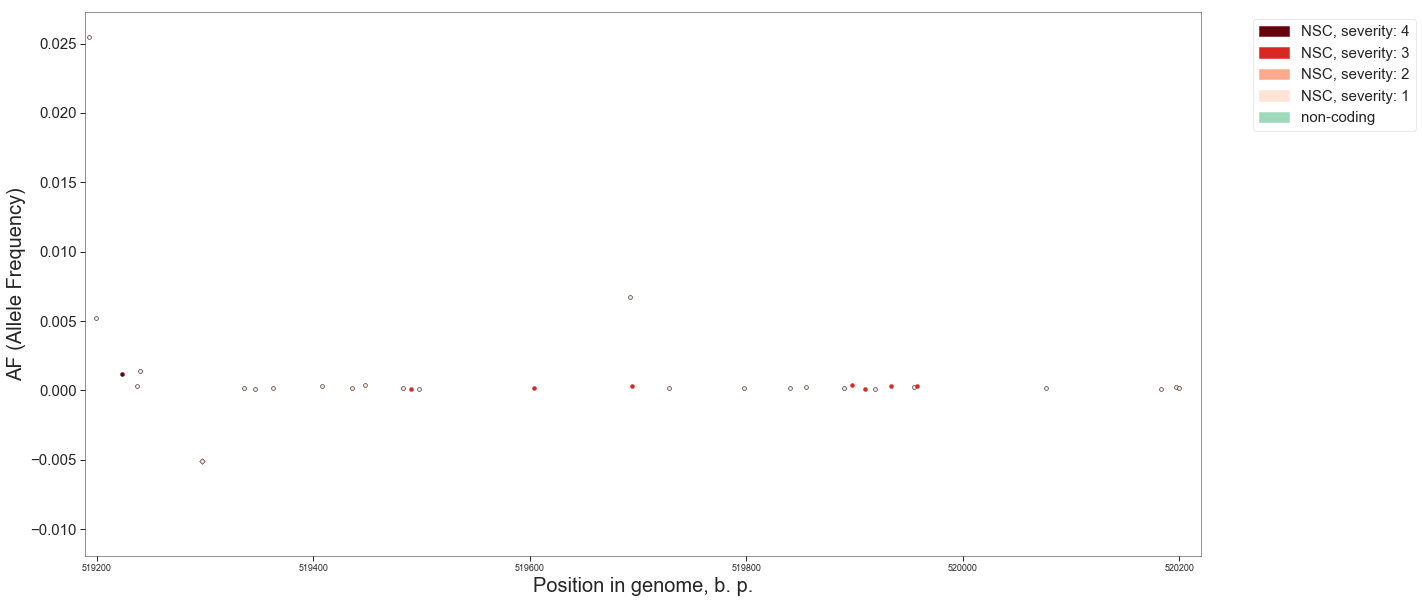

step 16 
 gene ID: PF3D7_0709700 
 start, b. p.: 435089 
 end, b. p.: 436195 
 gene length, b. p.: 1107 
 gene description: lysophospholipase%2C+putative 
 gene name: nan 
 conservation score: 2.6875


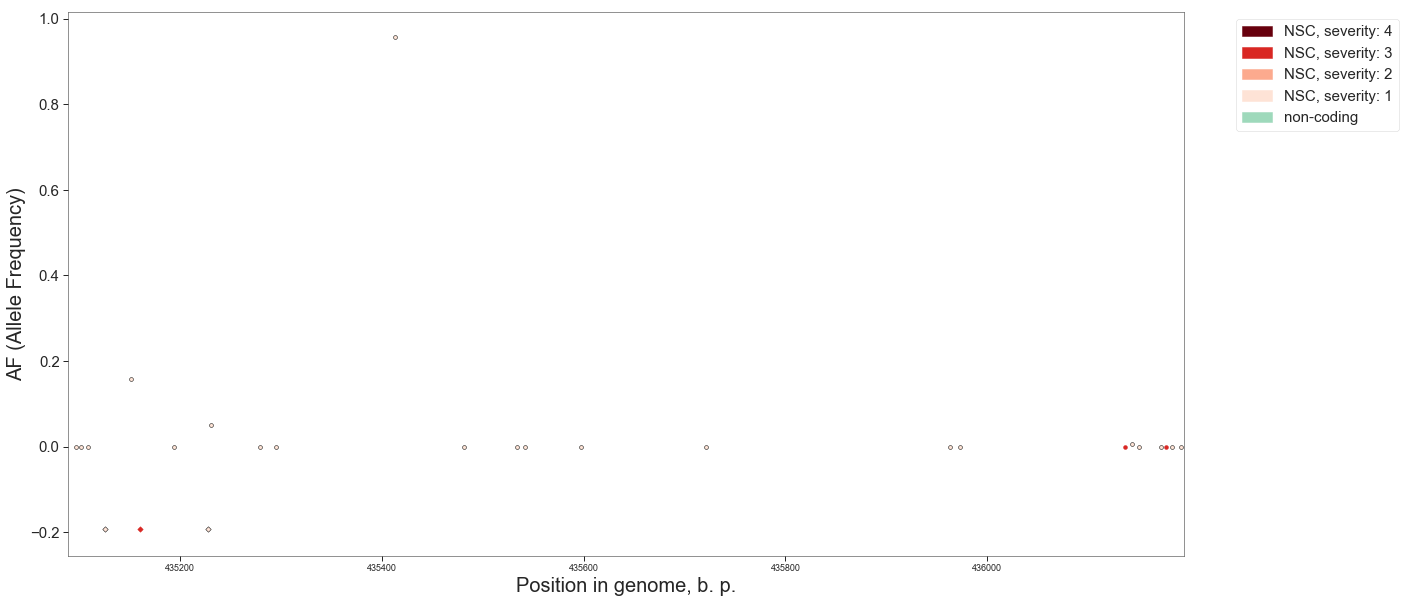

step 17 
 gene ID: PF3D7_0107500 
 start, b. p.: 304362 
 end, b. p.: 309257 
 gene length, b. p.: 4896 
 gene description: lipid%2Fsterol%3AH++symporter 
 gene name: nan 
 conservation score: 1.778911565


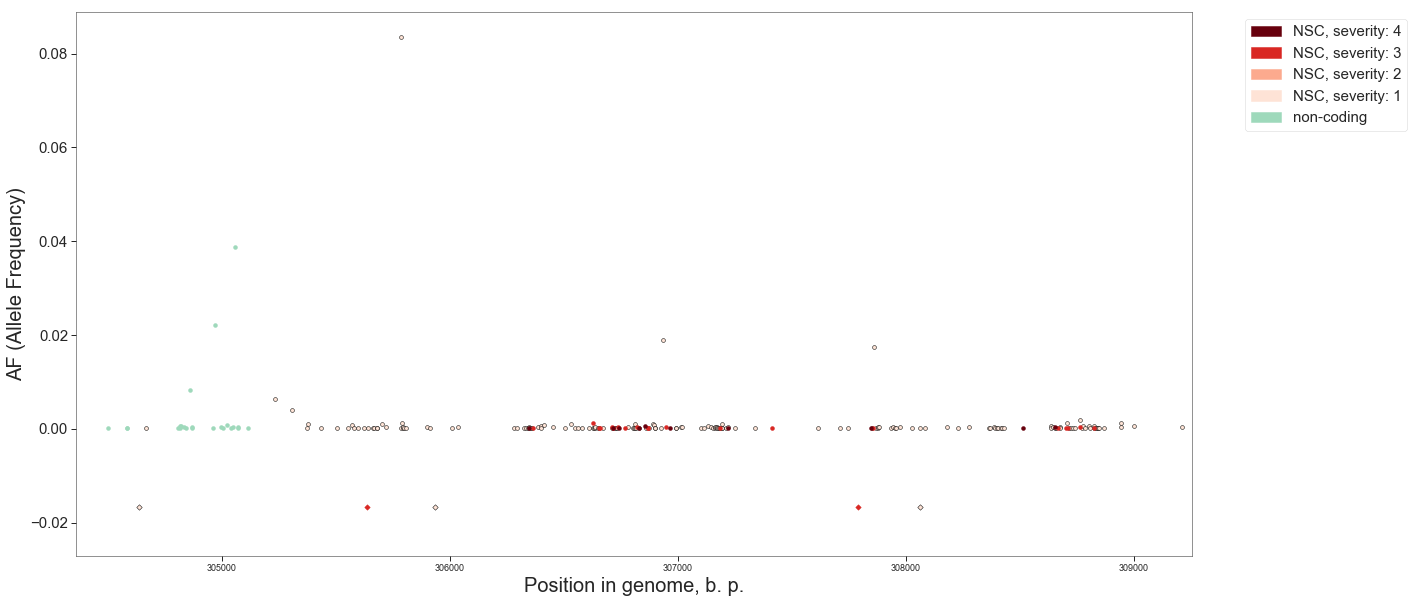

step 18 
 gene ID: PF3D7_0417200 
 start, b. p.: 748088 
 end, b. p.: 749914 
 gene length, b. p.: 1827 
 gene description: bifunctional+dihydrofolate+reductase-thymidylate+synthase+%28DHFR-TS%29 
 gene name: DHFR-TS 
 conservation score: 3.378289474


KeyboardInterrupt: 

In [182]:
plotting_advanced_with_bars(gene_picks_CT, df_Pf6_variants, df_cand_transp)

In [67]:
df_that_gene = df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1')] # transporter, putative

In [68]:
df_that_gene.to_excel('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/PF3D7_0312500.xlsx')

In [70]:
#list(df_Pf6_variants.SNPEFF_GENE_NAME).index('CYTB')

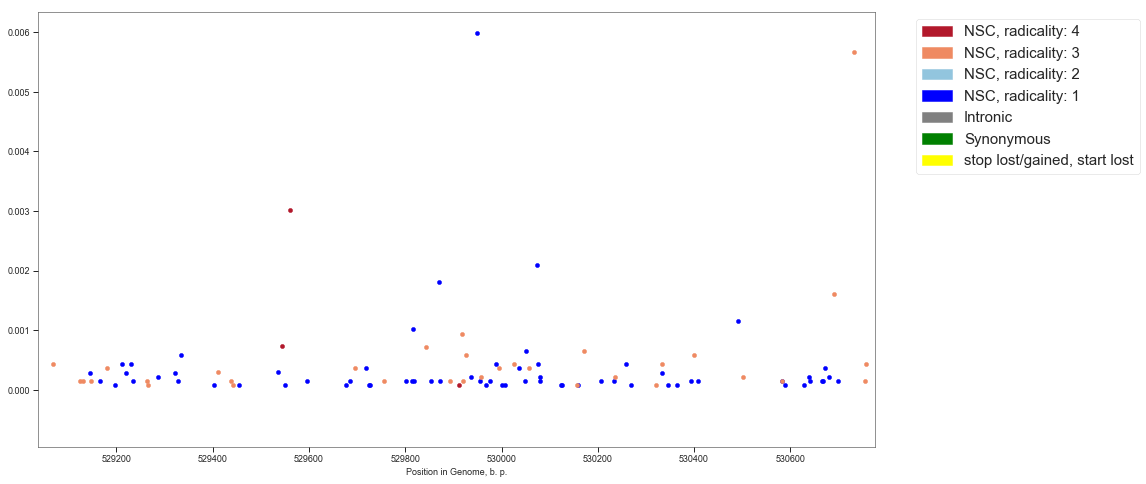

In [84]:
# non-synonymous coding, start loss, stop gain and stop loss SNPs from Pf6
Pf6_dataset = df_Pf6_variants
x_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
x_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
                                                   #].POS)
x_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
        
x_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
                    
y_Pf6_important_4 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 4)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
y_Pf6_important_3 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 3)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                        
y_Pf6_important_2 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 2)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        
y_Pf6_important_1 = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1') 
                                             & (Pf6_dataset.Severity_CCF == 1)  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
                    
                    
# intergenic, intragenic and intron SNPs from Pf6
x_Pf6_intr = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SPLICE_SITE_DONOR'))
                                                   ].POS)
y_Pf6_intr = list(Pf6_dataset[  (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'INTRAGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTERGENIC')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'INTRON')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SPLICE_SITE_DONOR'))
                                                   ].AF)
# synonymous (aggregation of synonymous mutation ~ -> conservative region)
x_Pf6_syn = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_CODING')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_STOP'))
                                                   ].POS)
        
        
        
y_Pf6_syn = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                                     & ((Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_CODING')
                                                        | (Pf6_dataset.SNPEFF_EFFECT == 'SYNONYMOUS_STOP'))
                                                   ].AF)
x_Pf6_important_start_stop = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & ((Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].POS)
y_Pf6_important_start_stop = list(Pf6_dataset[ (Pf6_dataset.SNPEFF_TRANSCRIPT_ID == elem + '.1') 
                                             & ((Pf6_dataset.SNPEFF_EFFECT == 'START_LOST')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_GAINED')
                                                          | (Pf6_dataset.SNPEFF_EFFECT == 'STOP_LOST')) ].AF)
        
# colors
sev_4_color = '#b2182b'
sev_3_color = '#ef8a62'
sev_2_color = '#92c5de'
sev_1_color = 'blue'
syn_color = 'green'
intr_color = 'grey'
stop_start_color = 'yellow'
        
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(111)
plt.xlim( 529037, 530776 )    
    
plt.scatter(x_Pf6_intr,y_Pf6_intr,c=intr_color,s=15)
plt.scatter(x_Pf6_syn,y_Pf6_syn,c=syn_color,s=15,marker='D')
plt.scatter(x_Pf6_important_start_stop,y_Pf6_important_start_stop,c=stop_start_color,s=17)

plt.scatter(x_Pf6_important_1,y_Pf6_important_1,c=sev_1_color,s=17)
plt.scatter(x_Pf6_important_2,y_Pf6_important_2,c=sev_2_color,s=17)
plt.scatter(x_Pf6_important_3,y_Pf6_important_3,c=sev_3_color,s=17)
plt.scatter(x_Pf6_important_4,y_Pf6_important_4,c=sev_4_color,s=17)
        
        
        
ax.set_xlabel('Position in Genome, b. p.')
        #    plt.title(elem,
        #             Pf6_dataset['SNPEFF_GENE_NAME'][list(Pf6_dataset['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],   
        #             Cowell_dataset['Gene_Descrip'][list(Cowell_dataset['Gene_ID']).index(elem)])

        
        
patch_sev_4 = mpatches.Patch(color=sev_4_color, label='NSC, radicality: 4')
patch_sev_3 = mpatches.Patch(color=sev_3_color, label='NSC, radicality: 3')
patch_sev_2 = mpatches.Patch(color=sev_2_color, label='NSC, radicality: 2')
patch_sev_1 = mpatches.Patch(color=sev_1_color, label='NSC, radicality: 1')
patch_intr = mpatches.Patch(color=intr_color, label='Intronic')
patch_syn = mpatches.Patch(color=syn_color, label='Synonymous')
patch_stop_start = mpatches.Patch(color=stop_start_color, label='stop lost/gained, start lost')
plt.legend(handles=[patch_sev_4,patch_sev_3,patch_sev_2,patch_sev_1,patch_intr,patch_syn,patch_stop_start],prop={'size': 15},
                   bbox_to_anchor=(1.04,1), loc="upper left")

plt.show()

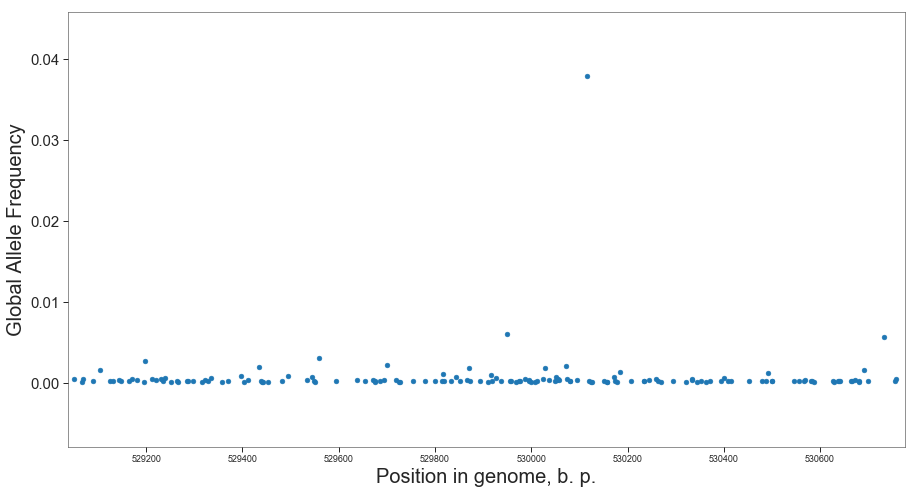

In [69]:
df_Pf6_variants_MFR3 = df_Pf6_variants[df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1']
df_Pf6_variants_MFR3.POS
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(111)
plt.xlim( 529037, 530776 )
plt.ylabel("Global Allele Frequency",fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Position in genome, b. p.",fontsize=20)
plt.scatter(df_Pf6_variants_MFR3.POS,df_Pf6_variants_MFR3.AF)

In [3]:
df_Pf6_variants_cPheRS = df_Pf6_variants[(df_Pf6_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_1447900.1') & (df_Pf6_variants.POS < 1955250) & (df_Pf6_variants.POS > 1955000) & (df_Pf6_variants.SNPEFF_EFFECT='NON')]
#df_Pf6_variants_cPheRS